# Chest X-ray Datasets Statistics

## ChestX-ray8  - ChestX-ray14

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from pylab import *
import itertools
from sklearn.metrics import confusion_matrix
from PlotUtils import *
from utils import read_json
import pathlib
from datasets import ObjectDetectionDataSet
from transformations import Clip, ComposeDouble, FunctionWrapperDouble, normalize_01
from utils import get_filenames_of_path, read_json

import pydicom as dcm
import glob
import os
from tqdm import tqdm
import cv2
from PIL import Image

def LabelCardinality(cLabs):
    if type(cLabs) == type(np.array([1])):
        pass
    else:
        cLabs = np.array(cLabs)
    LC = (1/len(cLabs))  * sum(cLabs)
    return LC
def LabelDensity(cLabs, q):
    if type(cLabs) == type(np.array([1])):
        pass
    else:
        cLabs = np.array(cLabs)
    LC = (1/len(cLabs))  * sum(cLabs/q)
    return LC

# Cambiar el tamaño de la letra
# plt.rcParams.update({'font.size': 22})
# Para cambiar el mapa de color por defecto
plt.rcParams["image.cmap"] = "Set2"
# Para cambiar el ciclo de color por defecto en Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#8C6D31', '#ffdd6b', '#e9e2c9', '#dcae52', '#af7132', '#8C9363', '#637939', '#AD494A', '#E7969C', '#C4CBB9'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#084081', '#0868ac', '#2b8cbe', '#4eb3d3', '#7bccc4', '#a8ddb5', '#ccebc5', '#e0f3db', '#f7fcf0'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac','#053061'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#67001f', '#053061', '#b2182b', '#2166ac', '#d6604d', '#4393c3', '#f4a582', '#92c5de', '#fddbc7','#d1e5f0'])
#--# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#67001f', '#053061', '#b2182b', '#2166ac', '#d6604d', '#4393c3', '#f4a582', '#92c5de', '#fddbc7','#d1e5f0'][::-1])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9','#bc80bd','#ccebc5','#ffed6f'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9','#bc80bd','#ccebc5','#ffed6f'][::-1])
Set_ColorIn(plt.cycler(color=plt.cm.Set2.colors)

# Cambiar el tipo de letra
# plt.rcParams.update({'text.latex.preamble': r'\usepackage{nimbusserif}',
#                      'text.usetex': True,
#                      'font.family': 'serif',
#                      'font.serif': ['Nimbus Roman No9 L'],
#                      'font.size': 16,})
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

plt.rc('font',**{'family':'serif','serif':['Computer Modern']})
plt.rc('text', usetex=True)
# plt.rcParams['text.latex.preamble'] = [r'\boldmath']

In [3]:
labsmap = {'Cardiomegaly':'Cardiomegalia',
           'Emphysema': 'Enfisema',
           'Pleural_Thickening': 'Engrosamiento pleural',
           'Hernia':'Hernia',
           'Edema':'Edema',
           'Fibrosis':'Fibrosis',
           'Consolidation':'Consolidación',
           'Effusion':'Derrame pleural',
           'Infiltration':'Infiltración',
           'Mass':'Masa',
           'Nodule':'Nódulo', 
           'Atelectasis':'Atelectasia', 
           'Pneumothorax':'Neumotórax', 
           'Pneumonia':'Neumonía',
           'No Finding': 'Sin Hallazgo'}
c14 = pd.read_csv('../ChestX-ray8-Data/Data_Entry_2017_v2020.csv')
c14

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_001.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                57              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                80              M            PA                 2500   
4                74              F            PA                 2500   
...             ...            ...           ...                  ...   
112115           38              M            PA                 2048   
112116           28              M            PA                 2048   
112117           42              F            PA                 2048   
112118           29              F            PA                 2048   
112119           26              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  
0          2749                        0.143  0.143  
1          2729                        0.143  0.143  
2          2048                        0.168  0.168  
3          2048                        0.171  0.171  
4          2048                        0.168  0.168  
...         ...                          ...    ...  
112115     2500                        0.168  0.168  
112116     2500                        0.168  0.168  
112117     2500                        0.168  0.168  
112118     2500                        0.168  0.168  
112119     2500                        0.171  0.171  

[112120 rows x 11 columns]

In [4]:
# numero del numero de padecimeintos por imagen - 1
print('Total de imágenes: {} \n'.format(len(c14)))
labels = c14['Finding Labels']
ncpimg = [labels[i].count('|') for i in range(len(labels))]
uncpimg = pd.Series(ncpimg).unique()
dup_labnum = pd.Series(ncpimg).value_counts()
TEI = list(dup_labnum.index)
TEV = list(dup_labnum)
TE = [(TEI[i]+1)*TEV[i] for i in range(len(TEI))]
print('Total de etiquetas asignadas: ', sum(TE), '\n')
print(dup_labnum)

# Obtener porcentajes respecto al número de padecimeintos por imágen
nlraw = [dup_labnum[0], dup_labnum[1], dup_labnum[2], dup_labnum[3], dup_labnum[4], dup_labnum[5], dup_labnum[6], dup_labnum[7], dup_labnum[8]]
nlnorm = [float(i)/sum(nlraw) for i in nlraw]

# De las combinaciones entre padecimientos que hay, obtener las 
# frecuencias de númro de padecimeintos por imagen
ulabels = c14['Finding Labels'].unique()
ulncpimg = [ulabels[i].count('|') for i in range(len(ulabels))]
uulncpimg = pd.Series(ulncpimg).unique()
dup_ullabnum = pd.Series(ulncpimg).value_counts()

Total de imágenes: 112120 

Total de etiquetas asignadas:  141537 

0    91324
1    14306
2     4856
3     1247
4      301
5       67
6       16
8        2
7        1
dtype: int64


Las de 1 etiqueta incluye también las de "sin hallazgo"


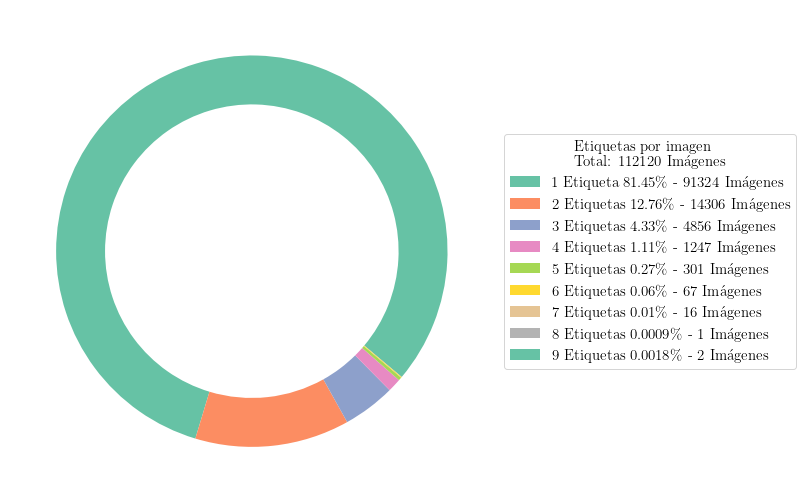

ValueError: RGBA sequence should have length 3 or 4

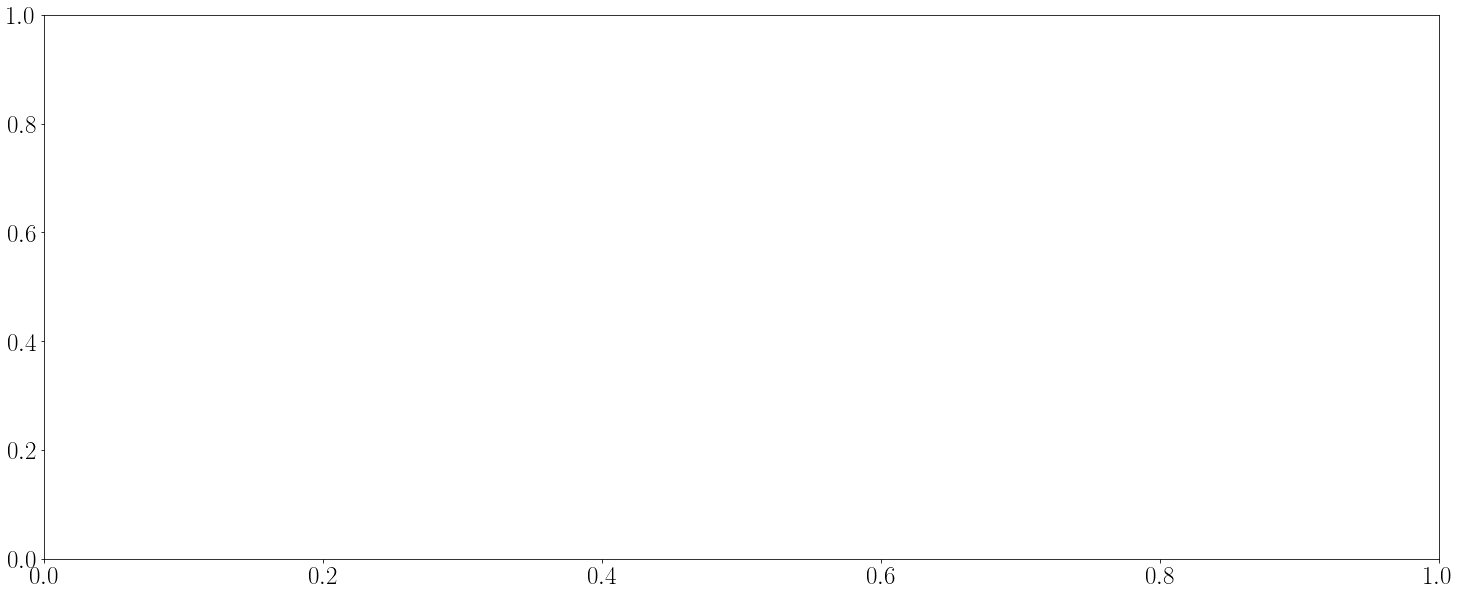

In [6]:
labels =  ['1 Etiqueta {:.2f}\% - {} Imágenes'.format(nlnorm[0]*100,nlraw[0]), '2 Etiquetas {:.2f}\% - {} Imágenes'.format(nlnorm[1]*100, nlraw[1]), '3 Etiquetas {:.2f}\% - {} Imágenes'.format(nlnorm[2]*100, nlraw[2]), '4 Etiquetas {:.2f}\% - {} Imágenes'.format(nlnorm[3]*100, nlraw[3]),
          '5 Etiquetas {:.2f}\% - {} Imágenes'.format(nlnorm[4]*100,nlraw[4]), '6 Etiquetas {:.2f}\% - {} Imágenes'.format(nlnorm[5]*100, nlraw[5]), '7 Etiquetas {:.2f}\% - {} Imágenes'.format(nlnorm[6]*100,nlraw[6]), '8 Etiquetas {:.4f}\% - {} Imágenes'.format(nlnorm[7]*100,nlraw[7]), '9 Etiquetas {:.4f}\% - {} Imágenes'.format(nlnorm[8]*100,nlraw[8])]
data =  nlraw.copy()
title = "   Etiquetas por imagen \n Total: {} Imágenes".format(sum(data))
print('Las de 1 etiqueta incluye también las de "sin hallazgo"')
donutPlot(data,labels,title,fontset=15)

# labels = ['1 Etiqueta {:.2f}% \n  {} Imágenes'.format(nlnorm[0]*100,nlraw[0]), '2 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[1]*100, nlraw[1]), '3 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[2]*100, nlraw[2]), '4 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[3]*100, nlraw[3]),
# '5 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[4]*100,nlraw[4]), '6 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[5]*100, nlraw[5]), '7 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[6]*100,nlraw[6]), '8 Etiquetas {:.4f}% \n {} Imágenes'.format(nlnorm[7]*100,nlraw[7]), '9 Etiquetas {:.4f}% \n {} Imágenes'.format(nlnorm[8]*100,nlraw[8])]
labels  = ['{} Etiqueta'.format(i+1) if i+1 == 1 else '{} Etiquetas'.format(i+1) for i in range(9)]
data = {'Padecimientos':nlraw.copy()}
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Imágenes\n{:.4f}\%',[n*100 for n in nlnorm]],fsizes = {'axes':35,'xtick':25, 'ytick':25}, axisLim = {'xlim':[-0.5,8.5], 'ylim':[0,98500]},axislabels=['No. de Etiquetas','No. de Imágenes']) #, png = '../Figures/ChestX-ray8/Images/ExM', pdf = '../Figures/ChestX-ray8/PDFs/ExM')

In [5]:
cLabs = [len(ind.split('|')) for ind in c14['Finding Labels']]
q  = len(labsmap)
print('Para el conjunto de datos total con todas las etiquetas, incluso los casos "Sin Hallazgo" \n')

print('La cardinalidad de las etiquetas en el conjunto es: ', LabelCardinality(cLabs))
print('La densidad de las etiquetas en el conjunto es: ', LabelDensity(cLabs, q))
print('El número de conjuntos de etiquetas distintos es:', len(c14['Finding Labels'].unique()))

Para el conjunto de datos total con todas las etiquetas, incluso los casos "Sin Hallazgo" 

La cardinalidad de las etiquetas en el conjunto es:  1.2623706742775598
La densidad de las etiquetas en el conjunto es:  0.08415804495183729
El número de conjuntos de etiquetas distintos es: 836


El número de imágenes sin hallazgo es:  60361 El artículo menciona: 60,412
El número de imágenes con hallazgos:  51759  El artículo menciona: 51,708

El número de padecimientos etiquetados:  81176


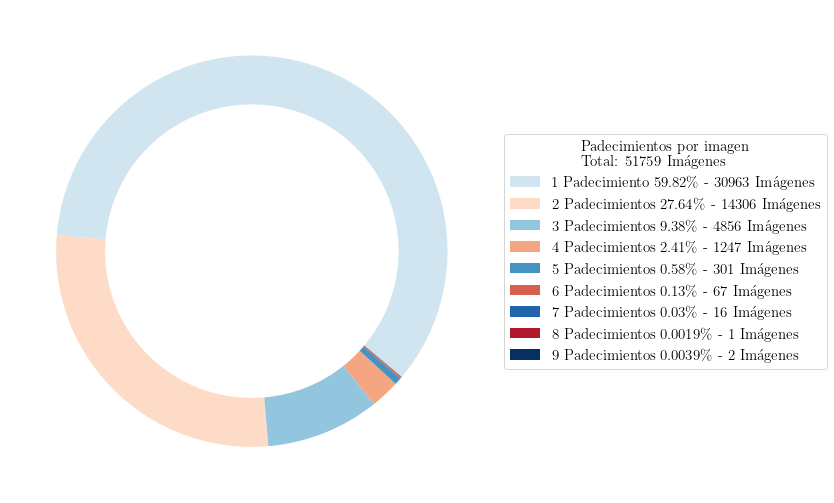

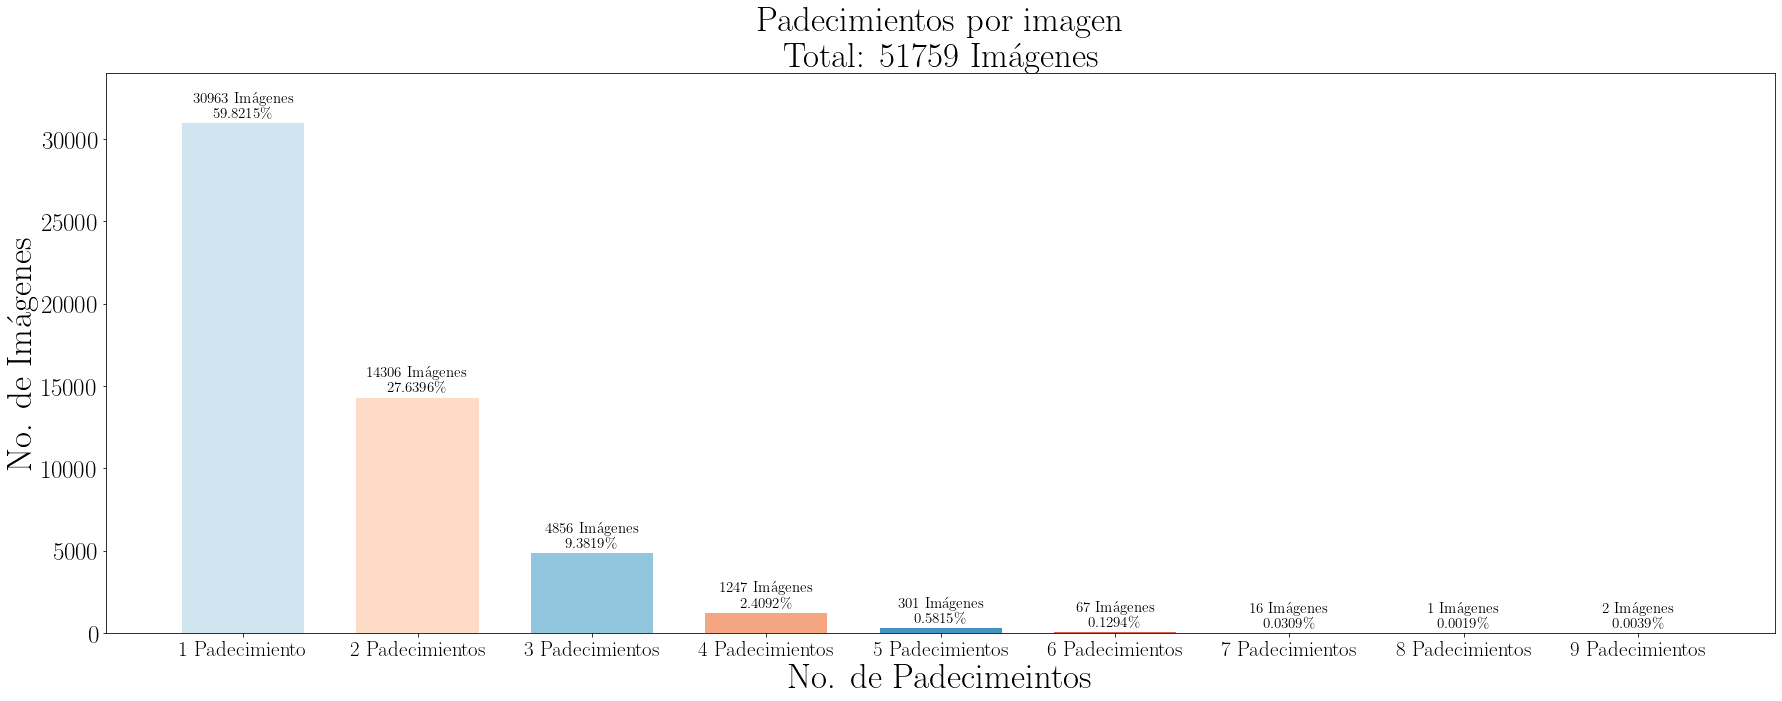

In [6]:
# Numero de imagenes sin padecimeinto encontrado
lnf = c14.pivot_table(index=['Finding Labels'], aggfunc='size')
base = lnf.index.get_loc('No Finding')
print('El número de imágenes sin hallazgo es: ',lnf[base], 'El artículo menciona: 60,412')

# Verificar que no haya mas de un tipo de padecimiento que pretenda 
# indicar que no hay hallazgo de padecimientos
# c = 0
# for i in lnf.index.values.tolist():
#     if 'Fin' in i or 'No ' in i:
#         c += 1
# c

data =  nlraw.copy()
data[0] = data[0] - lnf[base]
nlnorm = [float(i)/sum(data) for i in data]
labels = ['1 Padecimiento {:.2f}\% -  {} Imágenes'.format(nlnorm[0]*100,nlraw[0] - lnf[base]), '2 Padecimientos {:.2f}\% - {} Imágenes'.format(nlnorm[1]*100, nlraw[1]), '3 Padecimientos {:.2f}\% - {} Imágenes'.format(nlnorm[2]*100, nlraw[2]), '4 Padecimientos {:.2f}\% - {} Imágenes'.format(nlnorm[3]*100, nlraw[3]),
'5 Padecimientos {:.2f}\% - {} Imágenes'.format(nlnorm[4]*100,nlraw[4]), '6 Padecimientos {:.2f}\% - {} Imágenes'.format(nlnorm[5]*100, nlraw[5]), '7 Padecimientos {:.2f}\% - {} Imágenes'.format(nlnorm[6]*100,nlraw[6]), '8 Padecimientos {:.4f}\% - {} Imágenes'.format(nlnorm[7]*100,nlraw[7]), '9 Padecimientos {:.4f}\% - {} Imágenes'.format(nlnorm[8]*100,nlraw[8])]
title = "Padecimientos por imagen \n   Total: {} Imágenes". format(sum(data))
print('El número de imágenes con hallazgos: ',sum(data), ' El artículo menciona: 51,708')
print('\nEl número de padecimientos etiquetados: ',sum(TE)-lnf[base])
donutPlot(data,labels,title,fontset=15)

# labels = ['1 Padecimiento {:.2f}% \n  {} Imágenes'.format(nlnorm[0]*100,nlraw[0] - lnf[base]), '2 Padecimientos {:.2f}% \n {} Imágenes'.format(nlnorm[1]*100, nlraw[1]), '3 Padecimientos {:.2f}% \n {} Imágenes'.format(nlnorm[2]*100, nlraw[2]), '4 Padecimientos {:.2f}% \n {} Imágenes'.format(nlnorm[3]*100, nlraw[3]),
# '5 Padecimientos {:.2f}% \n {} Imágenes'.format(nlnorm[4]*100,nlraw[4]), '6 Padecimientos {:.2f}% \n {} Imágenes'.format(nlnorm[5]*100, nlraw[5]), '7 Padecimientos {:.2f}% \n {} Imágenes'.format(nlnorm[6]*100,nlraw[6]), '8 Padecimientos {:.4f}% \n {} Imágenes'.format(nlnorm[7]*100,nlraw[7]), '9 Padecimientos {:.4f}% \n {} Imágenes'.format(nlnorm[8]*100,nlraw[8])]
labels  = ['{} Padecimiento'.format(i+1) if i+1 == 1 else '{} Padecimientos'.format(i+1) for i in range(9)]
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title, width= 0.7, legend = False,figsize=(25,10), barLabel=['{} Imágenes\n{:.4f}\%',[n*100 for n in nlnorm]],fsizes = {'axes':35,'xtick':21, 'ytick':25}, axisLim = {'ylim':[0,34000]},axislabels=['No. de Padecimeintos','No. de Imágenes']) #, png = '../Figures/ChestX-ray8/Images/PxM', pdf = '../Figures/ChestX-ray8/PDFs/PxM')

In [7]:
cLabs = [len(ind.split('|'))  for ind in c14['Finding Labels'] if 'No Finding' not in ind.split('|')]
q  = len(labsmap) - 1
print('Para el conjunto de datos total SIN los casos "Sin Hallazgo" \n')

print('La cardinalidad de las etiquetas en el conjunto es: ', LabelCardinality(cLabs))
print('La densidad de las etiquetas en el conjunto es: ', LabelDensity(cLabs, q))
print('El número de conjuntos de etiquetas distintos es:', len(c14['Finding Labels'].unique())-1)

Para el conjunto de datos total SIN los casos "Sin Hallazgo" 

La cardinalidad de las etiquetas en el conjunto es:  1.5683456017311
La densidad de las etiquetas en el conjunto es:  0.1120246858379357
El número de conjuntos de etiquetas distintos es: 835


Pacientes únicos:  30805
1      17503
2       4113
3       2100
4       1330
5        938
       ...  
87         1
74         1
83         1
75         1
184        1
Length: 103, dtype: int64


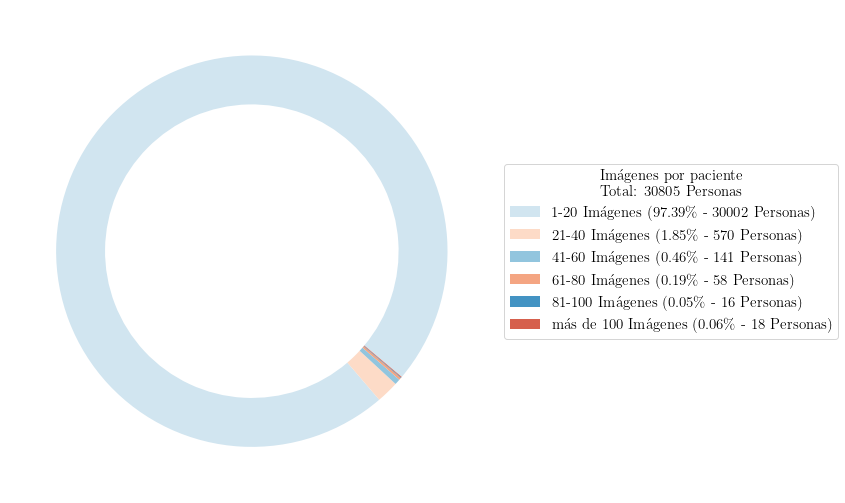

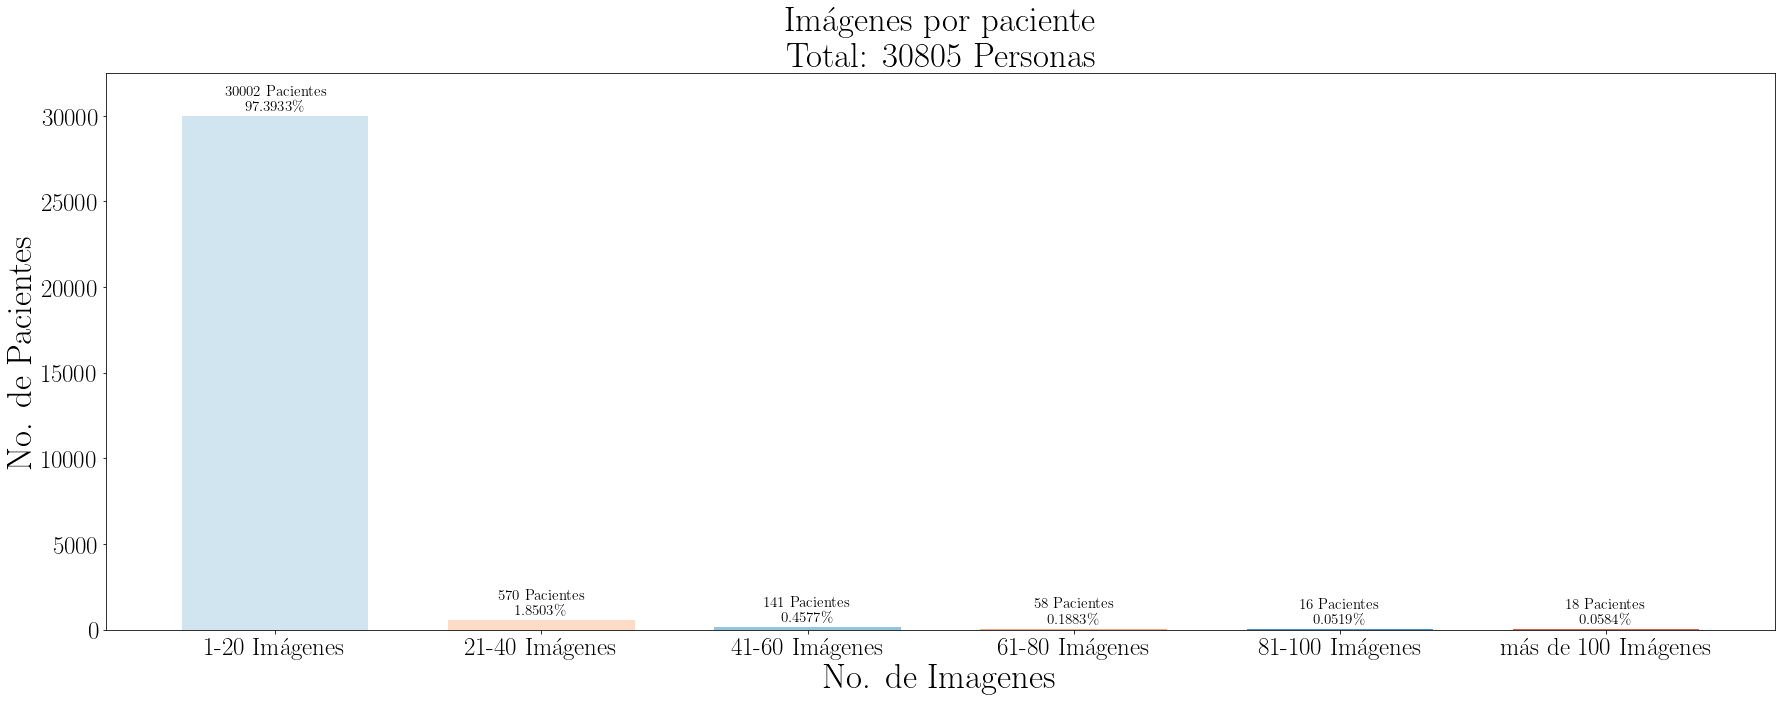

In [8]:
# Número de Pacientes Únicos
ImgIndxs = []
for i in c14['Image Index']:
  ImgIndxs.append(i[:8])
ImgIndxs = pd.Series(ImgIndxs)
# print(ImgIndxs)
UImgIndxs = ImgIndxs.value_counts()
print('Pacientes únicos: ', len(UImgIndxs))

ImgPa = UImgIndxs.value_counts()
print(ImgPa)
c = 0
c1,c2,c3,c4,c5,c6=0,0,0,0,0,0
for i in ImgPa.index:
    if 1 <= i <= 20:
        c1 += ImgPa[i]
    elif 21 <= i <= 40:
        c2 += ImgPa[i]
    elif 41 <= i <= 60:
        c3 += ImgPa[i]
    elif 61 <= i <= 80:
        c4 += ImgPa[i]
    elif 81 <= i <= 100:
        c5 += ImgPa[i]
    else:
        c6 += ImgPa[i]
    c += ImgPa[i]

data = [c1,c2,c3,c4,c5,c6]
nlnorm = [float(i)/sum(data) for i in data]
labels = ['1-20 Imágenes ({:.2f}\% - {} Personas)'.format(nlnorm[0]*100, c1), '21-40 Imágenes ({:.2f}\% - {} Personas)'.format(nlnorm[1]*100, c2), '41-60 Imágenes ({:.2f}\% - {} Personas)'.format(nlnorm[2]*100, c3),'61-80 Imágenes ({:.2f}\% - {} Personas)'.format(nlnorm[3]*100, c4), '81-100 Imágenes ({:.2f}\% - {} Personas)'.format(nlnorm[4]*100, c5), 'más de 100 Imágenes ({:.2f}\% - {} Personas)'.format(nlnorm[5]*100, c6)]
title = "Imágenes por paciente \n Total: {} Personas".format(sum(data))
donutPlot(data,labels,title, fontset = 15)

# labels = ['1-20 Imágenes \n({:.2f}% - {} Personas)'.format(nlnorm[0]*100, c1), '21-40 Imágenes \n({:.2f}% - {} Personas)'.format(nlnorm[1]*100, c2), '41-60 Imágenes \n({:.2f}% - {} Personas)'.format(nlnorm[2]*100, c3),'61-80 Imágenes \n({:.2f}% - {} Personas)'.format(nlnorm[3]*100, c4), '81-100 Imágenes \n({:.2f}% - {} Personas)'.format(nlnorm[4]*100, c5), 'más de 100 Imágenes \n({:.2f}% - {} Personas)'.format(nlnorm[5]*100, c6)]
labels  = ['{}-{} Imágenes'.format(i*20+1,(i+1)*20) for i in range(5)]
labels.append('más de 100 Imágenes')
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Pacientes\n{:.4f}\%',[n*100 for n in nlnorm]],fsizes = {'axes':35,'xtick':25, 'ytick':25}, axisLim = {'ylim':[0,32500]},axislabels=['No. de Imagenes','No. de Pacientes']) #, png = '../Figures/ChestX-ray8/Images/IxP', pdf = '../Figures/ChestX-ray8/PDFs/IxP')

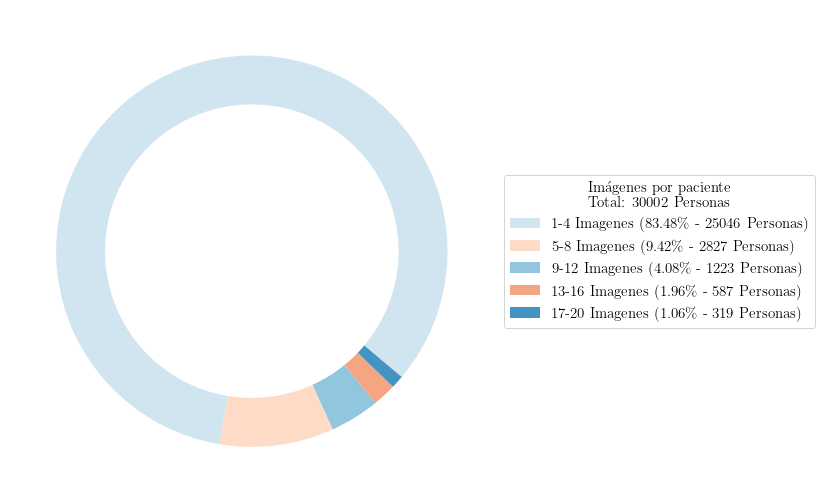

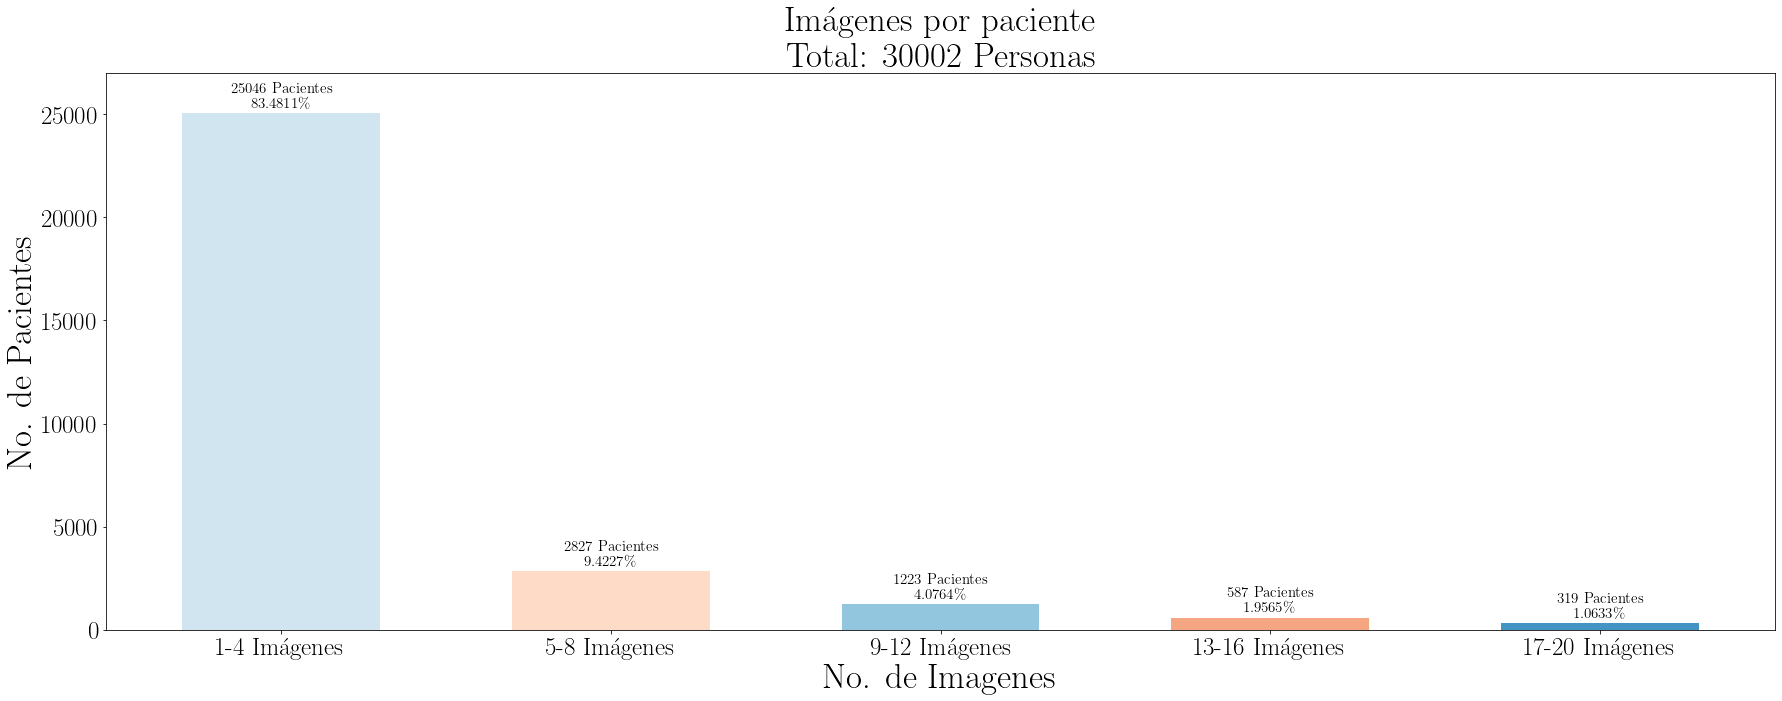

In [9]:
ImgPa = UImgIndxs.value_counts()
# print(ImgPa)

c0,c1,c2,c3,c4=0,0,0,0,0
for i in ImgPa.index:
    if 1 <= i <= 4:
        c0 += ImgPa[i]
    elif 5 <= i <= 8:
        c1 += ImgPa[i]
    elif 9 <= i <= 12:
        c2 += ImgPa[i]
    elif 13 <= i <= 16:
        c3 += ImgPa[i]
    elif 16 <= i <= 20:
        c4 += ImgPa[i]

data = [c0,c1,c2,c3,c4]

nlnorm = [float(i)/sum(data) for i in data]
labels = ['1-4 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[0]*100,c0), '5-8 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[1]*100,c1), '9-12 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[2]*100,c2),'13-16 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[3]*100,c3), '17-20 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[4]*100,c4)]
title = "Imágenes por paciente \n Total: {} Personas".format(sum(data))
donutPlot(data,labels,title, fontset = 15)

# labels = ['1-4 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[0]*100, c0), '5-8 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[1]*100, c1), '9-12 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[2]*100, c2),'13-16 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[3]*100, c3), '17-20 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[4]*100, c4)]
labels  = ['{}-{} Imágenes'.format(i*4+1,(i+1)*4) for i in range(5)]
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title,width = 0.6, legend = False,figsize=(25,10), barLabel=['{} Pacientes\n{:.4f}\%',[n*100 for n in nlnorm]],fsizes = {'axes':35,'xtick':25, 'ytick':25}, axisLim = {'ylim':[0,27000]},axislabels=['No. de Imagenes','No. de Pacientes']) #, png = '../Figures/ChestX-ray8/Images/IxP2', pdf = '../Figures/ChestX-ray8/PDFs/IxP2')

Total de personas de sexo femenino: 14175 
Total de personas de sexo masculino: 16630


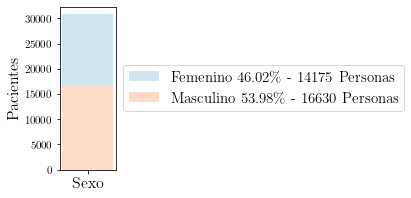

In [10]:
c14Se = c14[['Patient ID','Patient Gender']]
c14SeBG = c14Se.groupby(['Patient ID'])
SeCount = c14SeBG.first()['Patient Gender'].value_counts()
m,f = SeCount['M'], SeCount['F'],
genraw = [m,f]
gennorm = [float(i)/sum(genraw) for i in genraw]

print('Total de personas de sexo femenino:', f, '\nTotal de personas de sexo masculino:', m)

labels = ['Sexo']
width = 0.35 
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=11)

fig, ax = plt.subplots(figsize=(1, 3))

ax.bar(labels, f, width, bottom=m, label='Femenino {:.2f}\% - {} Personas'.format(gennorm[1]*100, f))
ax.bar(labels, m, width, label='Masculino {:.2f}\% - {} Personas'.format(gennorm[0]*100, m))

ax.set_ylabel('Pacientes')
# ax.set_title('Scores by group and gender')
ax.legend(loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.patch.set_alpha(0.0)

plt.savefig('../Figures/ChestX-ray8/Images/PxS.png', transparent=True, bbox_inches='tight')
plt.savefig('../Figures/ChestX-ray8/PDFs/PxS.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [11]:
c14Ed = c14[['Patient ID','Patient Age']]
c14EdBG = c14Ed.groupby(['Patient ID'])
agecount = c14EdBG.first()['Patient Age'].value_counts()

edad0,edad1,edad2,edad3,edad4,edad5,edad6,edad7,edad8,edad9 = 0,0,0,0,0,0,0,0,0,0

for i in agecount.index:
    if 0 <= i <= 10:
        edad0 += agecount[i]
    elif 11 <= i <= 20:
        edad1 += agecount[i]
    elif 21 <= i <= 30:
        edad2 += agecount[i]
    elif 31 <= i <= 40:
        edad3 += agecount[i]
    elif 41 <= i <= 50:
        edad4 += agecount[i]
    elif 51 <= i <= 60:
        edad5 += agecount[i]
    elif 61 <= i <= 70:
        edad6 += agecount[i]
    elif 71 <= i <= 80:
        edad7 += agecount[i]
    elif 81 <= i <= 90:
        edad8 += agecount[i]
    else:
        edad9 += agecount[i]

edades = [edad0,edad1,edad2,edad3,edad4,edad5,edad6,edad7,edad8,edad9]
ednorm = [float(i)/sum(edades) for i in edades]

print(' Total:', sum(edades),'\n 0 <= Edad <= 10:',edad0, '\n 11 <= Edad <= 20: ',edad1, '\n 21 <= Edad <= 30: ',edad2,
'\n 31 <= Edad <= 40: ',edad3, '\n 41 <= Edad <= 50: ',edad4,'\n 51 <= Edad <= 60: ',edad5,'\n 61 <= Edad <= 70: ',edad6,
'\n 71 <= Edad <= 80: ',edad7,'\n 81 <= Edad <= 90: ',edad8,'\n Edad > 90: ',edad9)

 Total: 30805 
 0 <= Edad <= 10: 736 
 11 <= Edad <= 20:  1590 
 21 <= Edad <= 30:  3958 
 31 <= Edad <= 40:  5038 
 41 <= Edad <= 50:  6500 
 51 <= Edad <= 60:  7001 
 61 <= Edad <= 70:  4307 
 71 <= Edad <= 80:  1440 
 81 <= Edad <= 90:  227 
 Edad > 90:  8


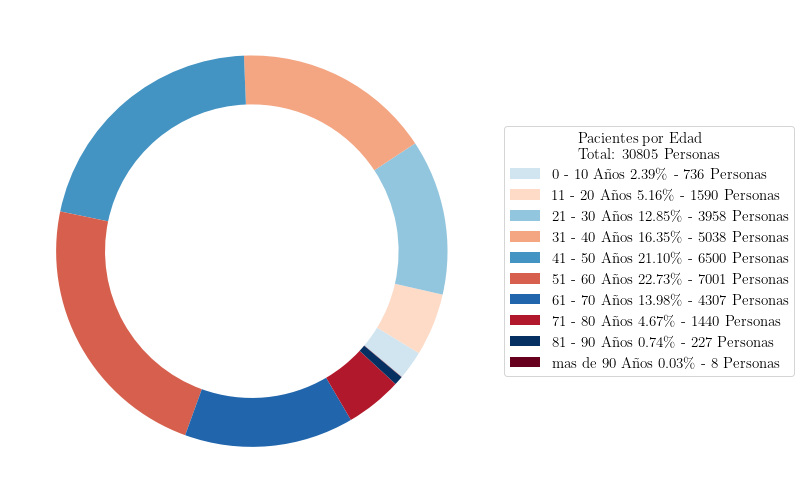

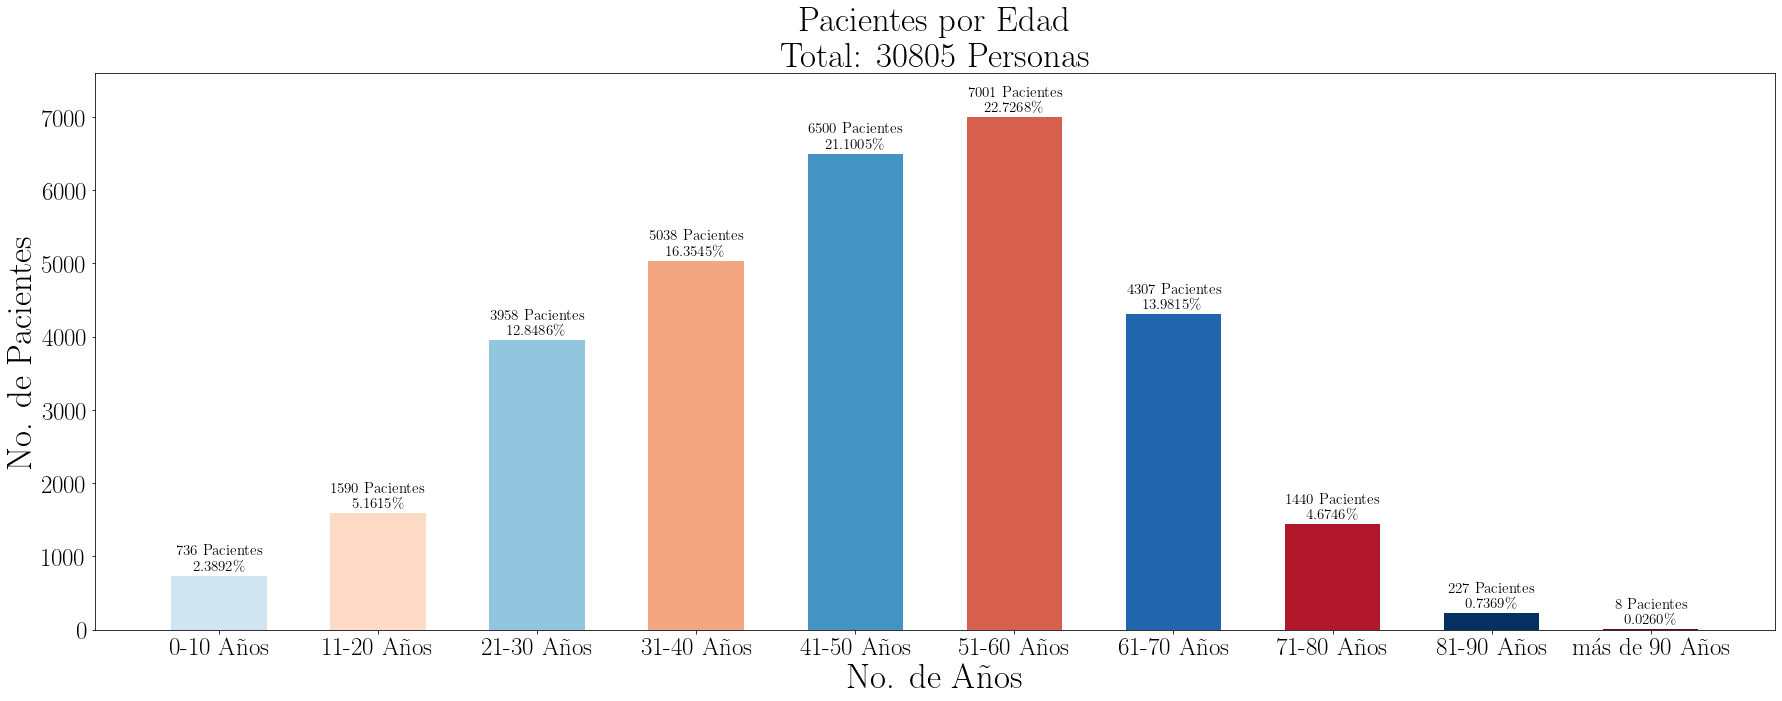

In [12]:
labels = ['0 - 10 Años {:.2f}\% - {} Personas'.format(ednorm[0]*100,edades[0]), '11 - 20 Años {:.2f}\% - {} Personas'.format(ednorm[1]*100,edades[1]), '21 - 30 Años {:.2f}\% - {} Personas'.format(ednorm[2]*100,edades[2]), '31 - 40 Años {:.2f}\% - {} Personas'.format(ednorm[3]*100,edades[3]), '41 - 50 Años {:.2f}\% - {} Personas'.format(ednorm[4]*100,edades[4]),
          '51 - 60 Años {:.2f}\% - {} Personas'.format(ednorm[5]*100,edades[5]), '61 - 70 Años {:.2f}\% - {} Personas'.format(ednorm[6]*100,edades[6]), '71 - 80 Años {:.2f}\% - {} Personas'.format(ednorm[7]*100,edades[7]), '81 - 90 Años {:.2f}\% - {} Personas'.format(ednorm[8]*100,edades[8]), 'mas de 90 Años {:.2f}\% - {} Personas'.format(ednorm[9]*100,edades[9])]

data = edades.copy()
title = "     Pacientes por Edad\n Total: {} Personas".format(sum(data))
donutPlot(data,labels,title, fontset = 15)

# labels = ['0 - 10 Años \n{:.2f}% - {} Personas'.format(ednorm[0]*100,edades[0]), '11 - 20 Años \n{:.2f}% - {} Personas'.format(ednorm[1]*100,edades[1]), '21 - 30 Años \n{:.2f}% - {} Personas'.format(ednorm[2]*100,edades[2]), '31 - 40 Años \n{:.2f}% - {} Personas'.format(ednorm[3]*100,edades[3]), '41 - 50 Años \n{:.2f}% - {} Personas'.format(ednorm[4]*100,edades[4]),
#           '51 - 60 Años \n{:.2f}% - {} Personas'.format(ednorm[5]*100,edades[5]), '61 - 70 Años \n{:.2f}% - {} Personas'.format(ednorm[6]*100,edades[6]), '71 - 80 Años \n{:.2f}% - {} Personas'.format(ednorm[7]*100,edades[7]), '81 - 90 Años \n{:.2f}% - {} Personas'.format(ednorm[8]*100,edades[8]), 'mas de 90 Años \n{:.2f}% - {} Personas'.format(ednorm[9]*100,edades[9])]
labels  = ['{}-{} Años'.format(i*10,(i+1)*10) if i == 0 else '{}-{} Años'.format(i*10+1,(i+1)*10) for i in range(9)]
labels.append('más de 90 Años')
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title, width = 0.6, legend = False,figsize=(25,10), barLabel=['{} Pacientes\n{:.4f}\%',[n*100 for n in ednorm]],fsizes = {'axes':35,'xtick':25, 'ytick':25}, axisLim = {'ylim':[0,7600]},axislabels=['No. de Años','No. de Pacientes']) #, png = '../Figures/ChestX-ray8/Images/PxE', pdf = '../Figures/ChestX-ray8/PDFs/PxE')

Gráficas generadas unicamente con la primera aparicion del paciente, a una edad especifica. 
Es decir un registro por paciente, de los 30805 pacientes únicos


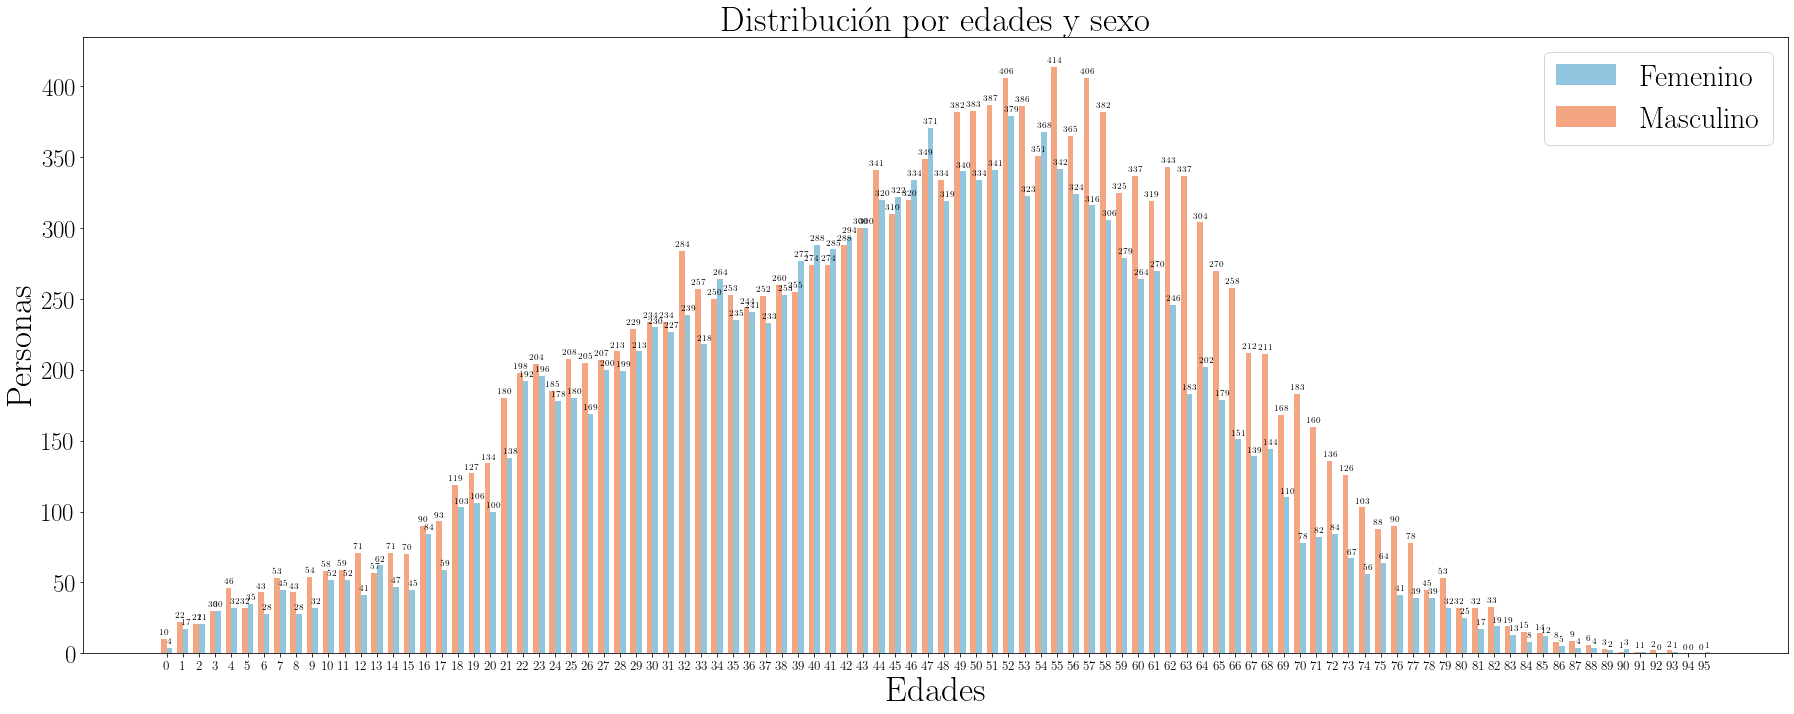

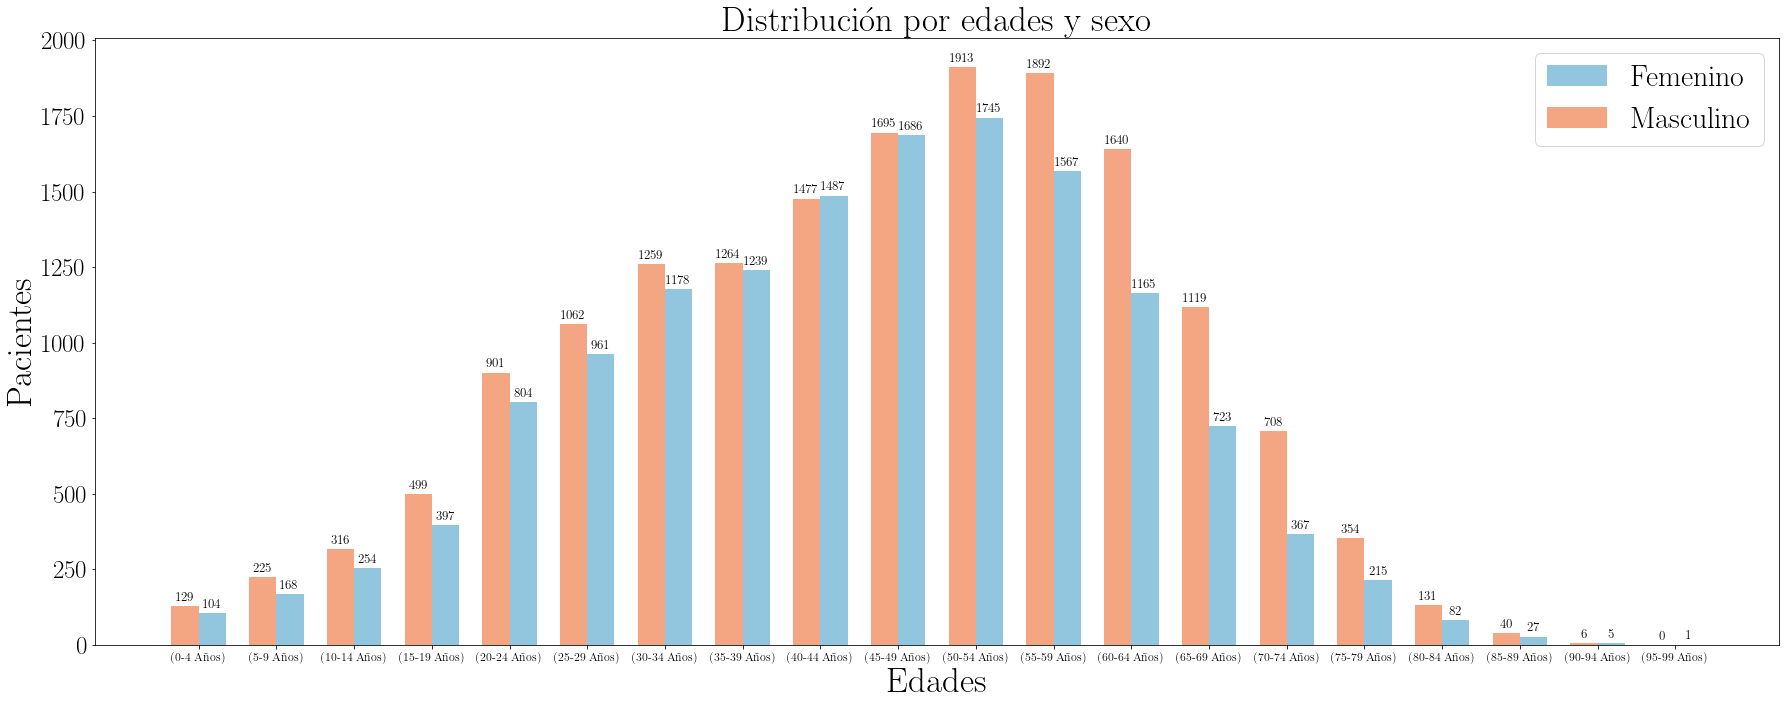

In [13]:
c14EdSe = c14[['Patient Age', 'Patient Gender', 'Patient ID']]
c14EdSeBG = c14EdSe.groupby(['Patient ID'])
EdSeCount = c14EdSeBG.first()
men = np.zeros([len(c14EdSe['Patient Age'].unique())])
women = np.zeros([len(c14EdSe['Patient Age'].unique())])
men5s = np.zeros([20])
women5s = np.zeros([20])

for i in EdSeCount.index:
#     print(i,'  ',EdSeCount.loc[i]['Patient Gender'],'   ', EdSeCount.loc[i]['Patient Age'])
    if EdSeCount.loc[i]['Patient Gender'] == 'M':
        men[EdSeCount.loc[i]['Patient Age']] += 1
    elif EdSeCount.loc[i]['Patient Gender'] == 'F':
        women[EdSeCount.loc[i]['Patient Age']] += 1
    else:
        print('Genero de usuario {}, no identificado.'.format(i))
        
print('Gráficas generadas unicamente con la primera aparicion del paciente, a una edad especifica. \nEs decir un registro por paciente, de los {} pacientes únicos'.format(int(sum(men)+sum(women))))        
xticks = sort(c14EdSe['Patient Age'].unique())
data = {'Femenino':women,
        'Masculino':men}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Personas'], fsizes = {'font':9,'axes':35,'xtick':13, 'ytick':25})

labels = []
for i in range(20):
    men5s[i] = sum(men[i*5:i*5+5])
    women5s[i] = sum(women[i*5:i*5+5])
    labels.append('({}-{} Años)'.format(i*5,i*5+4))
xticks = labels
data = {'Femenino':women5s,
        'Masculino':men5s}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Pacientes'], fsizes = {'font':13,'axes':35,'xtick':12, 'ytick':25}) #, png = '../Figures/ChestX-ray8/Images/PxES', pdf = '../Figures/ChestX-ray8/PDFs/PxES')

Gráficas con todos los registros de todos los pacientes, es decir el total de imagenes de Rayos-X, que es de: 112120 imágenes.


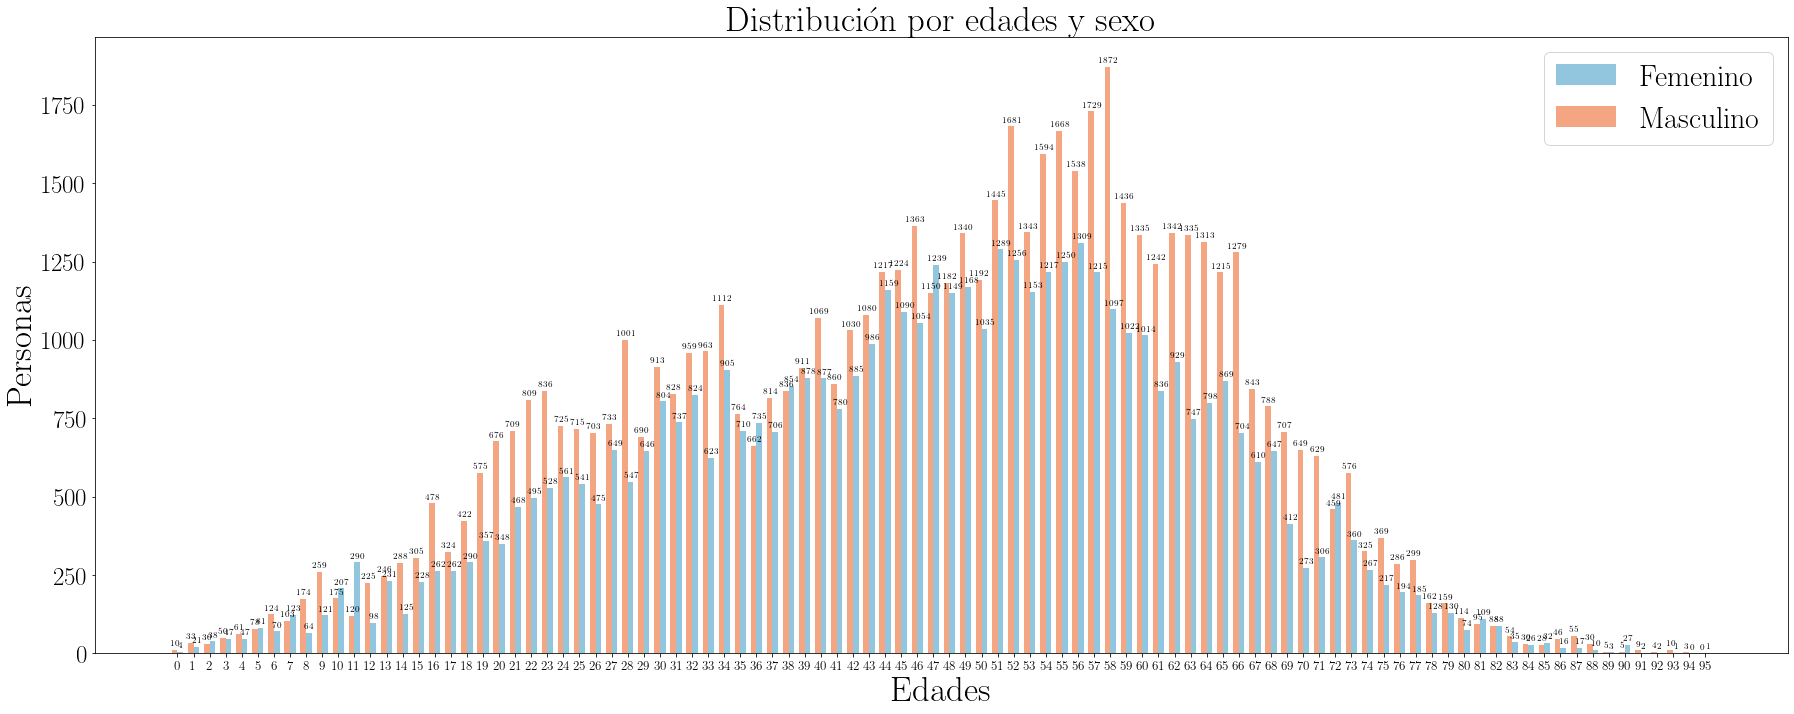

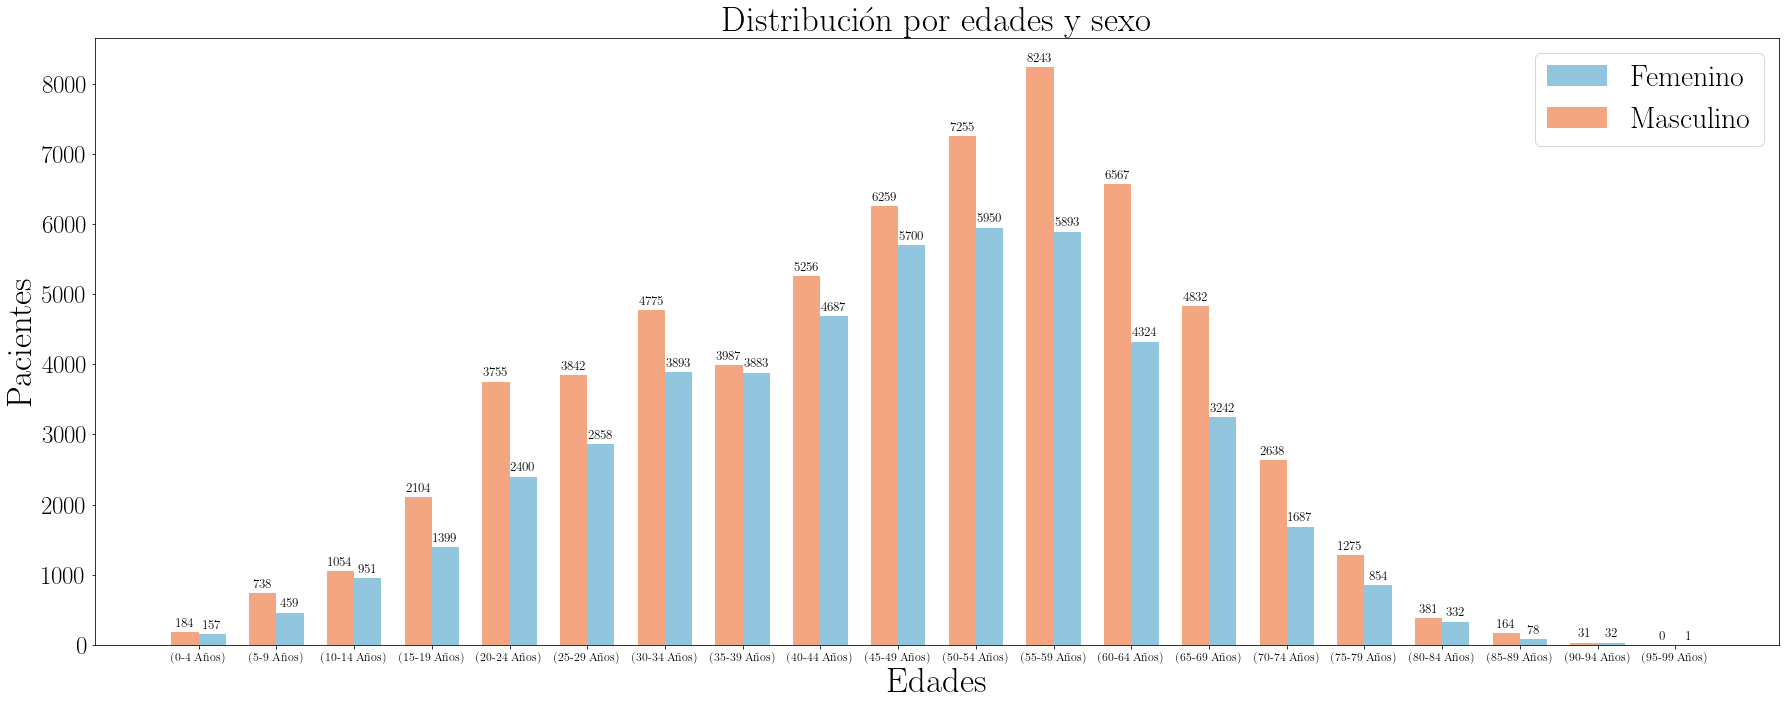

In [14]:
c14EdSe = c14[['Patient Age', 'Patient Gender', 'Patient ID']]
men = np.zeros([len(c14EdSe['Patient Age'].unique())])
women = np.zeros([len(c14EdSe['Patient Age'].unique())])
men5s = np.zeros([20])
women5s = np.zeros([20])

for i in c14EdSe.index:
#     print(i,'  ',EdSeCount.loc[i]['Patient Gender'],'   ', EdSeCount.loc[i]['Patient Age'])
    if c14EdSe.iloc[i]['Patient Gender'] == 'M':
        men[c14EdSe.iloc[i]['Patient Age']] += 1
    elif c14EdSe.iloc[i]['Patient Gender'] == 'F':
        women[c14EdSe.iloc[i]['Patient Age']] += 1
    else:
        print('Genero de usuario {}, no identificado.'.format(i))
        
print('Gráficas con todos los registros de todos los pacientes, es decir el total de imagenes de Rayos-X, que es de: {} imágenes.'.format(int(sum(men)+sum(women))))        
xticks = sort(c14EdSe['Patient Age'].unique())
data = {'Femenino':women,
        'Masculino':men}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Personas'], fsizes = {'font':9,'axes':35,'xtick':13, 'ytick':25})

labels = []
for i in range(20):
    men5s[i] = sum(men[i*5:i*5+5])
    women5s[i] = sum(women[i*5:i*5+5])
    labels.append('({}-{} Años)'.format(i*5,i*5+4))
xticks = labels
data = {'Femenino':women5s,
        'Masculino':men5s}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Pacientes'],fsizes = {'font':13,'axes':35,'xtick':12, 'ytick':25}) #, png = '../Figures/ChestX-ray8/Images/PxES2', pdf = '../Figures/ChestX-ray8/PDFs/PxES2')

Gráficas generadas con cada primer aparición de cada diferente edad de cada paciente. 
Es decir si un paciente tiene registros a diferentes edades, la primera a cada diferente edad se registra. 
Con esto se obtienen 44787 registros


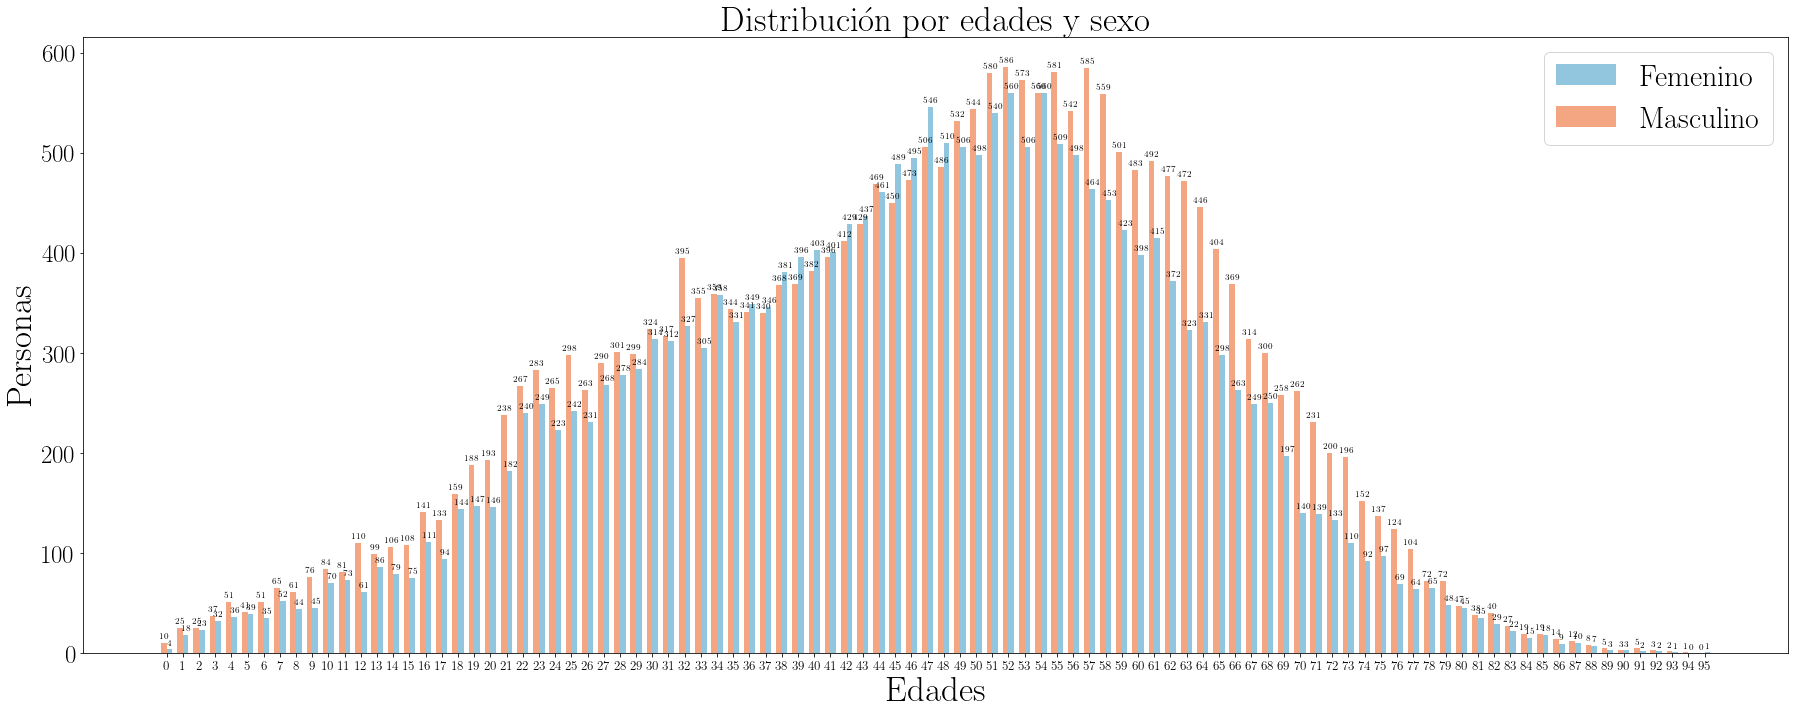

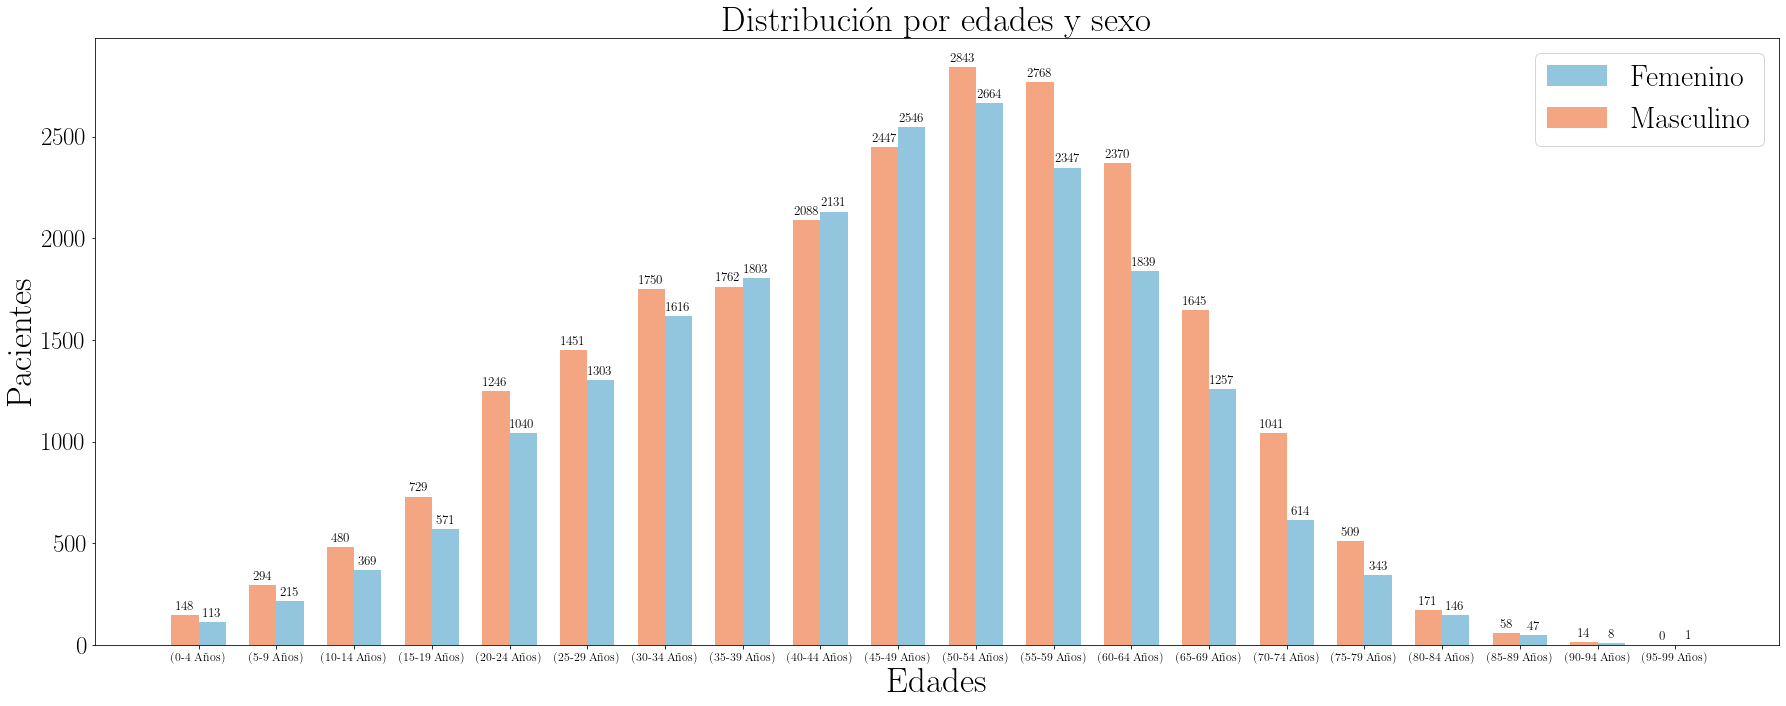

In [15]:
c14EdSe = c14[['Patient Age', 'Patient Gender', 'Patient ID']]
c14EdSeBG = c14EdSe.groupby(['Patient Age', 'Patient Gender', 'Patient ID'])
EdSeCount = c14EdSeBG.first()#['Patient Gender']
# agecount = c14EdBG.first()['Patient Age'].value_counts()
EdSeCount = EdSeCount.reset_index()
men = np.zeros([len(EdSeCount['Patient Age'].unique())])
women = np.zeros([len(EdSeCount['Patient Age'].unique())])
men5s = np.zeros([20])
women5s = np.zeros([20])

for i in EdSeCount['Patient Age'].unique():
    try:
        men[i] = EdSeCount[EdSeCount['Patient Age'] == i][['Patient Gender']].value_counts()['M'] 
    except:
        pass
    try: 
        women[i] = EdSeCount[EdSeCount['Patient Age'] == i][['Patient Gender']].value_counts()['F']
    except:
        pass
 
print('Gráficas generadas con cada primer aparición de cada diferente edad de cada paciente. \nEs decir si un paciente tiene registros a diferentes edades, la primera a cada diferente edad se registra. \nCon esto se obtienen {} registros'.format(int(sum(men)+sum(women))))        
xticks = EdSeCount['Patient Age'].unique()
data = {'Femenino':women,
        'Masculino':men}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Personas'],fsizes = {'font':9,'axes':35,'xtick':13, 'ytick':25})

labels = []
for i in range(20):
    men5s[i] = sum(men[i*5:i*5+5])
    women5s[i] = sum(women[i*5:i*5+5])
    labels.append('({}-{} Años)'.format(i*5,i*5+4))
xticks = labels
data = {'Femenino':women5s,
        'Masculino':men5s}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Pacientes'],fsizes = {'font':13,'axes':35,'xtick':12, 'ytick':25}) #, png = '../Figures/ChestX-ray8/Images/PxES3', pdf = '../Figures/ChestX-ray8/PDFs/PxES3')

In [16]:
Cardiomegaly = c14[c14['Finding Labels'].str.contains("Cardiomegaly")]
Emphysema = c14[c14['Finding Labels'].str.contains("Emphysema")]
Effusion = c14[c14['Finding Labels'].str.contains("Effusion")]
Hernia = c14[c14['Finding Labels'].str.contains("Hernia")]
Infiltration = c14[c14['Finding Labels'].str.contains("Infiltration")]
Mass = c14[c14['Finding Labels'].str.contains("Mass")]
Nodule = c14[c14['Finding Labels'].str.contains("Nodule")]
Atelectasis = c14[c14['Finding Labels'].str.contains("Atelectasis")]
Pneumothorax = c14[c14['Finding Labels'].str.contains("Pneumothorax")]
Pleural_Thickening = c14[c14['Finding Labels'].str.contains("Pleural_Thickening")]
Fibrosis = c14[c14['Finding Labels'].str.contains("Fibrosis")]
Edema = c14[c14['Finding Labels'].str.contains("Edema")]
Consolidation = c14[c14['Finding Labels'].str.contains("Consolidation")]
Pneumonia = c14[c14['Finding Labels'].str.contains("Pneumonia")]
No_Finding = c14[c14['Finding Labels'].str.contains("No Finding")]

pads = {'Cardiomegalia': len(Cardiomegaly),
        'Enfisema':len(Emphysema),
        'Derrame pleural':len(Effusion),
        'Hernia':len(Hernia),
        'Infiltración':len(Infiltration),
        'Masa':len(Mass),
        'Nódulo':len(Nodule), 
        'Atelectasia':len(Atelectasis), 
        'Neumotórax':len(Pneumothorax), 
        'Engrosamiento pleural':len(Pleural_Thickening),
        'Fibrosis':len(Fibrosis), 
        'Edema':len(Edema), 
        'Consolidación':len(Consolidation), 
        'Neumonía':len(Pneumonia),
        'Sin Hallazgo':len(No_Finding)}
 
pads = {k: v for k, v in sorted(pads.items(), key=lambda item: item[1])}

raw = list(pads.values())
norm = [float(i)/sum(raw) for i in raw]
labs = list(pads.keys())

print('\n {}:'.format(labs[0]), raw[0], ' - ', norm[0]* 100, '%',
'\n {}:'.format(labs[1]),raw[1], ' - ', norm[1]* 100, '%',
'\n {}:'.format(labs[2]),raw[2], ' - ', norm[2]* 100, '%',
'\n {}:'.format(labs[3]),raw[3], ' - ', norm[3]* 100, '%',
'\n {}:'.format(labs[4]),raw[4], ' - ', norm[4]* 100, '%',
'\n {}:'.format(labs[5]),raw[5], ' - ', norm[5]* 100, '%',
'\n {}:'.format(labs[6]),raw[6], ' - ', norm[6]* 100, '%',
'\n {}:'.format(labs[7]),raw[7], ' - ', norm[7]* 100, '%',
'\n {}:'.format(labs[8]),raw[8], ' - ', norm[8]* 100, '%',
'\n {}:'.format(labs[9]),raw[9], ' - ', norm[9]* 100, '%',
'\n {}:'.format(labs[10]),raw[10], ' - ', norm[10]* 100, '%',
'\n {}:'.format(labs[11]),raw[11], ' - ', norm[11]* 100, '%',
'\n {}:'.format(labs[12]),raw[12], ' - ', norm[12]* 100, '%',
'\n {}:'.format(labs[13]),raw[13], ' - ', norm[13]* 100, '%',
'\n {}:'.format(labs[14]),raw[14], ' - ', norm[14]* 100, '%',
'\n Total:', sum(raw), ' - ', sum(norm)* 100, '%',
 )


 Hernia: 227  -  0.16038209090202563 % 
 Neumonía: 1431  -  1.011043048814091 % 
 Fibrosis: 1686  -  1.191207952690816 % 
 Edema: 2303  -  1.627136367169009 % 
 Enfisema: 2516  -  1.777627051583685 % 
 Cardiomegalia: 2776  -  1.9613246006344631 % 
 Engrosamiento pleural: 3385  -  2.3916007828341708 % 
 Consolidación: 4667  -  3.297371005461469 % 
 Neumotórax: 5302  -  3.746016942566255 % 
 Masa: 5782  -  4.085150879275384 % 
 Nódulo: 6331  -  4.47303531938645 % 
 Atelectasia: 11559  -  8.166769113376713 % 
 Derrame pleural: 13317  -  9.408847156573898 % 
 Infiltración: 19894  -  14.05568861852378 % 
 Sin Hallazgo: 60361  -  42.64679907020779 % 
 Total: 141537  -  100.0 %


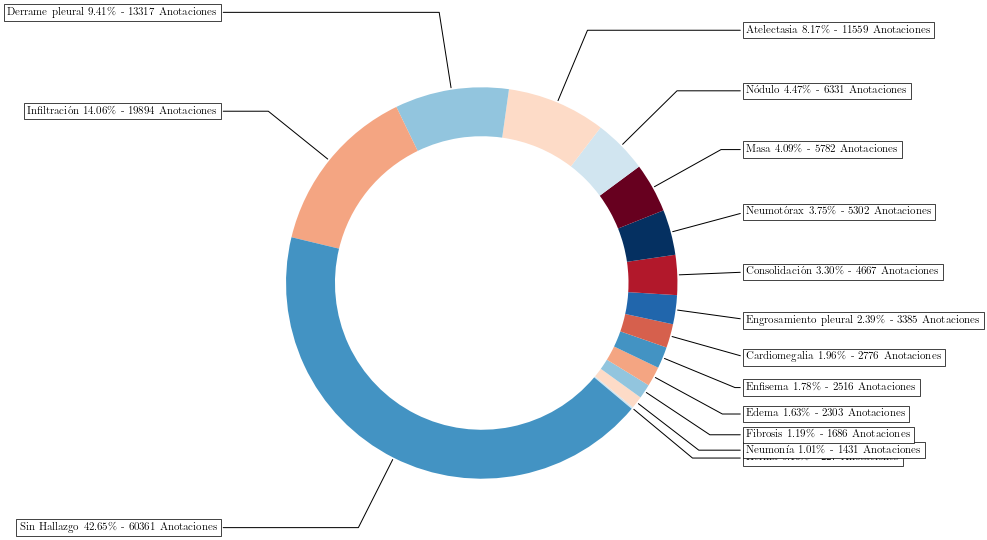

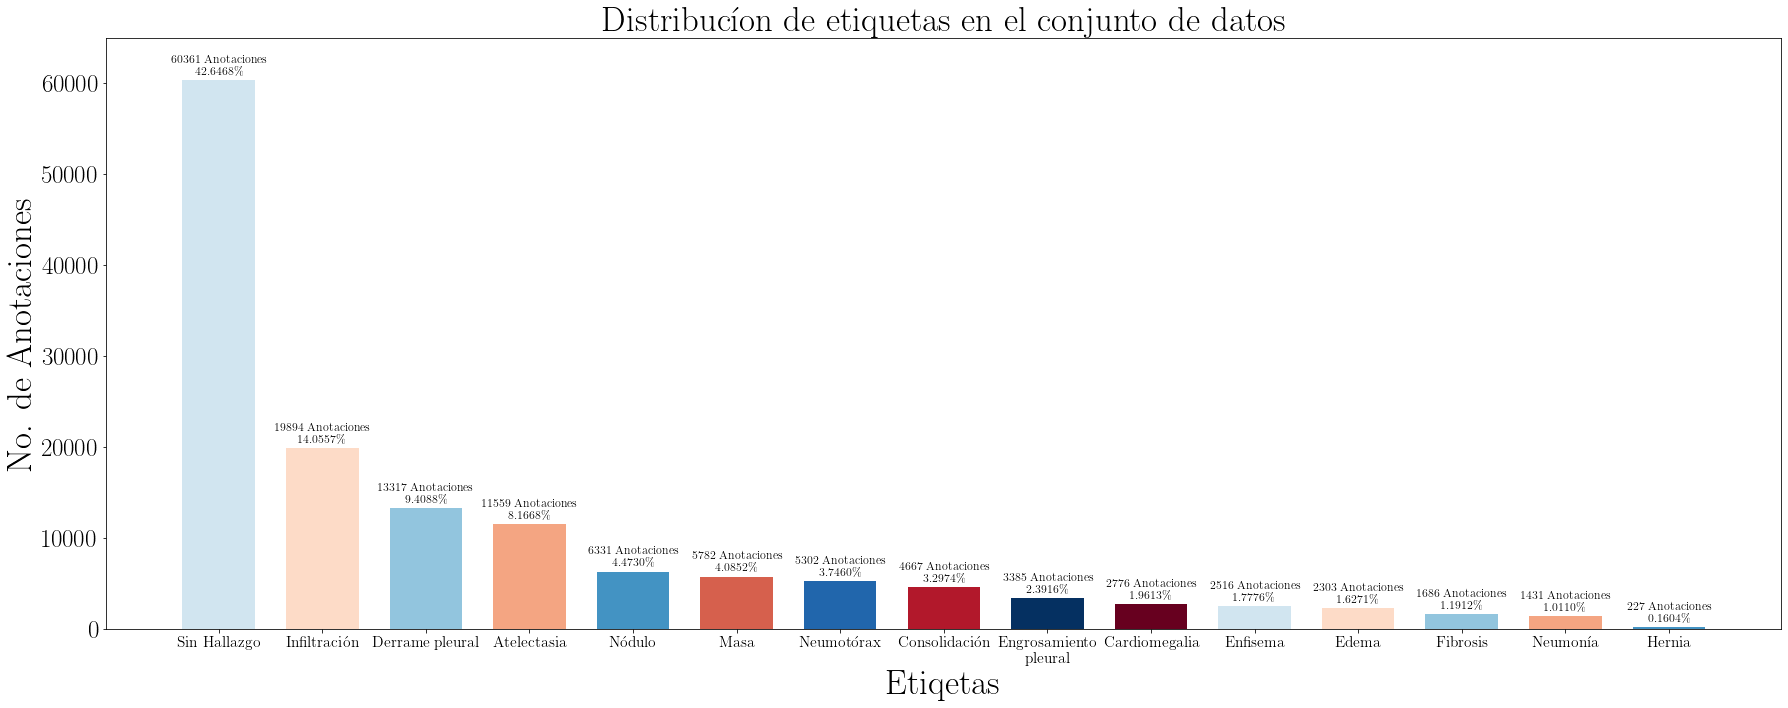

In [17]:
labels = ['{} {:.2f}\% - {} Anotaciones'.format(labs[i],norm[i]* 100,raw[i]) for i in range(len(labs))]
data = raw.copy()
donutPlot(data, labels,legend=False, fontset = 11)

data = {'Padecimientos':data.copy()[::-1]}
# labels = ['{} {:.2f}% \n {} Anotaciones'.format(labs[i],norm[i]* 100,raw[i]) if labs[i] != 'Engrosamiento pleural' else '{} \n {} {:.2f}% \n {} Anotaciones'.format(labs[i].split()[0],labs[i].split()[1],norm[i]* 100,raw[i])  for i in range(len(labs))]
# labels = labels[::-1]
labels = ['{}'.format(labs[i]) if labs[i] != 'Engrosamiento pleural' else '{} \n {}'.format(labs[i].split()[0],labs[i].split()[1])  for i in range(len(labs))]
labels = labels[::-1]
title = 'Distribucíon de etiquetas en el conjunto de datos'
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Anotaciones\n{:.4f}\%',[n*100 for n in norm][::-1]], fsizes = {'font':12,'axes':35,'xtick':15.5, 'ytick':25}, axisLim = {'ylim':[0,65000]},axislabels=['Etiqetas','No. de Anotaciones']) #, png = '../Figures/ChestX-ray8/Images/DE', pdf = '../Figures/ChestX-ray8/PDFs/DE')

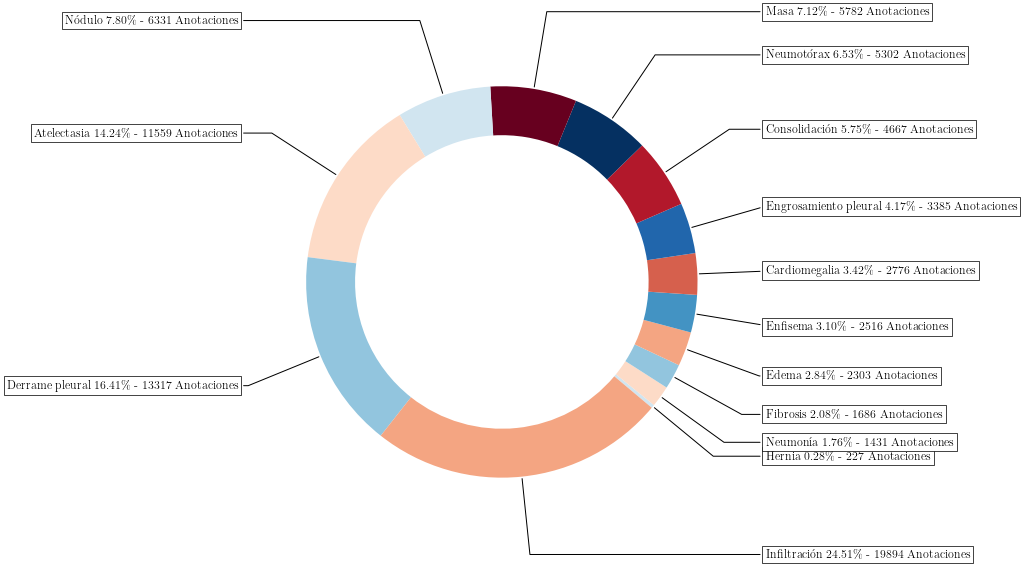

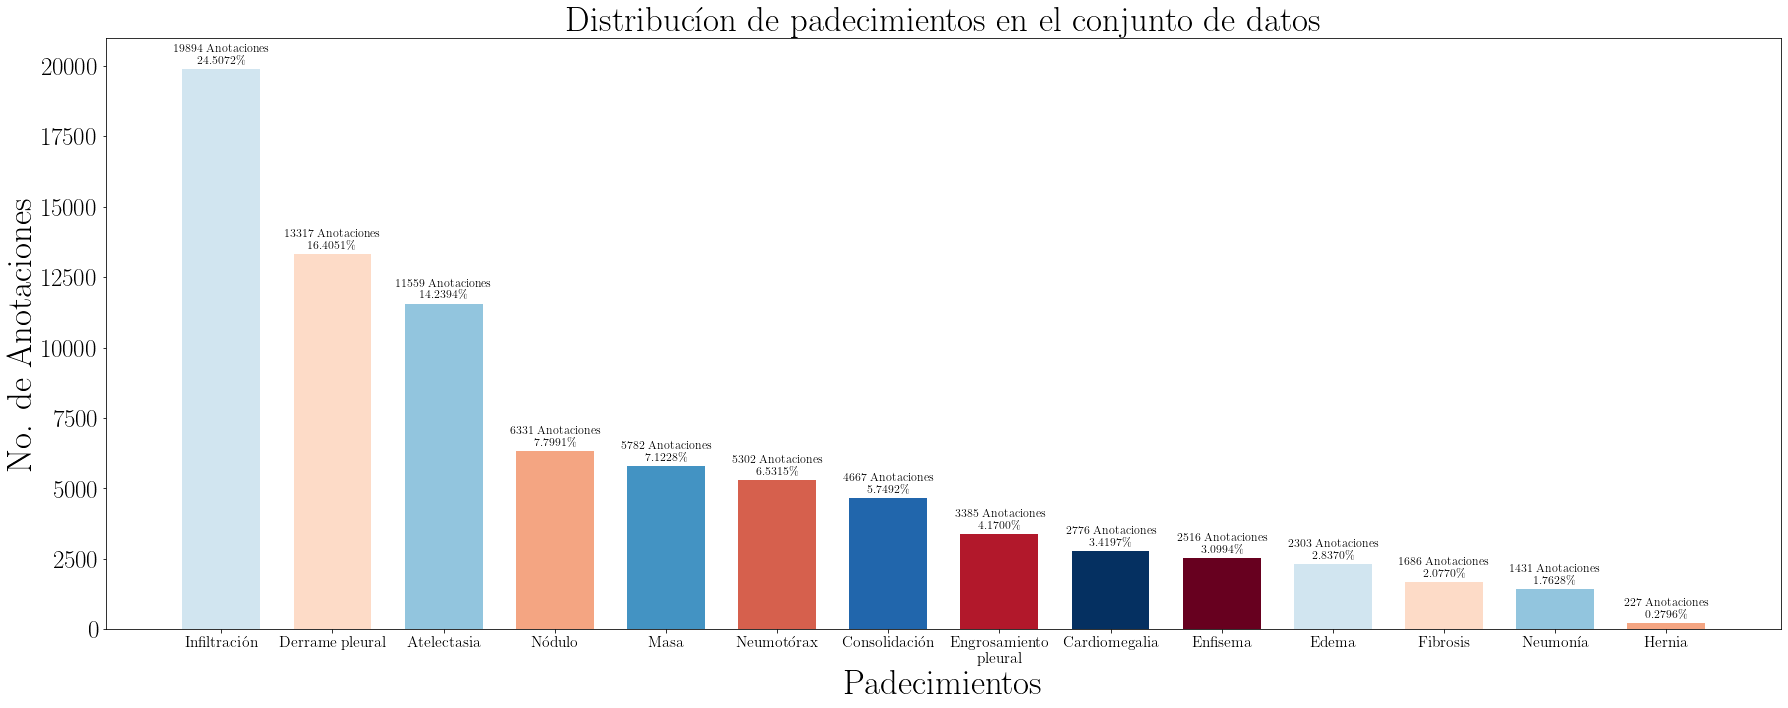

In [18]:
raw = list(pads.values())[:-1]
norm = [float(i)/sum(raw) for i in raw]
labs = list(pads.keys())[:-1]

labels = ['{} {:.2f}\% - {} Anotaciones'.format(labs[i],norm[i]* 100,raw[i]) for i in range(len(labs))]
data = raw.copy()
donutPlot(data, labels,legend=False, fontset = 12)

data = {'Padecimientos':data.copy()[::-1]}
# labels = ['{} {:.2f}% \n {} Anotaciones'.format(labs[i],norm[i]* 100,raw[i]) if labs[i] != 'Engrosamiento pleural' else '{} \n {} {:.2f}% \n {} Anotaciones'.format(labs[i].split()[0],labs[i].split()[1],norm[i]* 100,raw[i])  for i in range(len(labs))]
# labels = labels[::-1]
labels = ['{}'.format(labs[i]) if labs[i] != 'Engrosamiento pleural' else '{} \n {}'.format(labs[i].split()[0],labs[i].split()[1])  for i in range(len(labs))]
labels = labels[::-1]
title = 'Distribucíon de padecimientos en el conjunto de datos'
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Anotaciones\n{:.4f}\%',[n*100 for n in norm][::-1]],fsizes = {'font':12,'axes':35,'xtick':15.5, 'ytick':25}, axisLim = {'ylim':[0,21000]},axislabels=['Padecimientos','No. de Anotaciones']) #, png = '../Figures/ChestX-ray8/Images/DP', pdf = '../Figures/ChestX-ray8/PDFs/DP')

In [19]:
ccmprep = pads = {'Cardiomegalia': np.zeros([len(c14)]),
                  'Enfisema':np.zeros([len(c14)]),
                  'Derrame pleural':np.zeros([len(c14)]),
                  'Hernia':np.zeros([len(c14)]),
                  'Infiltración':np.zeros([len(c14)]),
                  'Masa':np.zeros([len(c14)]),
                  'Nódulo':np.zeros([len(c14)]), 
                  'Atelectasia':np.zeros([len(c14)]), 
                  'Neumotórax':np.zeros([len(c14)]), 
                  'Engrosamiento pleural':np.zeros([len(c14)]),
                  'Fibrosis':np.zeros([len(c14)]), 
                  'Edema':np.zeros([len(c14)]), 
                  'Consolidación':np.zeros([len(c14)]), 
                  'Neumonía':np.zeros([len(c14)]),
                  'Sin Hallazgo':np.zeros([len(c14)])}

for i in c14.index:
    dis = c14.iloc[i]['Finding Labels'].split('|')
    for j in dis:
        ccmprep[labsmap[j]][i]=1 
CCM = pd.DataFrame(ccmprep)
CCM

Cardiomegalia  Enfisema  Derrame pleural  Hernia  Infiltración  Masa  \
0                 1.0       0.0              0.0     0.0           0.0   0.0   
1                 1.0       1.0              0.0     0.0           0.0   0.0   
2                 1.0       0.0              1.0     0.0           0.0   0.0   
3                 0.0       0.0              0.0     0.0           0.0   0.0   
4                 0.0       0.0              0.0     1.0           0.0   0.0   
...               ...       ...              ...     ...           ...   ...   
112115            0.0       0.0              0.0     0.0           0.0   1.0   
112116            0.0       0.0              0.0     0.0           0.0   0.0   
112117            0.0       0.0              0.0     0.0           0.0   0.0   
112118            0.0       0.0              0.0     0.0           0.0   0.0   
112119            0.0       0.0              0.0     0.0           0.0   0.0   

        Nódulo  Atelectasia  Neumotórax  Engrosamiento pleural  Fibrosis  \
0          0.0          0.0         0.0                    0.0       0.0   
1          0.0          0.0         0.0                    0.0       0.0   
2          0.0          0.0         0.0                    0.0       0.0   
3          0.0          0.0         0.0                    0.0       0.0   
4          0.0          0.0         0.0                    0.0       0.0   
...        ...          ...         ...                    ...       ...   
112115     0.0          0.0         0.0                    0.0       0.0   
112116     0.0          0.0         0.0                    0.0       0.0   
112117     0.0          0.0         0.0                    0.0       0.0   
112118     0.0          0.0         0.0                    0.0       0.0   
112119     0.0          0.0         0.0                    0.0       0.0   

        Edema  Consolidación  Neumonía  Sin Hallazgo  
0         0.0            0.0       0.0           0.0  
1         0.0            0.0       0.0           0.0  
2         0.0            0.0       0.0           0.0  
3         0.0            0.0       0.0           1.0  
4         0.0            0.0       0.0           0.0  
...       ...            ...       ...           ...  
112115    0.0            0.0       1.0           0.0  
112116    0.0            0.0       0.0           1.0  
112117    0.0            0.0       0.0           1.0  
112118    0.0            0.0       0.0           1.0  
112119    0.0            0.0       0.0           1.0  

[112120 rows x 15 columns]

In [20]:
coocc = CCM.T.dot(CCM)
coocc

Cardiomegalia  Enfisema  Derrame pleural  Hernia  \
Cardiomegalia                 2776.0      44.0           1063.0     7.0   
Enfisema                        44.0    2516.0            359.0     4.0   
Derrame pleural               1063.0     359.0          13317.0    21.0   
Hernia                           7.0       4.0             21.0   227.0   
Infiltración                   587.0     449.0           4000.0    33.0   
Masa                           102.0     215.0           1254.0    25.0   
Nódulo                         108.0     115.0            912.0    10.0   
Atelectasia                    370.0     424.0           3275.0    40.0   
Neumotórax                      49.0     747.0            996.0     9.0   
Engrosamiento pleural          111.0     151.0            849.0     8.0   
Fibrosis                        52.0      36.0            188.0     8.0   
Edema                          127.0      30.0            593.0     3.0   
Consolidación                  169.0     103.0           1287.0     4.0   
Neumonía                        41.0      23.0            269.0     3.0   
Sin Hallazgo                     0.0       0.0              0.0     0.0   

                       Infiltración    Masa  Nódulo  Atelectasia  Neumotórax  \
Cardiomegalia                 587.0   102.0   108.0        370.0        49.0   
Enfisema                      449.0   215.0   115.0        424.0       747.0   
Derrame pleural              4000.0  1254.0   912.0       3275.0       996.0   
Hernia                         33.0    25.0    10.0         40.0         9.0   
Infiltración                19894.0  1159.0  1546.0       3264.0       946.0   
Masa                         1159.0  5782.0   906.0        739.0       431.0   
Nódulo                       1546.0   906.0  6331.0        590.0       341.0   
Atelectasia                  3264.0   739.0   590.0      11559.0       774.0   
Neumotórax                    946.0   431.0   341.0        774.0      5302.0   
Engrosamiento pleural         750.0   452.0   411.0        496.0       289.0   
Fibrosis                      345.0   117.0   166.0        220.0        80.0   
Edema                         981.0   129.0   131.0        221.0        33.0   
Consolidación                1221.0   610.0   428.0       1223.0       223.0   
Neumonía                      605.0    71.0    70.0        262.0        41.0   
Sin Hallazgo                    0.0     0.0     0.0          0.0         0.0   

                       Engrosamiento pleural  Fibrosis   Edema  Consolidación  \
Cardiomegalia                          111.0      52.0   127.0          169.0   
Enfisema                               151.0      36.0    30.0          103.0   
Derrame pleural                        849.0     188.0   593.0         1287.0   
Hernia                                   8.0       8.0     3.0            4.0   
Infiltración                           750.0     345.0   981.0         1221.0   
Masa                                   452.0     117.0   129.0          610.0   
Nódulo                                 411.0     166.0   131.0          428.0   
Atelectasia                            496.0     220.0   221.0         1223.0   
Neumotórax                             289.0      80.0    33.0          223.0   
Engrosamiento pleural                 3385.0     176.0    64.0          251.0   
Fibrosis                               176.0    1686.0     9.0           79.0   
Edema                                   64.0       9.0  2303.0          162.0   
Consolidación                          251.0      79.0   162.0         4667.0   
Neumonía                                48.0      11.0   340.0          123.0   
Sin Hallazgo                             0.0       0.0     0.0            0.0   

                       Neumonía  Sin Hallazgo  
Cardiomegalia              41.0           0.0  
Enfisema                   23.0           0.0  
Derrame pleural           269.0           0.0  
Hernia                      3.0           0.0  
Infi

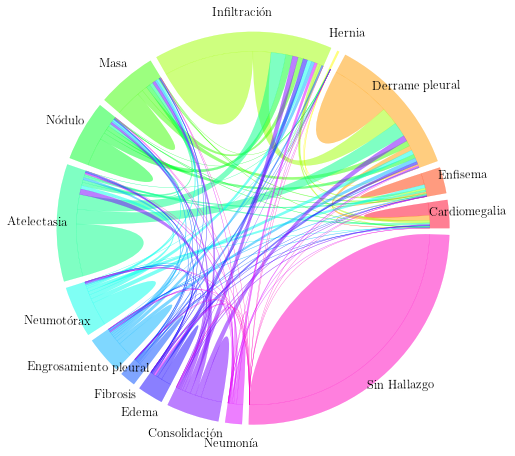

In [21]:
fig = plt.figure(figsize=(6,6))
flux = coocc.to_numpy()[:15,:15]#coocc.to_numpy()

ax = plt.axes([0,0,1,1])
cmap = cm.get_cmap('gist_rainbow', 15)  
crgb =  [cmap(i)[:3] for i in range(cmap.N)]#[hex2rgb(i) for i in c1]
#nodePos = chordDiagram(flux, ax, colors=[hex2rgb(x) for x in ['#666666', '#66ff66', '#ff6666', '#6666ff']])
nodePos = chordDiagram(flux, ax, colors = crgb) #, png = '../Figures/ChestX-ray8/Images/DCuerdas', pdf = '../Figures/ChestX-ray8/PDFs/DCuerdas')
ax.axis('off')
prop = dict(fontsize=16*0.8, ha='center', va='center')
nodes = ['Cardiomegalia','Enfisema','Derrame pleural','Hernia','Infiltración','Masa','Nódulo','Atelectasia','Neumotórax', 'Engrosamiento pleural','Fibrosis','Edema', 'Consolidación','Neumonía','Sin Hallazgo']
for i in range(len(nodes)):
    ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][0], **prop)

ax.patch.set_alpha(0.0)
plt.savefig('../Figures/ChestX-ray8/Images/DCuerdas.png', transparent=True, bbox_inches='tight')
plt.savefig('../Figures/ChestX-ray8/PDFs/DCuerdas.pdf', transparent=True, bbox_inches='tight')
    # plt.savefig("example.png", dpi=600,
#         transparent=True,
#         bbox_inches='tight', pad_inches=0.02)

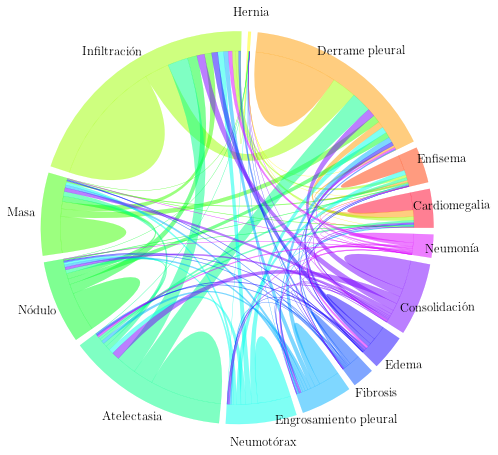

In [22]:
fig = plt.figure(figsize=(6,6))
flux = coocc.to_numpy()[:14,:14]#coocc.to_numpy()

ax = plt.axes([0,0,1,1])
cmap = cm.get_cmap('gist_rainbow', 15)  
crgb =  [cmap(i)[:3] for i in range(cmap.N)]#[hex2rgb(i) for i in c1]
#nodePos = chordDiagram(flux, ax, colors=[hex2rgb(x) for x in ['#666666', '#66ff66', '#ff6666', '#6666ff']])
nodePos = chordDiagram(flux, ax, colors = crgb) #, png = '../Figures/ChestX-ray8/Images/DCuerdas2', pdf = '../Figures/ChestX-ray8/PDFs/DCuerdas2')
ax.axis('off')
prop = dict(fontsize=16*0.8, ha='center', va='center')
nodes = ['Cardiomegalia','Enfisema','Derrame pleural','Hernia','Infiltración','Masa','Nódulo','Atelectasia','Neumotórax', 'Engrosamiento pleural','Fibrosis','Edema', 'Consolidación','Neumonía']
for i in range(len(nodes)):
    ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][0], **prop)
    
ax.patch.set_alpha(0.0)
plt.savefig('../Figures/ChestX-ray8/Images/DCuerdas2.png', transparent=True, bbox_inches='tight')
plt.savefig('../Figures/ChestX-ray8/PDFs/DCuerdas2.pdf', transparent=True, bbox_inches='tight')

# plt.savefig("example.png", dpi=600,
#         transparent=True,
#         bbox_inches='tight', pad_inches=0.02)

Matrices con hallazgo incluido


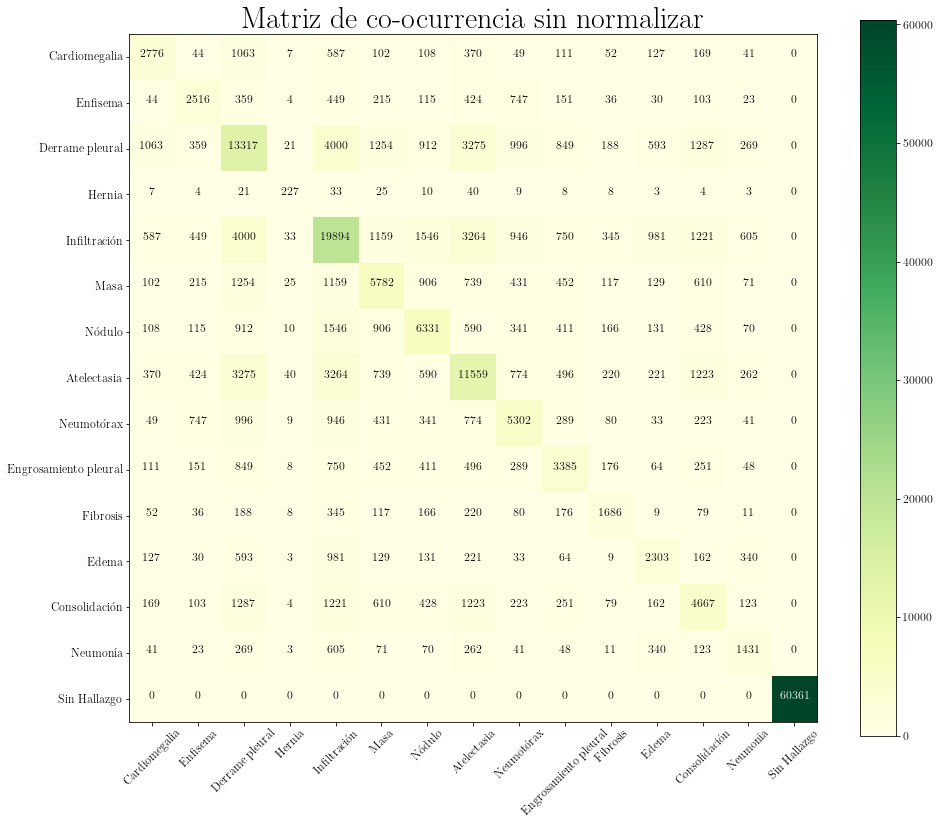

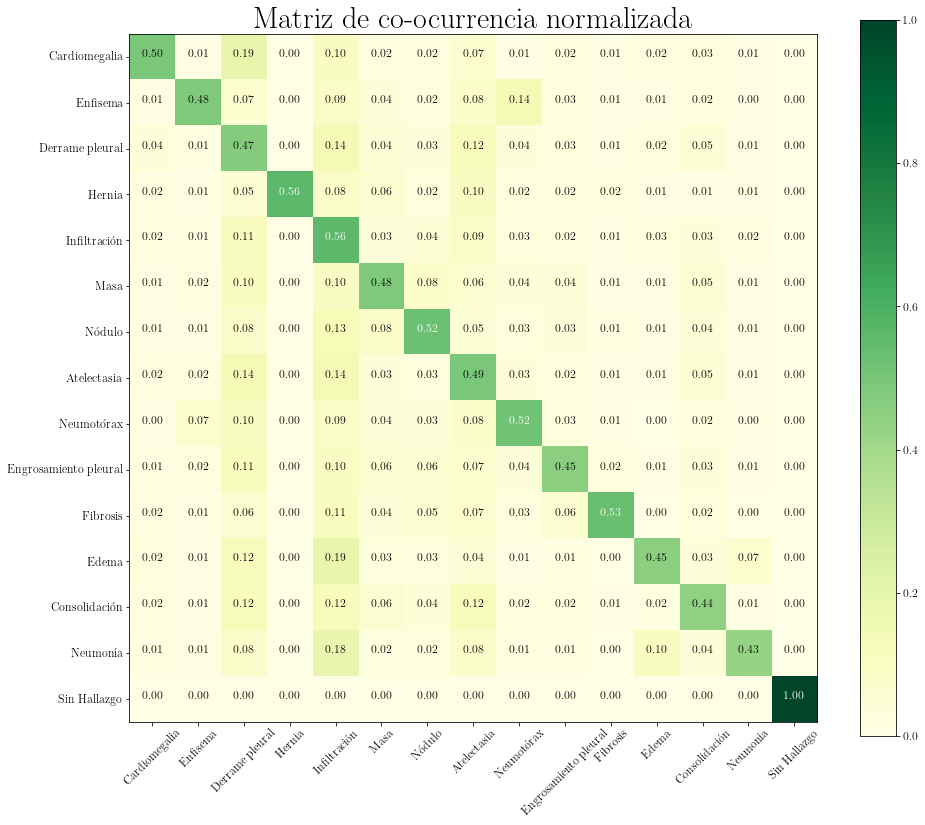

In [23]:
objects = ['Cardiomegalia','Enfisema','Derrame pleural','Hernia','Infiltración','Masa','Nódulo','Atelectasia','Neumotórax', 'Engrosamiento pleural','Fibrosis','Edema', 'Consolidación','Neumonía','Sin Hallazgo']
print('Matrices con hallazgo incluido')
plot_confusion_matrix(coocc.to_numpy(), classes=objects, normalize=False, colors = plt.cm.YlGn, tit = 'Matriz de co-ocurrencia sin normalizar', axisLabels = ['',''], fsizes = {'font':12,'axes':30,'xtick':12, 'ytick':12}) #, png = '../Figures/ChestX-ray8/Images/CMNN', pdf = '../Figures/ChestX-ray8/PDFs/CMNN')
plot_confusion_matrix(coocc.to_numpy(), classes=objects, normalize=True, colors = plt.cm.YlGn, tit = 'Matriz de co-ocurrencia normalizada', axisLabels = ['',''], fsizes = {'font':12,'axes':30,'xtick':12, 'ytick':12}) #, png = '../Figures/ChestX-ray8/Images/CMN', pdf = '../Figures/ChestX-ray8/PDFs/CMN')

Matrices sin hallazgo incluido


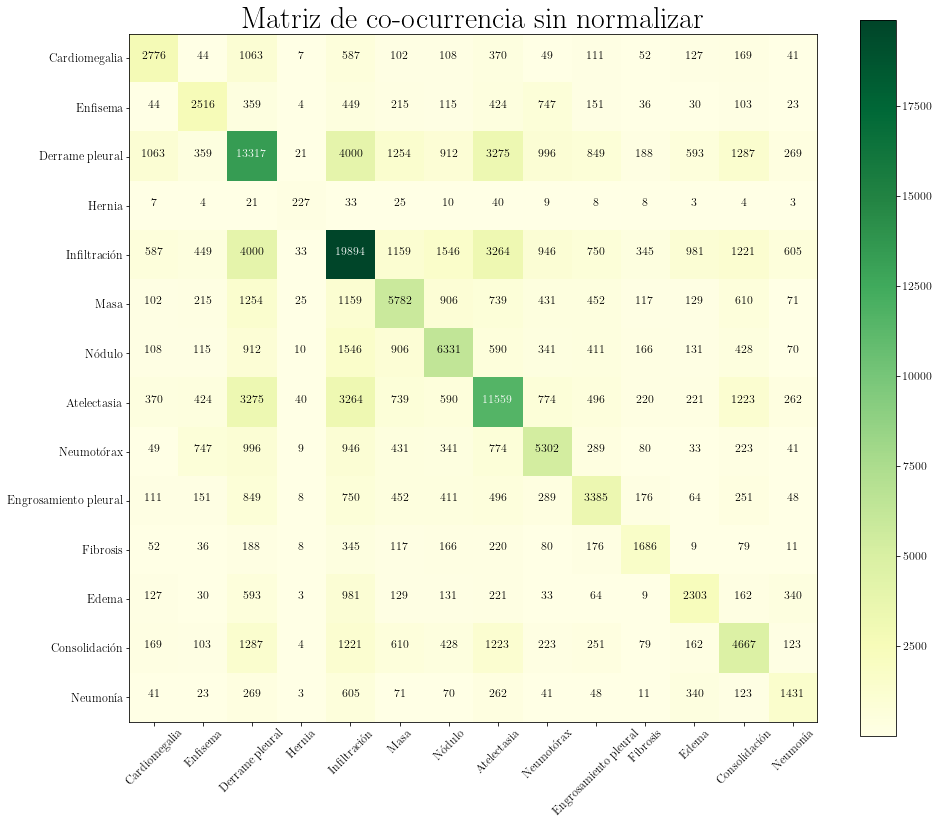

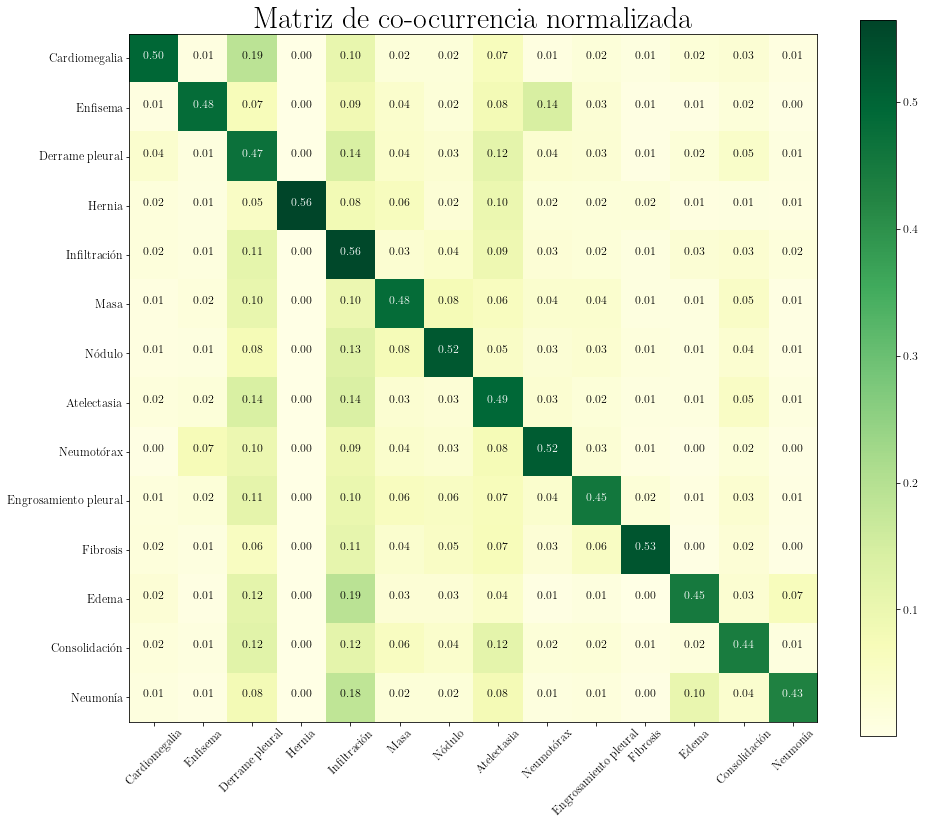

In [24]:
objects = ['Cardiomegalia','Enfisema','Derrame pleural','Hernia','Infiltración','Masa','Nódulo','Atelectasia','Neumotórax', 'Engrosamiento pleural','Fibrosis','Edema', 'Consolidación','Neumonía']#,'Sin Hallazgo']
print('Matrices sin hallazgo incluido')
plot_confusion_matrix(coocc.to_numpy()[:14,:14], classes=objects, normalize=False, colors = plt.cm.YlGn, tit = 'Matriz de co-ocurrencia sin normalizar', axisLabels = ['',''], fsizes = {'font':12,'axes':30,'xtick':12, 'ytick':12}) #, png = '../Figures/ChestX-ray8/Images/CMNN2', pdf = '../Figures/ChestX-ray8/PDFs/CMNN2')
plot_confusion_matrix(coocc.to_numpy()[:14,:14], classes=objects, normalize=True, colors = plt.cm.YlGn, tit = 'Matriz de co-ocurrencia normalizada', axisLabels = ['',''], fsizes = {'font':12,'axes':30,'xtick':12, 'ytick':12}) #, png = '../Figures/ChestX-ray8/Images/CMN2', pdf = '../Figures/ChestX-ray8/PDFs/CMN2')

In [25]:
# Multicolumnas
# c14BG = c14.groupby(['Patient ID','Finding Labels'])
# f = c14BG.first()
# f

# BoundingBox Labeled Images Statistics

In [26]:
bbx14 = pd.read_csv('../ChestX-ray8-Data/BBox_List_2017.csv')
bbx14 = bbx14[['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]']]
bbx14

Image Index Finding Label     Bbox [x           y           w  \
0    00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1    00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2    00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3    00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4    00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   
..                ...           ...         ...         ...         ...   
979  00029464_015.png   Atelectasis  198.940451  352.900747  615.537778   
980  00025769_001.png   Atelectasis  701.838229  572.491858  103.537778   
981  00016837_002.png   Atelectasis  140.913785  658.962969  271.928889   
982  00020124_003.png   Atelectasis  175.047118  580.456302  244.622222   
983  00026920_000.png   Atelectasis  343.438229  446.198524  120.604444   

             h]  
0     79.186441  
1    313.491525  
2    216.949153  
3     55.322034  
4     78.101695  
..          ...  
979  323.128889  
980   63.715556  
981   94.435556  
982  103.537778  
983   53.475556  

[984 rows x 6 columns]

In [27]:
labels = bbx14['Finding Label']
ulabels = pd.Series(labels).unique()
print(ulabels)
dup_labnum = pd.Series(labels).value_counts()
print(dup_labnum)

nlraw = [dup_labnum[i] for i in range(len(dup_labnum))]
nlnorm = [float(i)/sum(nlraw) for i in nlraw]
labs = dup_labnum.index

labsmap = {'Cardiomegaly':'Cardiomegalia',
           'Effusion':'Derrame pleural',
           'Infiltrate':'Infiltración',
           'Mass':'Masa',
           'Nodule':'Nódulo', 
           'Atelectasis':'Atelectasia', 
           'Pneumothorax':'Neumotórax', 
           'Pneumonia':'Neumonía'}

['Atelectasis' 'Cardiomegaly' 'Effusion' 'Infiltrate' 'Mass' 'Nodule'
 'Pneumonia' 'Pneumothorax']
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64


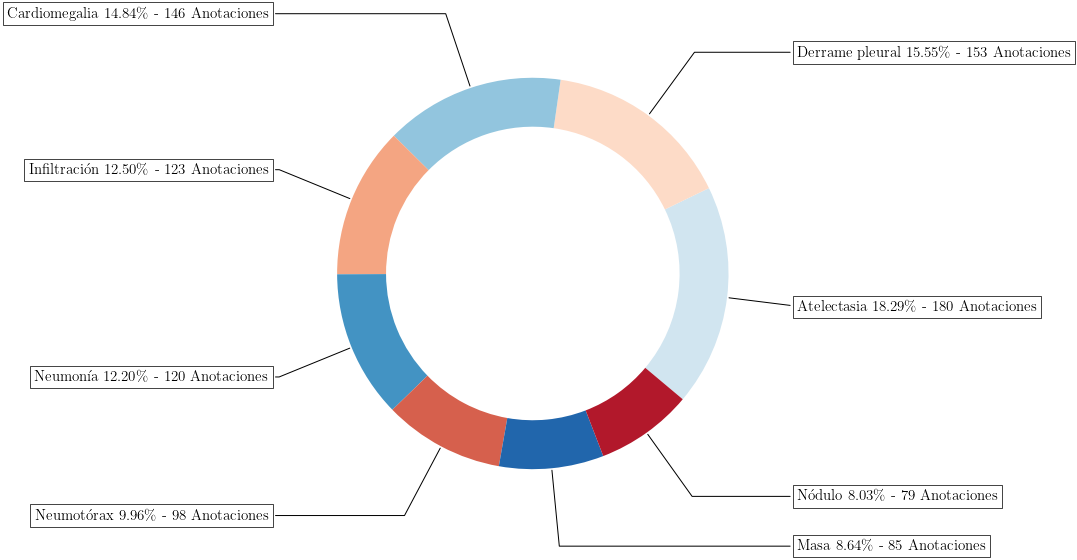

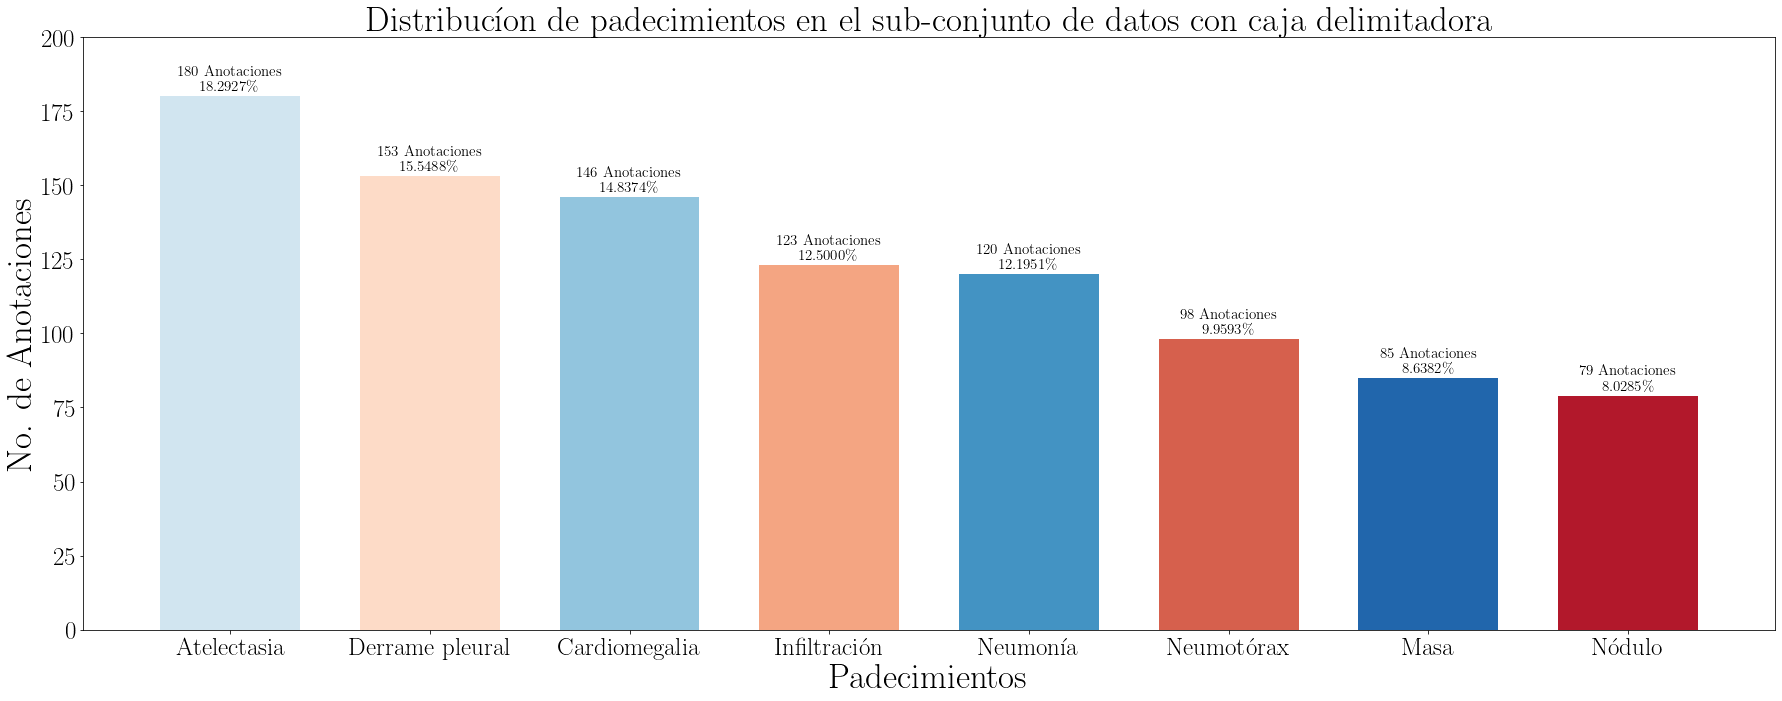

In [28]:
labels = ['{} {:.2f}\% - {} Anotaciones'.format(labsmap[labs[i]],nlnorm[i]* 100,nlraw[i]) for i in range(len(labs))]
data = nlraw.copy()
donutPlot(data,labels,legend=False, fontset = 15)

labels = ['{}'.format(labsmap[labs[i]])  for i in range(len(labs))]
data = {'Padecimientos':data}
title = 'Distribucíon de padecimientos en el sub-conjunto de datos con caja delimitadora'
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Anotaciones\n{:.4f}\%',[n*100 for n in nlnorm]],fsizes = {'font':15,'axes':35,'xtick':25, 'ytick':25}, axisLim = {'ylim':[0,200]},axislabels=['Padecimientos','No. de Anotaciones']) #, png = '../Figures/ChestX-ray8/Images/BBDP', pdf = '../Figures/ChestX-ray8/PDFs/BBDP')

In [29]:
bbImgs = {}
created = []
for i in range(len(bbx14)):
    if bbx14.iloc[i].loc['Image Index'] in created: 
        bbImgs[bbx14.iloc[i].loc['Image Index']].append(bbx14.iloc[i].loc['Finding Label'])
    else: # Crear un archivo para dicha imagen
        bbImgs[bbx14.iloc[i].loc['Image Index']] = []
        bbImgs[bbx14.iloc[i].loc['Image Index']].append(bbx14.iloc[i].loc['Finding Label'])
        created.append(bbx14.iloc[i].loc['Image Index'])
bbImgs = dict(sorted(bbImgs.items()))
bbImgs # relacion de cada imagen con los etiquetados de padecimeintos que tiene como cajas delimitadoras

bbImgsK = list(bbImgs.keys())
cbbx14 = c14.loc[c14['Image Index'].isin(bbImgsK)]
cImgs = {}
created2 = []
for i in range(len(cbbx14)):
    if cbbx14.iloc[i].loc['Image Index'] in created2: 
        sp = cbbx14.iloc[i].loc['Finding Labels'].split('|')
        for j in sp:
            cImgs[cbbx14.iloc[i].loc['Image Index']].append(j)
    else: # Crear un archivo para dicha imagen
        cImgs[cbbx14.iloc[i].loc['Image Index']] = []
        sp = cbbx14.iloc[i].loc['Finding Labels'].split('|')
        for j in sp:
            cImgs[cbbx14.iloc[i].loc['Image Index']].append(j)
        created2.append(cbbx14.iloc[i].loc['Image Index'])
cImgs # relacion de cada imagen con los etiquetados de padecimeintos que tiene en el conjunto total
      # pero solo de las imágenes que también aparecen en el conjunto etiquetado con cajas delimitadoras

c = 0
for i in cImgs.keys():
    flag = 0
    for j in cImgs[i]:
        if j not in bbImgs[i]:
            flag = 1
    if flag ==1:
        c+=1
print('Existen {} casos en total que tienen mas etiquetas en el conjunto total, de las que aparecen en el conjunto de cajas delimitadoras'.format(c))

Existen 631 casos en total que tienen mas etiquetas en el conjunto total, de las que aparecen en el conjunto de cajas delimitadoras


In [30]:
# Número de Pacientes Únicos
ImgIndxs = []
for i in bbx14['Image Index']:
  ImgIndxs.append(i[:8])
ImgIndxs = pd.Series(ImgIndxs)
# print(ImgIndxs)
UImgIndxs = ImgIndxs.value_counts()
print('Padecimientos etiquetados:', len(ImgIndxs))
print('Imagenes únicas: ', len(bbx14['Image Index'].unique()))
print('Pacientes únicos: ', len(UImgIndxs))

Padecimientos etiquetados: 984
Imagenes únicas:  880
Pacientes únicos:  726


Total de personas de sexo femenino: 314 
Total de personas de sexo masculino: 412


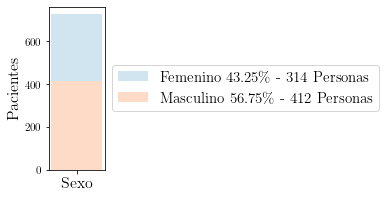

In [31]:
bb14Se = c14[c14['Image Index'].isin(bbx14['Image Index'])]
bb14Se = bb14Se[['Patient ID','Patient Gender']]
bb14SeBG = bb14Se.groupby(['Patient ID'])
SeCount = bb14SeBG.first()['Patient Gender'].value_counts()
m,f = SeCount['M'], SeCount['F'],
genraw = [m,f]
gennorm = [float(i)/sum(genraw) for i in genraw]

print('Total de personas de sexo femenino:', f, '\nTotal de personas de sexo masculino:', m)

labels = ['Sexo']
width = 0.35   
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=11)
# plt.rc('font', size=10)

fig, ax = plt.subplots(figsize=(1, 3))

ax.bar(labels, f, width, bottom=m, label='Femenino {:.2f}\% - {} Personas'.format(gennorm[1]*100, f))
ax.bar(labels, m, width, label='Masculino {:.2f}\% - {} Personas'.format(gennorm[0]*100, m))

ax.set_ylabel('Pacientes')
# ax.set_title('Scores by group and gender')
ax.legend(loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.patch.set_alpha(0.0)
plt.savefig('../Figures/ChestX-ray8/Images/BBPxS.png', transparent=True, bbox_inches='tight')
plt.savefig('../Figures/ChestX-ray8/PDFs/BBPxS.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [74]:
bb14Ed[(bb14Ed['Patient Age'] > 10) & (bb14Ed['Patient Age'] < 81)]

Patient ID  Patient Age       Image Index
151             32           54  00000032_037.png
310             72           67  00000072_000.png
596            147           66  00000147_001.png
608            149           70  00000149_006.png
614            150           55  00000150_002.png
...            ...          ...               ...
111704       30606           58  00030606_006.png
111791       30634           60  00030634_000.png
111793       30635           50  00030635_001.png
111807       30636           45  00030636_004.png
111926       30674           79  00030674_000.png

[865 rows x 3 columns]

In [76]:
bb14Ed = c14[c14['Image Index'].isin(bbx14['Image Index'])]
bb14Ed = bb14Ed[['Patient ID','Patient Age','Image Index']]
agecount = bb14Ed['Patient Age'].value_counts()

edad0,edad1,edad2,edad3,edad4,edad5,edad6,edad7,edad8,edad9 = 0,0,0,0,0,0,0,0,0,0

for i in agecount.index:
    if 0 <= i <= 10:
        edad0 += agecount[i]
    elif 11 <= i <= 20:
        edad1 += agecount[i]
    elif 21 <= i <= 30:
        edad2 += agecount[i]
    elif 31 <= i <= 40:
        edad3 += agecount[i]
    elif 41 <= i <= 50:
        edad4 += agecount[i]
    elif 51 <= i <= 60:
        edad5 += agecount[i]
    elif 61 <= i <= 70:
        edad6 += agecount[i]
    elif 71 <= i <= 80:
        edad7 += agecount[i]
    elif 81 <= i <= 90:
        edad8 += agecount[i]
    else:
        edad9 += agecount[i]

edades = [edad0,edad1,edad2,edad3,edad4,edad5,edad6,edad7,edad8,edad9]
ednorm = [float(i)/sum(edades) for i in edades]

print(' Total:', sum(edades),'\n 0 <= Edad <= 10:',edad0, '\n 11 <= Edad <= 20: ',edad1, '\n 21 <= Edad <= 30: ',edad2,
'\n 31 <= Edad <= 40: ',edad3, '\n 41 <= Edad <= 50: ',edad4,'\n 51 <= Edad <= 60: ',edad5,'\n 61 <= Edad <= 70: ',edad6,
'\n 71 <= Edad <= 80: ',edad7,'\n 81 <= Edad <= 90: ',edad8,'\n Edad > 90: ',edad9)

 Total: 880 
 0 <= Edad <= 10: 9 
 11 <= Edad <= 20:  40 
 21 <= Edad <= 30:  96 
 31 <= Edad <= 40:  131 
 41 <= Edad <= 50:  159 
 51 <= Edad <= 60:  248 
 61 <= Edad <= 70:  141 
 71 <= Edad <= 80:  50 
 81 <= Edad <= 90:  5 
 Edad > 90:  1


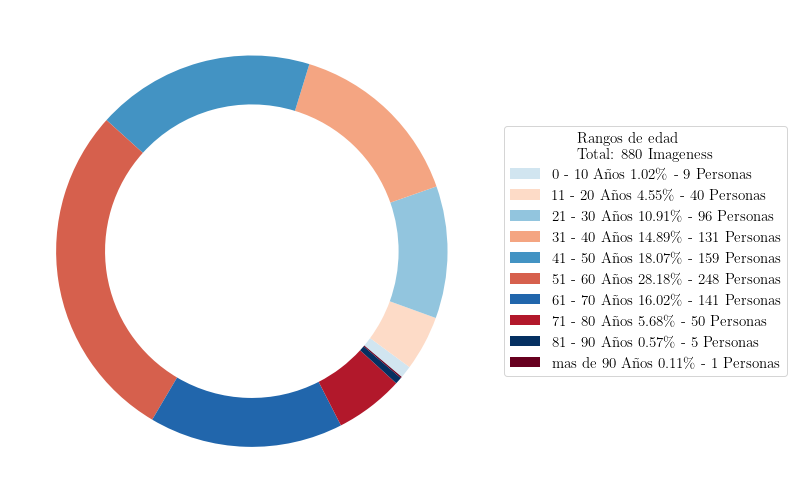

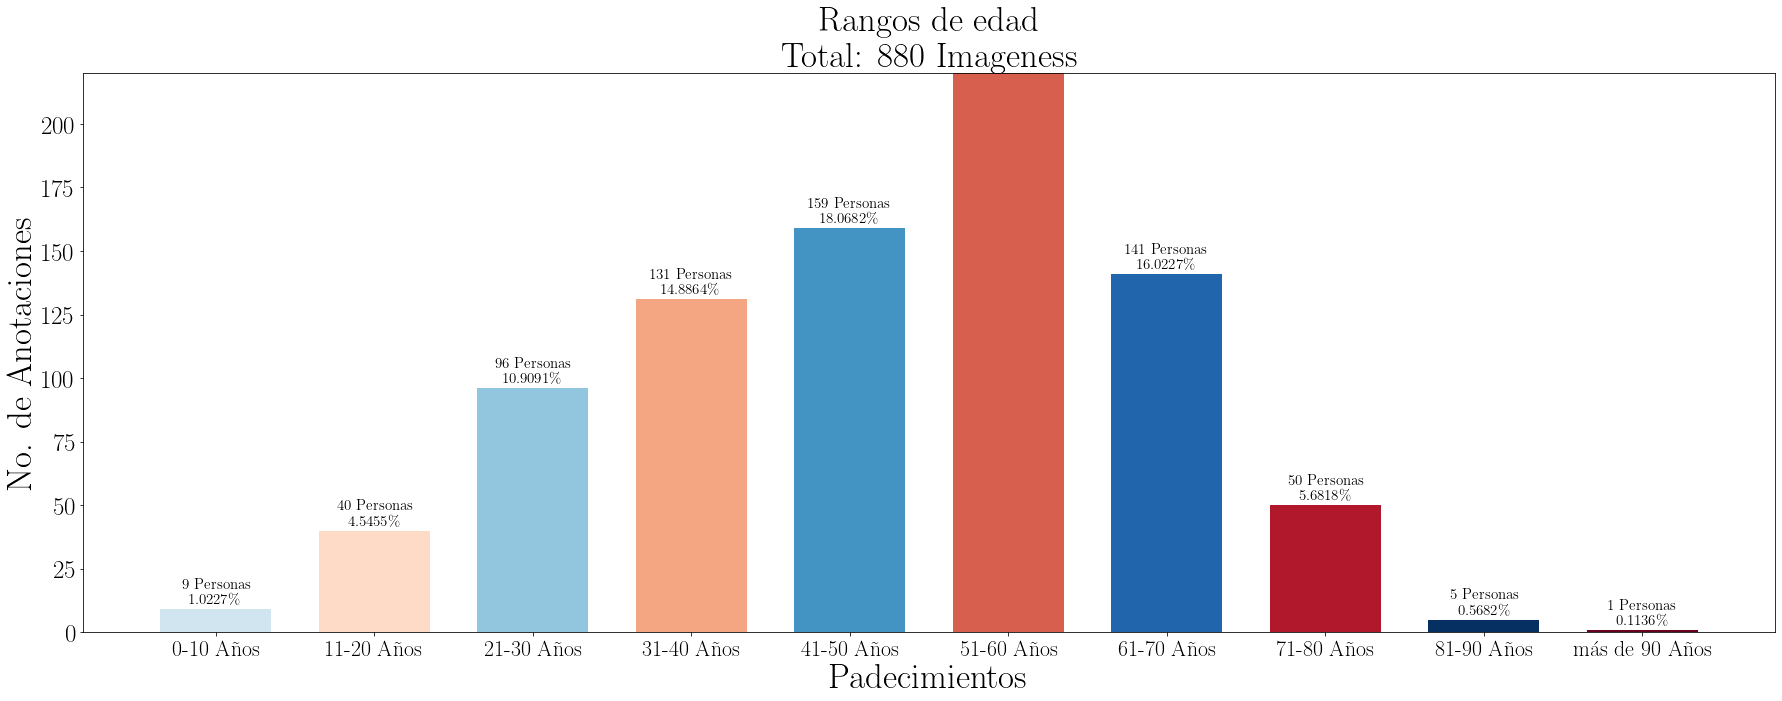

In [79]:
labels = ['0 - 10 Años {:.2f}\% - {} Personas'.format(ednorm[0]*100,edades[0]), '11 - 20 Años {:.2f}\% - {} Personas'.format(ednorm[1]*100,edades[1]), '21 - 30 Años {:.2f}\% - {} Personas'.format(ednorm[2]*100,edades[2]), '31 - 40 Años {:.2f}\% - {} Personas'.format(ednorm[3]*100,edades[3]), '41 - 50 Años {:.2f}\% - {} Personas'.format(ednorm[4]*100,edades[4]),
          '51 - 60 Años {:.2f}\% - {} Personas'.format(ednorm[5]*100,edades[5]), '61 - 70 Años {:.2f}\% - {} Personas'.format(ednorm[6]*100,edades[6]), '71 - 80 Años {:.2f}\% - {} Personas'.format(ednorm[7]*100,edades[7]), '81 - 90 Años {:.2f}\% - {} Personas'.format(ednorm[8]*100,edades[8]), 'mas de 90 Años {:.2f}\% - {} Personas'.format(ednorm[9]*100,edades[9])]

data = edades.copy()
title = "        Rangos de edad\n Total: {} Imageness".format(sum(data))
donutPlot(data,labels,title,fontset = 15)

# labels = ['0 - 10 Años \n{:.2f}% - {} Personas'.format(ednorm[0]*100,edades[0]), '11 - 20 Años \n{:.2f}% - {} Personas'.format(ednorm[1]*100,edades[1]), '21 - 30 Años \n{:.2f}% - {} Personas'.format(ednorm[2]*100,edades[2]), '31 - 40 Años \n{:.2f}% - {} Personas'.format(ednorm[3]*100,edades[3]), '41 - 50 Años \n{:.2f}% - {} Personas'.format(ednorm[4]*100,edades[4]),
#           '51 - 60 Años \n{:.2f}% - {} Personas'.format(ednorm[5]*100,edades[5]), '61 - 70 Años \n{:.2f}% - {} Personas'.format(ednorm[6]*100,edades[6]), '71 - 80 Años \n{:.2f}% - {} Personas'.format(ednorm[7]*100,edades[7]), '81 - 90 Años \n{:.2f}% - {} Personas'.format(ednorm[8]*100,edades[8]), 'mas de 90 Años \n{:.2f}% - {} Personas'.format(ednorm[9]*100,edades[9])]
labels  = ['{}-{} Años'.format(i*10,(i+1)*10) if i == 0 else '{}-{} Años'.format(i*10+1,(i+1)*10) for i in range(9)]
labels.append('más de 90 Años')
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Personas\n{:.4f}\%',[n*100 for n in ednorm]],fsizes = {'font':15,'axes':35,'xtick':22, 'ytick':25}, axisLim = {'ylim':[0,220]},axislabels=['Padecimientos','No. de Anotaciones']) #, png = '../Figures/ChestX-ray8/Images/BBPxE', pdf = '../Figures/ChestX-ray8/PDFs/BBPxE')

In [32]:
bb14Ed = c14[c14['Image Index'].isin(bbx14['Image Index'])]
bb14Ed = bb14Ed[['Patient ID','Patient Age','Image Index']]
bb14EdBG = bb14Ed.groupby(['Patient ID'])
agecount = bb14EdBG.first()['Patient Age'].value_counts()

edad0,edad1,edad2,edad3,edad4,edad5,edad6,edad7,edad8,edad9 = 0,0,0,0,0,0,0,0,0,0

for i in agecount.index:
    if 0 <= i <= 10:
        edad0 += agecount[i]
    elif 11 <= i <= 20:
        edad1 += agecount[i]
    elif 21 <= i <= 30:
        edad2 += agecount[i]
    elif 31 <= i <= 40:
        edad3 += agecount[i]
    elif 41 <= i <= 50:
        edad4 += agecount[i]
    elif 51 <= i <= 60:
        edad5 += agecount[i]
    elif 61 <= i <= 70:
        edad6 += agecount[i]
    elif 71 <= i <= 80:
        edad7 += agecount[i]
    elif 81 <= i <= 90:
        edad8 += agecount[i]
    else:
        edad9 += agecount[i]

edades = [edad0,edad1,edad2,edad3,edad4,edad5,edad6,edad7,edad8,edad9]
ednorm = [float(i)/sum(edades) for i in edades]

print(' Total:', sum(edades),'\n 0 <= Edad <= 10:',edad0, '\n 11 <= Edad <= 20: ',edad1, '\n 21 <= Edad <= 30: ',edad2,
'\n 31 <= Edad <= 40: ',edad3, '\n 41 <= Edad <= 50: ',edad4,'\n 51 <= Edad <= 60: ',edad5,'\n 61 <= Edad <= 70: ',edad6,
'\n 71 <= Edad <= 80: ',edad7,'\n 81 <= Edad <= 90: ',edad8,'\n Edad > 90: ',edad9)

 Total: 726 
 0 <= Edad <= 10: 8 
 11 <= Edad <= 20:  32 
 21 <= Edad <= 30:  82 
 31 <= Edad <= 40:  104 
 41 <= Edad <= 50:  125 
 51 <= Edad <= 60:  202 
 61 <= Edad <= 70:  122 
 71 <= Edad <= 80:  45 
 81 <= Edad <= 90:  5 
 Edad > 90:  1


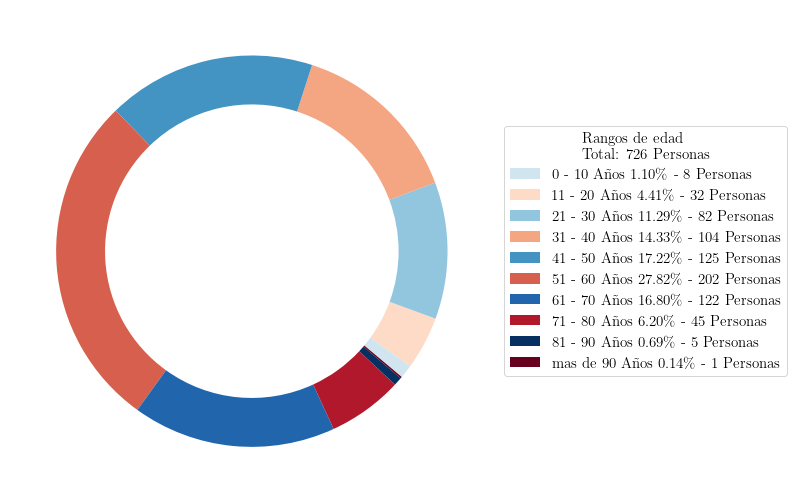

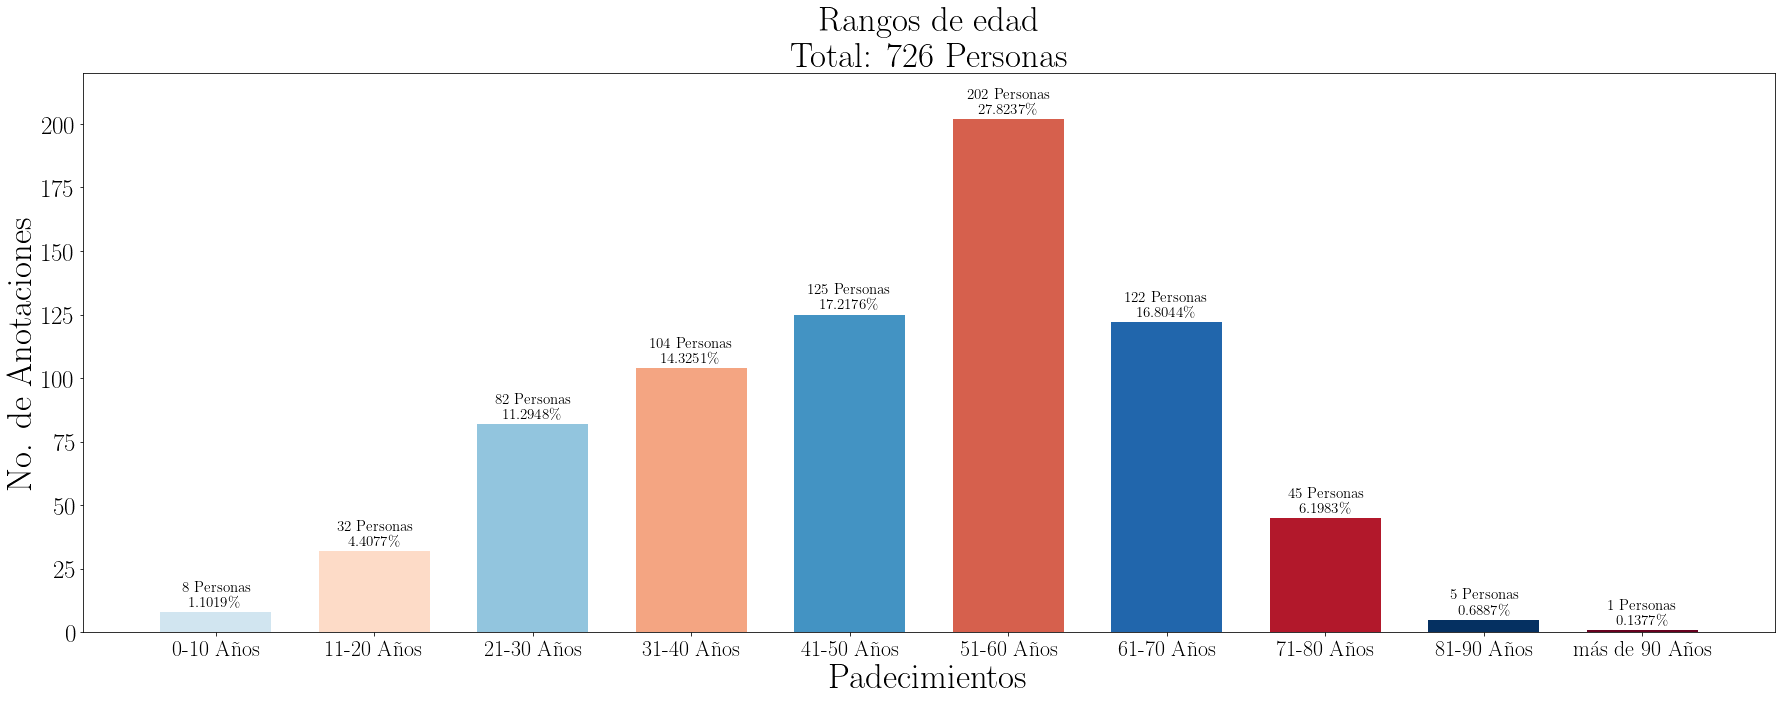

In [33]:
labels = ['0 - 10 Años {:.2f}\% - {} Personas'.format(ednorm[0]*100,edades[0]), '11 - 20 Años {:.2f}\% - {} Personas'.format(ednorm[1]*100,edades[1]), '21 - 30 Años {:.2f}\% - {} Personas'.format(ednorm[2]*100,edades[2]), '31 - 40 Años {:.2f}\% - {} Personas'.format(ednorm[3]*100,edades[3]), '41 - 50 Años {:.2f}\% - {} Personas'.format(ednorm[4]*100,edades[4]),
          '51 - 60 Años {:.2f}\% - {} Personas'.format(ednorm[5]*100,edades[5]), '61 - 70 Años {:.2f}\% - {} Personas'.format(ednorm[6]*100,edades[6]), '71 - 80 Años {:.2f}\% - {} Personas'.format(ednorm[7]*100,edades[7]), '81 - 90 Años {:.2f}\% - {} Personas'.format(ednorm[8]*100,edades[8]), 'mas de 90 Años {:.2f}\% - {} Personas'.format(ednorm[9]*100,edades[9])]

data = edades.copy()
title = "        Rangos de edad\n Total: {} Personas".format(sum(data))
donutPlot(data,labels,title,fontset = 15)

# labels = ['0 - 10 Años \n{:.2f}% - {} Personas'.format(ednorm[0]*100,edades[0]), '11 - 20 Años \n{:.2f}% - {} Personas'.format(ednorm[1]*100,edades[1]), '21 - 30 Años \n{:.2f}% - {} Personas'.format(ednorm[2]*100,edades[2]), '31 - 40 Años \n{:.2f}% - {} Personas'.format(ednorm[3]*100,edades[3]), '41 - 50 Años \n{:.2f}% - {} Personas'.format(ednorm[4]*100,edades[4]),
#           '51 - 60 Años \n{:.2f}% - {} Personas'.format(ednorm[5]*100,edades[5]), '61 - 70 Años \n{:.2f}% - {} Personas'.format(ednorm[6]*100,edades[6]), '71 - 80 Años \n{:.2f}% - {} Personas'.format(ednorm[7]*100,edades[7]), '81 - 90 Años \n{:.2f}% - {} Personas'.format(ednorm[8]*100,edades[8]), 'mas de 90 Años \n{:.2f}% - {} Personas'.format(ednorm[9]*100,edades[9])]
labels  = ['{}-{} Años'.format(i*10,(i+1)*10) if i == 0 else '{}-{} Años'.format(i*10+1,(i+1)*10) for i in range(9)]
labels.append('más de 90 Años')
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Personas\n{:.4f}\%',[n*100 for n in ednorm]],fsizes = {'font':15,'axes':35,'xtick':22, 'ytick':25}, axisLim = {'ylim':[0,220]},axislabels=['Padecimientos','No. de Anotaciones']) #, png = '../Figures/ChestX-ray8/Images/BBPxE', pdf = '../Figures/ChestX-ray8/PDFs/BBPxE')

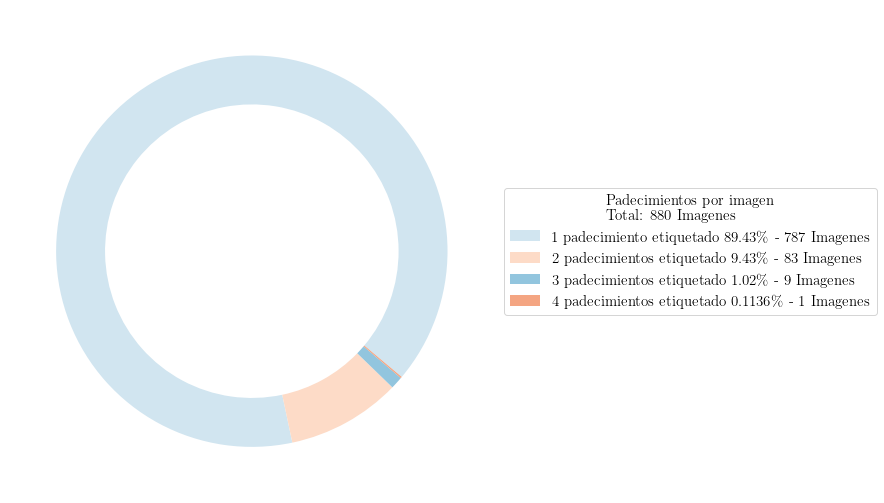

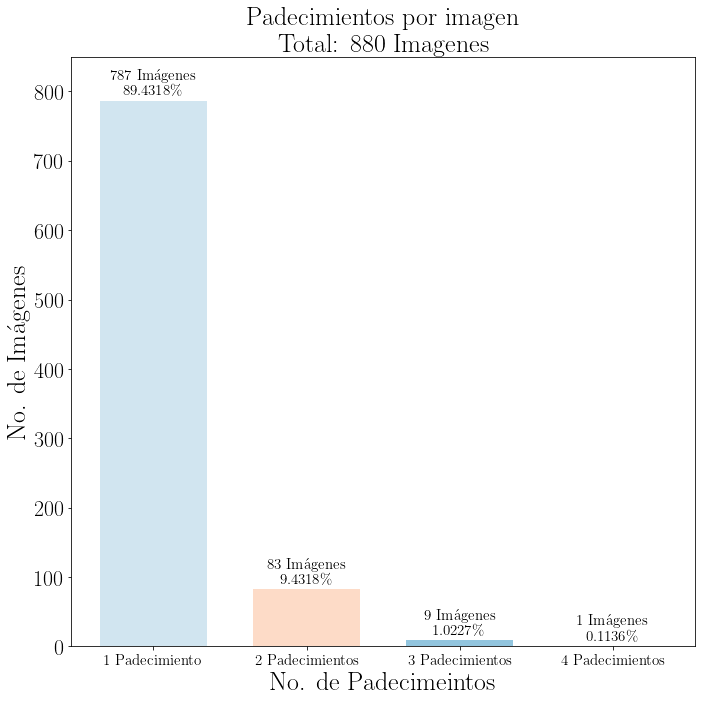

In [34]:
cb1,cb2,cb3,cb4 = 0,0,0,0
for i in bbx14[['Image Index']].value_counts():
    if i == 1:
        cb1 += 1
    elif i == 2:
        cb2 += 1
    elif i == 3:
        cb3 += 1
    elif i == 4:
        cb4 += 1
        
cb = [cb1,cb2,cb3,cb4]
cbnorm = [i/sum(cb) for i in cb]

labels = ['1 padecimiento etiquetado {:.2f}\% - {} Imagenes'.format(cbnorm[0]*100, cb[0]),'2 padecimientos etiquetado {:.2f}\% - {} Imagenes'.format(cbnorm[1]*100, cb[1]),'3 padecimientos etiquetado {:.2f}\% - {} Imagenes'.format(cbnorm[2]*100, cb[2]),'4 padecimientos etiquetado {:.4f}\% - {} Imagenes'.format(cbnorm[3]*100, cb[3])]
data = cb.copy()
title = "     Padecimientos por imagen \n         Total: {} Imagenes".format(sum(data))
donutPlot(data,labels,title,fontset = 15)

labels  = ['{} Padecimiento'.format(i+1) if i+1 == 1 else '{} Padecimientos'.format(i+1) for i in range(4)]
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(10,10), barLabel=['{} Imágenes\n{:.4f}\%',[n*100 for n in cbnorm]],fsizes = {'font':15,'axes':26,'xtick':15, 'ytick':22}, axisLim = {'ylim':[0,850]},axislabels=['No. de Padecimeintos','No. de Imágenes']) #, png = '../Figures/ChestX-ray8/Images/BBPxI', pdf = '../Figures/ChestX-ray8/PDFs/BBPxI')

In [35]:
cLabs = list(bbx14[['Image Index']].value_counts())
q  = len(labsmap)
print('Para el conjunto de datos con cajad delimitadoras \n')

print('La cardinalidad de las etiquetas en el conjunto es: ', LabelCardinality(cLabs))
print('La densidad de las etiquetas en el conjunto es: ', LabelDensity(cLabs, q))

cre = []
coun = 0
for i in range(len(list(bbImgs.values()))):
    if set(list(bbImgs.values())[i]) not in cre: 
        coun += 1
        cre.append(set(list(bbImgs.values())[i]))
        
print('El número de conjuntos de etiquetas distintos es:', len(cre))

Para el conjunto de datos con cajad delimitadoras 

La cardinalidad de las etiquetas en el conjunto es:  1.1181818181818182
La densidad de las etiquetas en el conjunto es:  0.13977272727272727
El número de conjuntos de etiquetas distintos es: 31


In [36]:
set(list(bbImgs.values())[27]),list(bbImgs.values())[48], list(bbImgs.values())[218]

({'Atelectasis', 'Mass'}, ['Atelectasis', 'Mass'], ['Mass', 'Atelectasis'])

In [37]:
list(bbImgs.values())[27] == list(bbImgs.values())[218],set(list(bbImgs.values())[27]) == set(list(bbImgs.values())[218])

(False, True)

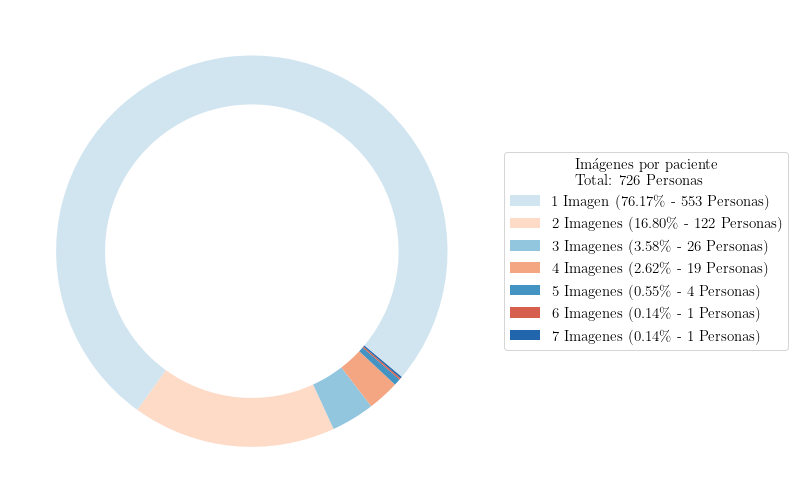

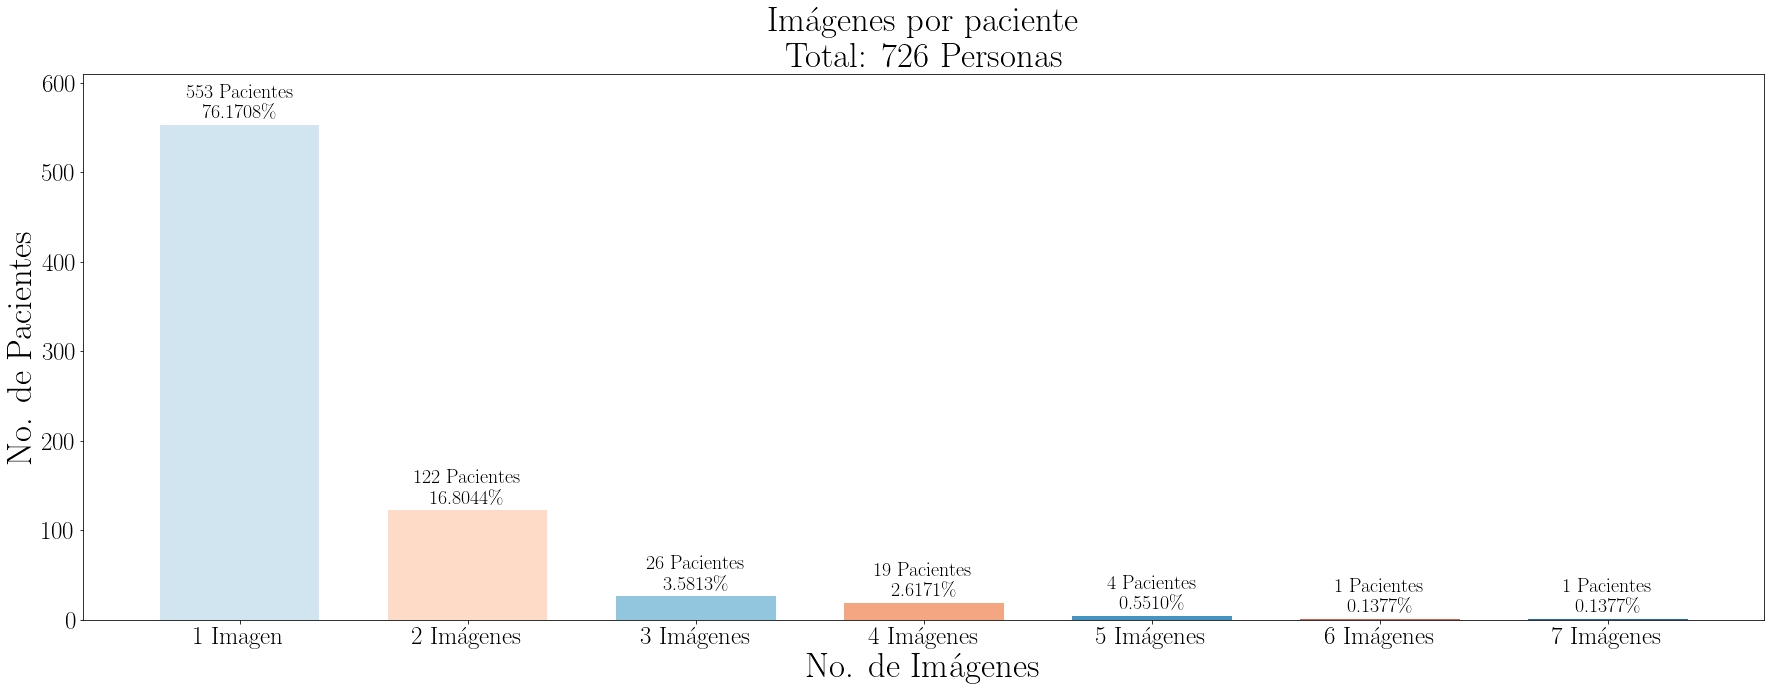

In [38]:
# Número de Pacientes Únicos
ImgIndxs = []
for i in bbx14['Image Index']:
  ImgIndxs.append(i[:8])
ImgIndxs = pd.Series(ImgIndxs)
# print(ImgIndxs)
UImgIndxs = ImgIndxs.value_counts()

c1,c2,c3,c4,c5,c6,c7=0,0,0,0,0,0,0
for i in UImgIndxs:
    if i == 1:
        c1 += 1
    elif i == 2:
        c2 += 1
    elif i == 3:
        c3 += 1
    elif i == 4:
        c4 += 1
    elif i ==5:
        c5 += 1
    elif i == 6:
        c6 += 1
    elif i == 7:
        c7 += 1

data = [c1,c2,c3,c4,c5,c6,c7]
nlnorm = [float(i)/sum(data) for i in data]
labels = ['1 Imagen ({:.2f}\% - {} Personas)'.format(nlnorm[0]*100, c1), '2 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[1]*100, c2), '3 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[2]*100, c3),'4 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[3]*100, c4), '5 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[4]*100, c5), '6 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[5]*100, c6), '7 Imagenes ({:.2f}\% - {} Personas)'.format(nlnorm[6]*100, c7)]
title = "Imágenes por paciente \n   Total: {} Personas".format(sum(data))
donutPlot(data,labels,title, fontset = 15)

# labels = ['1 Imagen \n({:.2f}% - {} Personas)'.format(nlnorm[0]*100, c1), '2 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[1]*100, c2), '3 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[2]*100, c3),'4 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[3]*100, c4), '5 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[4]*100, c5), '6 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[5]*100, c6), '7 Imagenes \n({:.2f}% - {} Personas)'.format(nlnorm[6]*100, c7)]
labels  = ['{} Imagen'.format(i+1) if i+1 == 1 else '{} Imágenes'.format(i+1) for i in range(7)]
data = {'Padecimientos':data}
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), barLabel=['{} Pacientes\n{:.4f}\%',[n*100 for n in nlnorm]],fsizes = {'font':20,'axes':35,'xtick':25, 'ytick':25}, axisLim = {'ylim':[0,610]},axislabels=['No. de Imágenes','No. de Pacientes']) #, png = '../Figures/ChestX-ray8/Images/BBIxP', pdf = '../Figures/ChestX-ray8/PDFs/BBIxP')

Gráficas generadas unicamente con la primera aparicion del paciente, a una edad especifica. 
Es decir un registro por paciente, de los 726 pacientes únicos


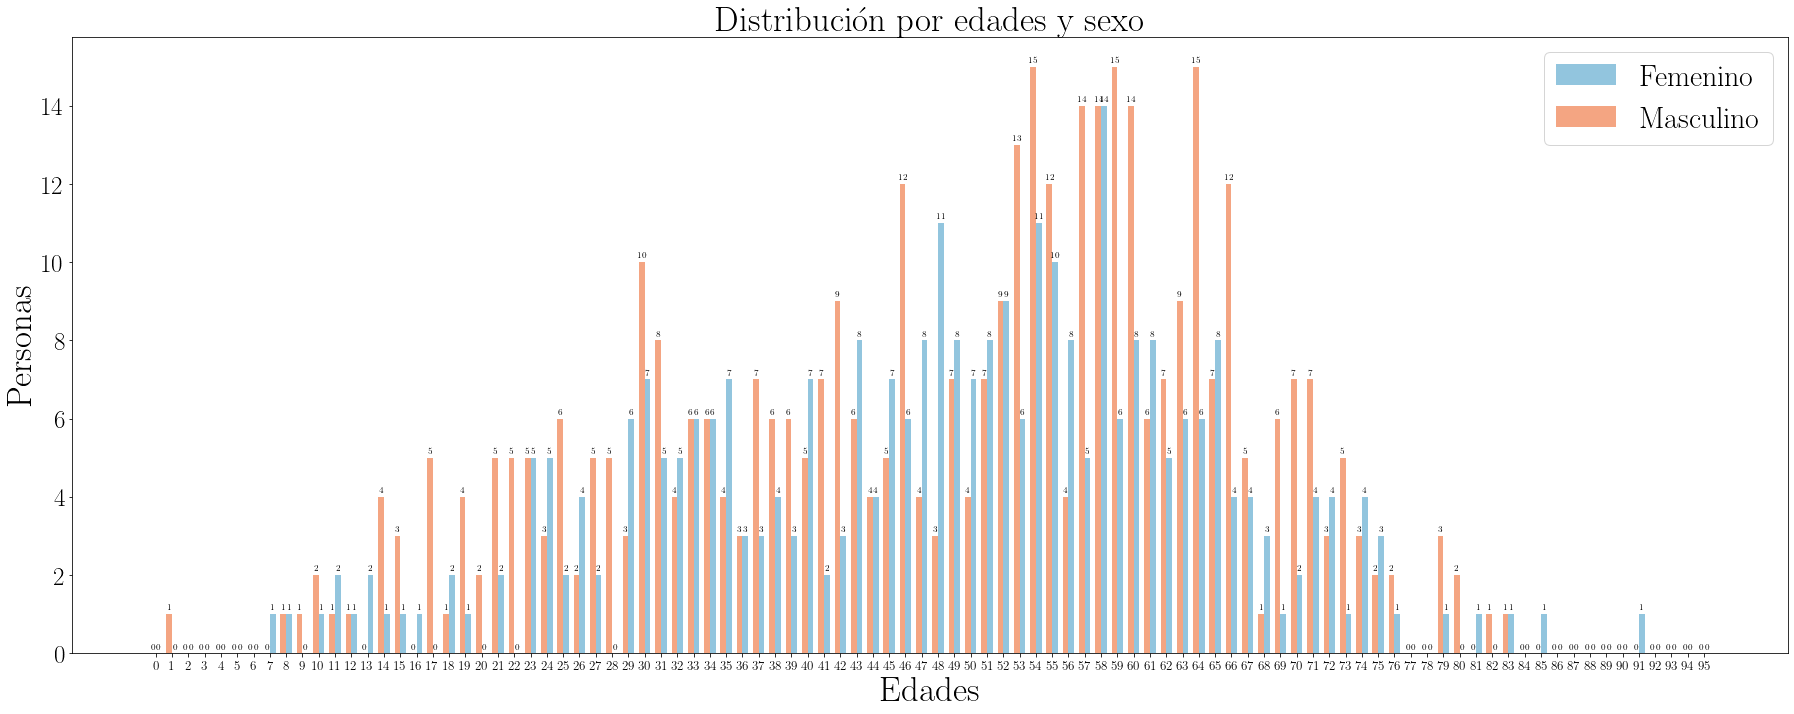

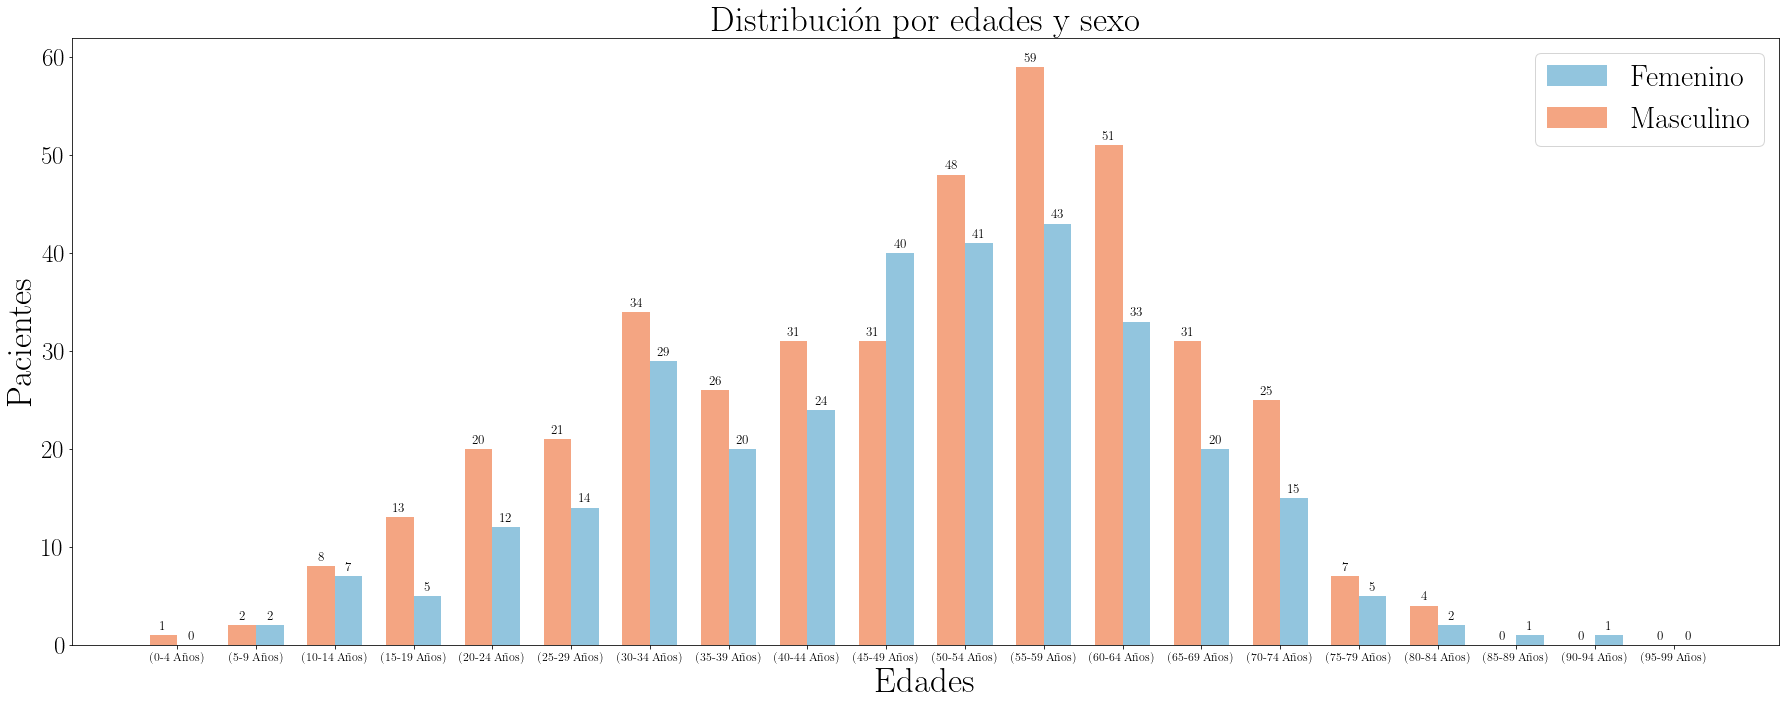

In [39]:
bb14EdSe = c14[c14['Image Index'].isin(bbx14['Image Index'])]
bb14EdSe = bb14EdSe[['Patient Age', 'Patient Gender', 'Patient ID']]
bb14EdSeBG = bb14EdSe.groupby(['Patient ID'])
EdSeCount = bb14EdSeBG.first()
men = np.zeros([len(c14[['Patient Age']].value_counts())])
women = np.zeros([len(c14[['Patient Age']].value_counts())])
men5s = np.zeros([20])
women5s = np.zeros([20])

for i in EdSeCount.index:
#     print(i,'  ',EdSeCount.loc[i]['Patient Gender'],'   ', EdSeCount.loc[i]['Patient Age'])
    if EdSeCount.loc[i]['Patient Gender'] == 'M':
        men[EdSeCount.loc[i]['Patient Age']] += 1
    elif EdSeCount.loc[i]['Patient Gender'] == 'F':
        women[EdSeCount.loc[i]['Patient Age']] += 1
    else:
        print('Genero de usuario {}, no identificado.'.format(i))
        
print('Gráficas generadas unicamente con la primera aparicion del paciente, a una edad especifica. \nEs decir un registro por paciente, de los {} pacientes únicos'.format(int(sum(men)+sum(women))))        
xticks = [i for i in range(len(c14[['Patient Age']].value_counts()))]
data = {'Femenino':women,
        'Masculino':men}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Personas'], fsizes = {'font':9,'axes':35,'xtick':13, 'ytick':25})

labels = []
for i in range(20):
    men5s[i] = sum(men[i*5:i*5+5])
    women5s[i] = sum(women[i*5:i*5+5])
    labels.append('({}-{} Años)'.format(i*5,i*5+4))
xticks = labels
data = {'Femenino':women5s,
        'Masculino':men5s}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Pacientes'], fsizes = {'font':13,'axes':35,'xtick':12, 'ytick':25}) #, png = '../Figures/ChestX-ray8/Images/BBPxES', pdf = '../Figures/ChestX-ray8/PDFs/BBPxES')

Gráficas con todos los registros de todos los pacientes, es decir el total de imagenes de Rayos-X, que es de: 880 imágenes.


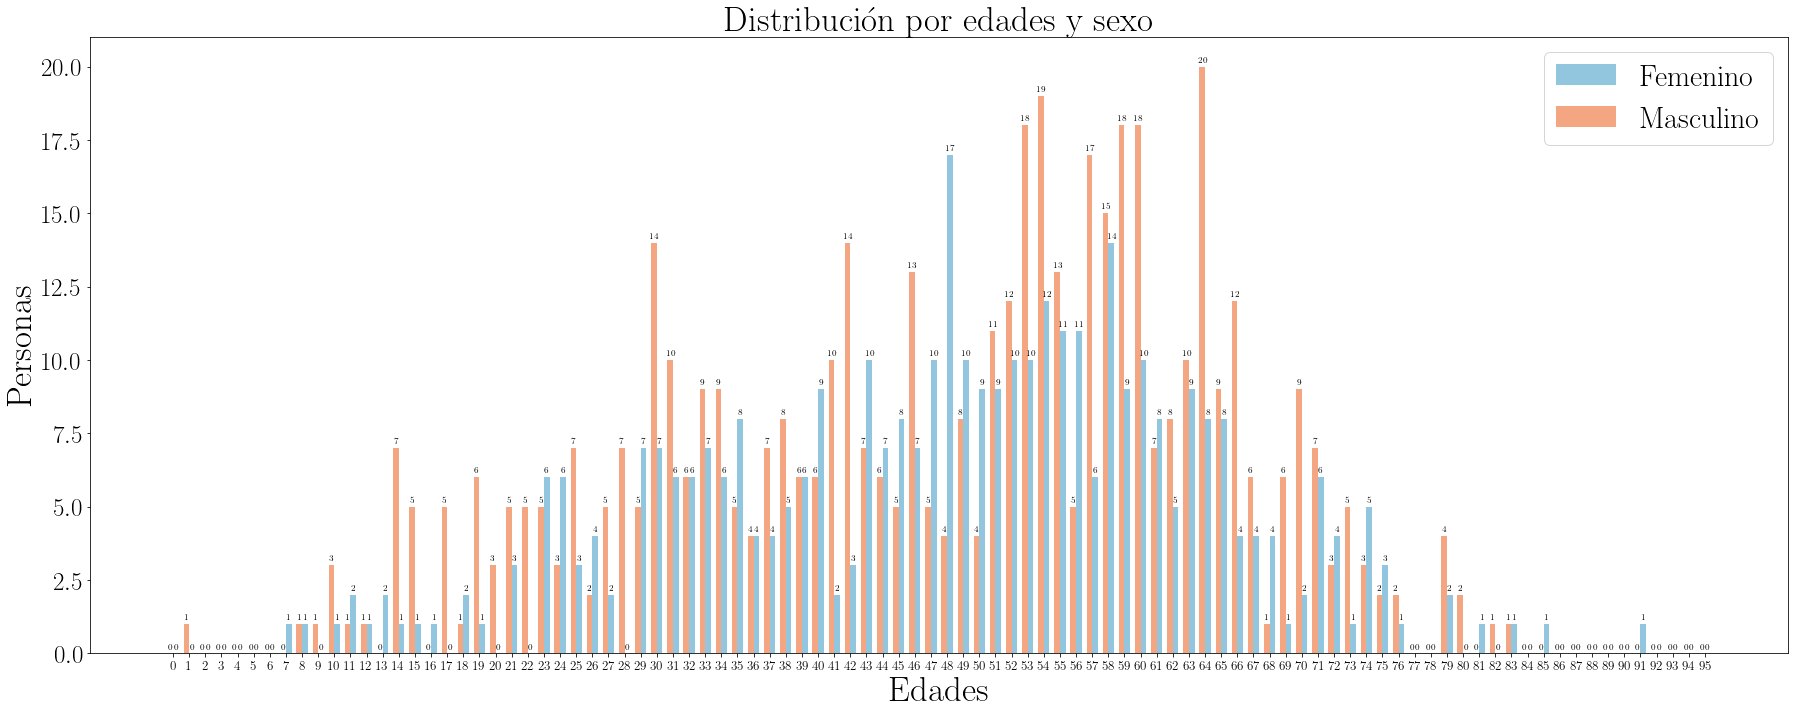

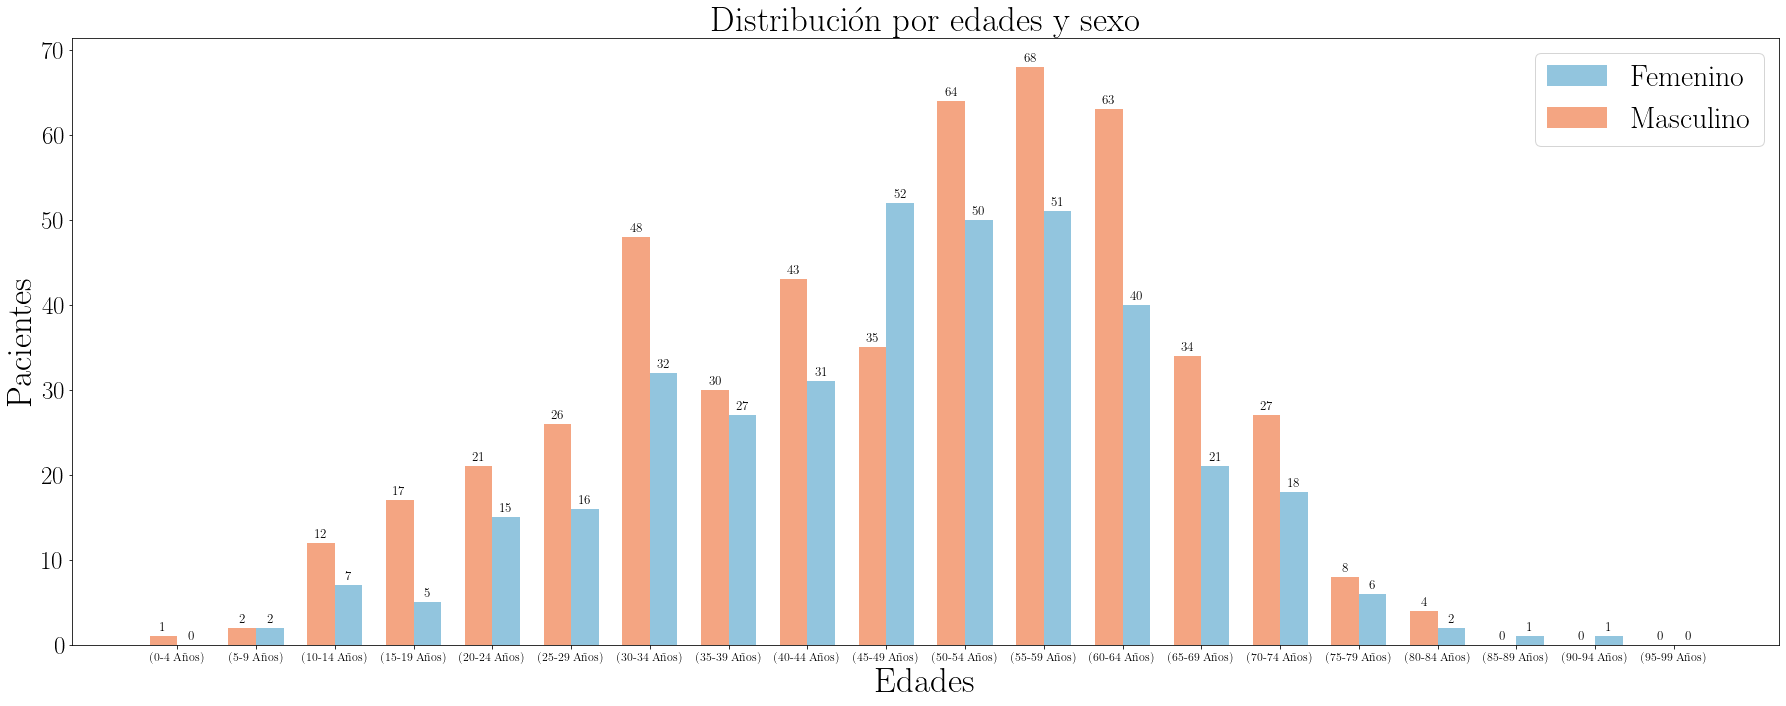

In [40]:
bb14EdSe = c14[c14['Image Index'].isin(bbx14['Image Index'])]
bb14EdSe = bb14EdSe[['Patient Age', 'Patient Gender', 'Patient ID']]
men = np.zeros([len(c14[['Patient Age']].value_counts())])
women = np.zeros([len(c14[['Patient Age']].value_counts())])
men5s = np.zeros([20])
women5s = np.zeros([20])

for i in bb14EdSe.index:
#     print(i,'  ',EdSeCount.loc[i]['Patient Gender'],'   ', EdSeCount.loc[i]['Patient Age'])
    if bb14EdSe.loc[i]['Patient Gender'] == 'M':
        men[bb14EdSe.loc[i]['Patient Age']] += 1
    elif bb14EdSe.loc[i]['Patient Gender'] == 'F':
        women[bb14EdSe.loc[i]['Patient Age']] += 1
    else:
        print('Genero de usuario {}, no identificado.'.format(i))
        
print('Gráficas con todos los registros de todos los pacientes, es decir el total de imagenes de Rayos-X, que es de: {} imágenes.'.format(int(sum(men)+sum(women))))        
xticks = [i for i in range(len(c14[['Patient Age']].value_counts()))]
data = {'Femenino':women,
        'Masculino':men}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Personas'], fsizes = {'font':9,'axes':35,'xtick':13, 'ytick':25})

labels = []
for i in range(20):
    men5s[i] = sum(men[i*5:i*5+5])
    women5s[i] = sum(women[i*5:i*5+5])
    labels.append('({}-{} Años)'.format(i*5,i*5+4))
xticks = labels
data = {'Femenino':women5s,
        'Masculino':men5s}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Pacientes'], fsizes = {'font':13,'axes':35,'xtick':12, 'ytick':25}) #, png = '../Figures/ChestX-ray8/Images/BBPxES2', pdf = '../Figures/ChestX-ray8/PDFs/BBPxES2')

Gráficas generadas con cada primer aparición de cada diferente edad de cada paciente. 
Es decir si un paciente tiene registros a diferentes edades, la primera a cada diferente edad se registra. 
Con esto se obtienen 764 registros


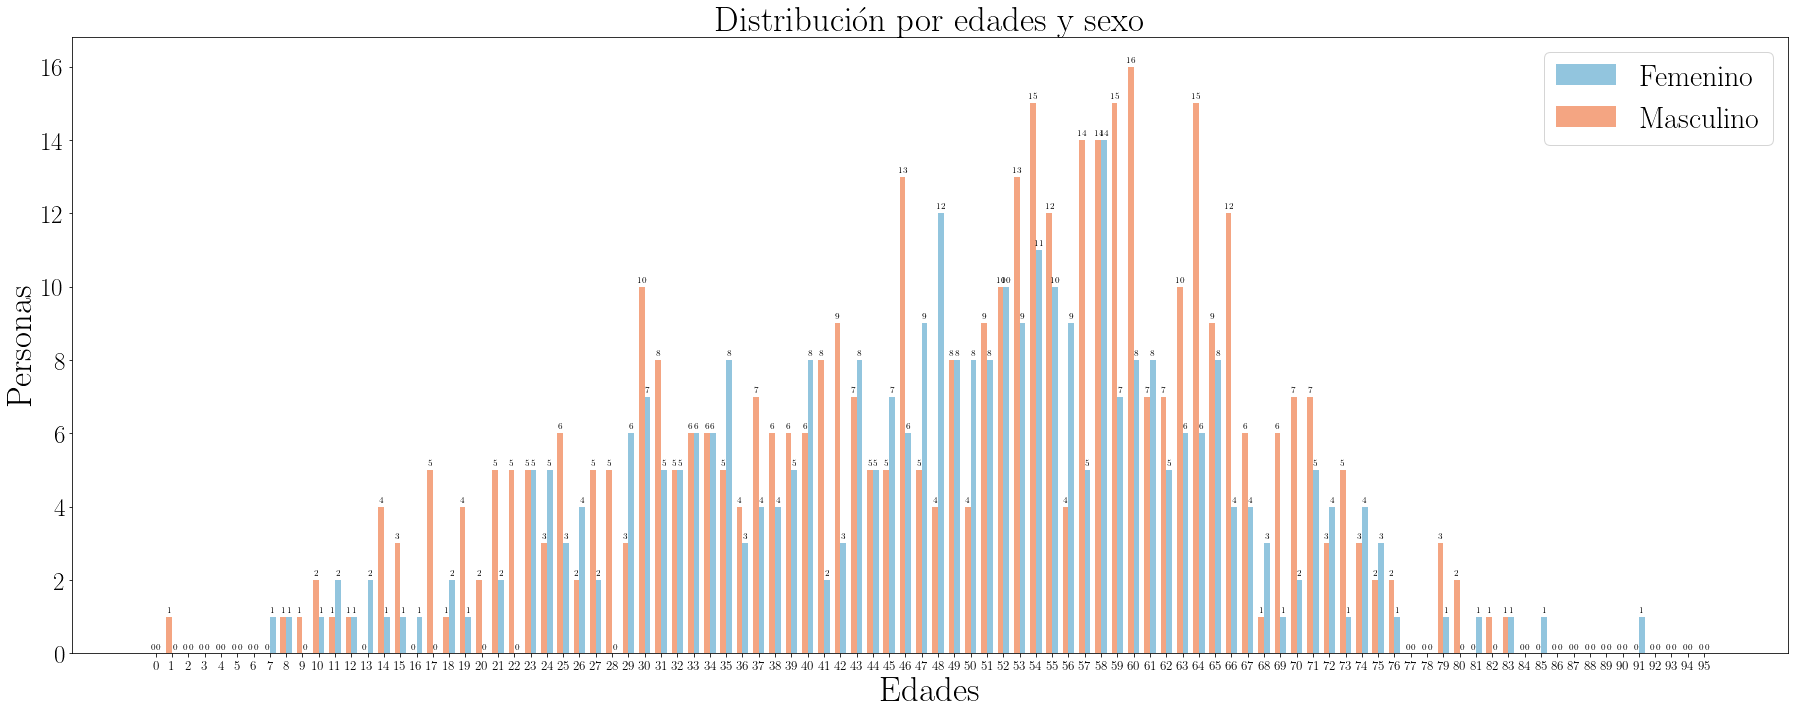

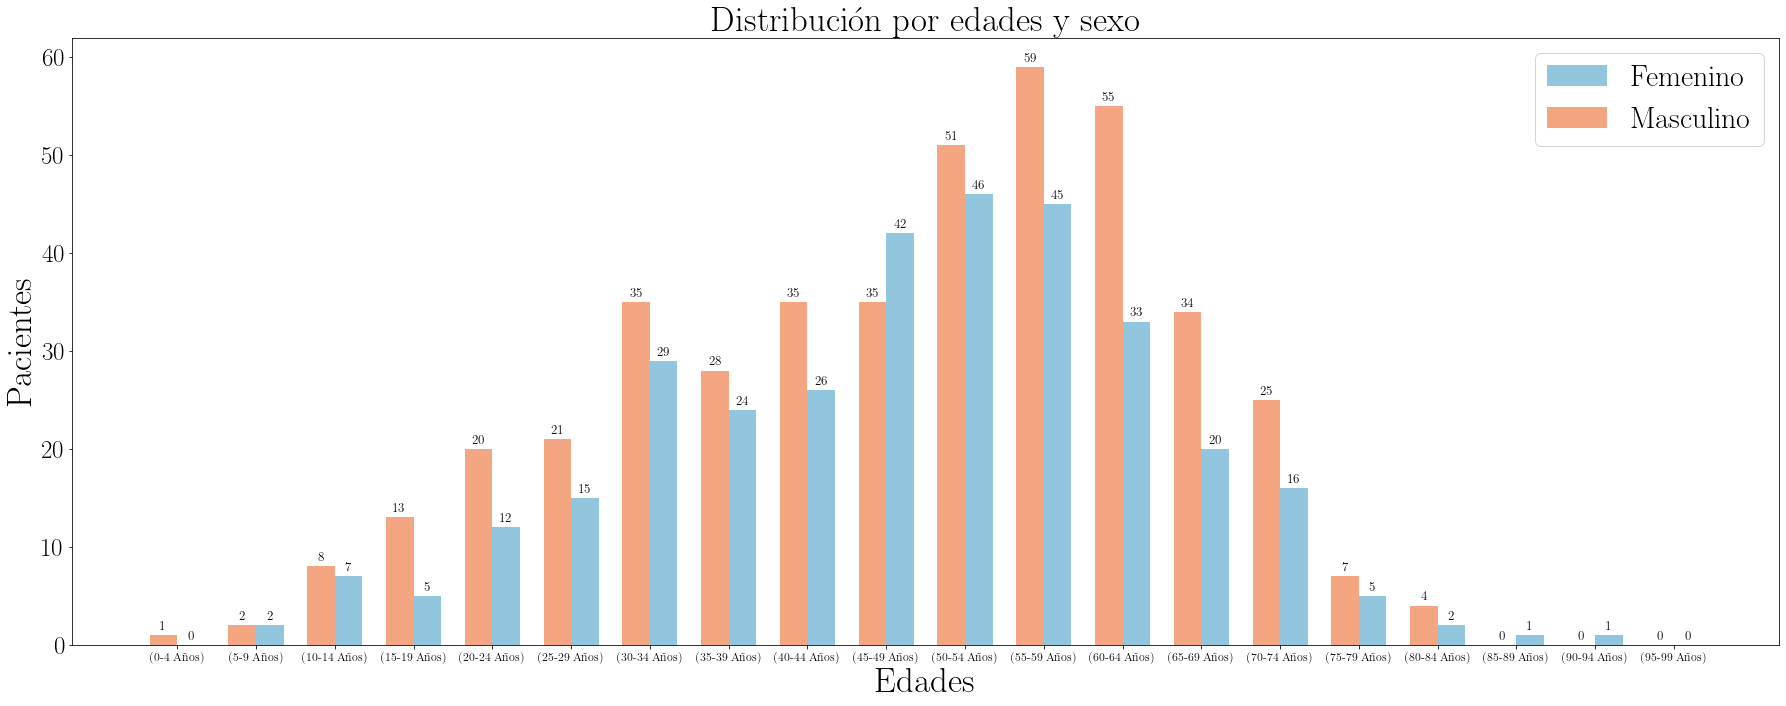

In [41]:
bb14EdSe = c14[c14['Image Index'].isin(bbx14['Image Index'])]
bb14EdSe = bb14EdSe[['Patient Age', 'Patient Gender', 'Patient ID']]
bb14EdSeBG = bb14EdSe.groupby(['Patient Age', 'Patient Gender', 'Patient ID'])
EdSeCount = bb14EdSeBG.first()#['Patient Gender']
# agecount = c14EdBG.first()['Patient Age'].value_counts()
EdSeCount = EdSeCount.reset_index()
men = np.zeros([len(c14[['Patient Age']].value_counts())])
women = np.zeros([len(c14[['Patient Age']].value_counts())])
men5s = np.zeros([20])
women5s = np.zeros([20])

for i in EdSeCount['Patient Age'].unique():
    try:
        men[i] = EdSeCount[EdSeCount['Patient Age'] == i][['Patient Gender']].value_counts()['M'] 
    except:
        pass
    try: 
        women[i] = EdSeCount[EdSeCount['Patient Age'] == i][['Patient Gender']].value_counts()['F']
    except:
        pass
 
print('Gráficas generadas con cada primer aparición de cada diferente edad de cada paciente. \nEs decir si un paciente tiene registros a diferentes edades, la primera a cada diferente edad se registra. \nCon esto se obtienen {} registros'.format(int(sum(men)+sum(women))))        
xticks = [i for i in range(len(c14[['Patient Age']].value_counts()))]
data = {'Femenino':women,
        'Masculino':men}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Personas'], fsizes = {'font':9,'axes':35,'xtick':13, 'ytick':25})

labels = []
for i in range(20):
    men5s[i] = sum(men[i*5:i*5+5])
    women5s[i] = sum(women[i*5:i*5+5])
    labels.append('({}-{} Años)'.format(i*5,i*5+4))
xticks = labels
data = {'Femenino':women5s,
        'Masculino':men5s}
groupedBarPlot(data, xticks, 'Distribución por edades y sexo',axislabels = ['Edades','Pacientes'], fsizes = {'font':13,'axes':35,'xtick':12, 'ytick':25}) #, png = '../Figures/ChestX-ray8/Images/BBPxES3', pdf = '../Figures/ChestX-ray8/PDFs/BBPxES3')

In [42]:
size = len(bbx14[['Image Index']].value_counts())
ccmprep = pads = {'Cardiomegalia': np.zeros([size]),
                  'Derrame pleural':np.zeros([size]),
                  'Infiltración':np.zeros([size]),
                  'Masa':np.zeros([size]),
                  'Nódulo':np.zeros([size]), 
                  'Atelectasia':np.zeros([size]), 
                  'Neumotórax':np.zeros([size]),
                  'Neumonía':np.zeros([size])}
type(list(bbx14['Image Index'].value_counts().index))
CCM = pd.DataFrame(ccmprep)
CCM = CCM.set_index(pd.Index(list(bbx14['Image Index'].value_counts().index)))

for i,j in enumerate(bbx14['Image Index']):
    CCM.loc[j][labsmap[bbx14['Finding Label'].iloc[i]]] = 1
CCM

Cardiomegalia  Derrame pleural  Infiltración  Masa  Nódulo  \
00010277_000.png            0.0              1.0           1.0   1.0     0.0   
00008814_010.png            0.0              1.0           1.0   0.0     0.0   
00018253_059.png            0.0              1.0           1.0   0.0     0.0   
00018427_004.png            0.0              1.0           0.0   1.0     0.0   
00020482_032.png            0.0              1.0           1.0   0.0     0.0   
...                         ...              ...           ...   ...     ...   
00000756_001.png            1.0              0.0           0.0   0.0     0.0   
00008522_032.png            1.0              0.0           0.0   0.0     0.0   
00005532_000.png            1.0              0.0           0.0   0.0     0.0   
00030206_013.png            1.0              0.0           0.0   0.0     0.0   
00026920_000.png            0.0              0.0           0.0   0.0     0.0   

                  Atelectasia  Neumotórax  Neumonía  
00010277_000.png          0.0         0.0       1.0  
00008814_010.png          1.0         0.0       0.0  
00018253_059.png          1.0         0.0       0.0  
00018427_004.png          1.0         0.0       0.0  
00020482_032.png          1.0         0.0       0.0  
...                       ...         ...       ...  
00000756_001.png          0.0         0.0       0.0  
00008522_032.png          0.0         0.0       0.0  
00005532_000.png          0.0         0.0       0.0  
00030206_013.png          0.0         0.0       0.0  
00026920_000.png          1.0         0.0       0.0  

[880 rows x 8 columns]

In [43]:
coocc = CCM.T.dot(CCM)
coocc

Cardiomegalia  Derrame pleural  Infiltración  Masa  Nódulo  \
Cardiomegalia            146.0              2.0           4.0   0.0     0.0   
Derrame pleural            2.0            153.0          25.0   6.0     0.0   
Infiltración               4.0             25.0         123.0   4.0     0.0   
Masa                       0.0              6.0           4.0  85.0     0.0   
Nódulo                     0.0              0.0           0.0   0.0    79.0   
Atelectasia                0.0             20.0           6.0  11.0     0.0   
Neumotórax                 1.0              4.0           1.0   3.0     3.0   
Neumonía                   5.0              3.0          13.0   3.0     0.0   

                 Atelectasia  Neumotórax  Neumonía  
Cardiomegalia            0.0         1.0       5.0  
Derrame pleural         20.0         4.0       3.0  
Infiltración             6.0         1.0      13.0  
Masa                    11.0         3.0       3.0  
Nódulo                   0.0         3.0       0.0  
Atelectasia            180.0         0.0       0.0  
Neumotórax               0.0        98.0       2.0  
Neumonía                 0.0         2.0     120.0

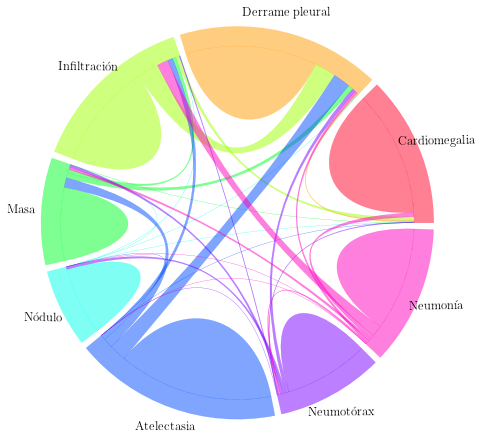

In [44]:
fig = plt.figure(figsize=(6,6))
flux = coocc.to_numpy()

ax = plt.axes([0,0,1,1])
cmap = cm.get_cmap('gist_rainbow', 8)  
crgb =  [cmap(i)[:3] for i in range(cmap.N)]#[hex2rgb(i) for i in c1]
#nodePos = chordDiagram(flux, ax, colors=[hex2rgb(x) for x in ['#666666', '#66ff66', '#ff6666', '#6666ff']])
nodePos = chordDiagram(flux, ax, colors = crgb) #, png = '../Figures/ChestX-ray8/Images/BBDCuerdas', pdf = '../Figures/ChestX-ray8/PDFs/BBDCuerdas')
ax.axis('off')
prop = dict(fontsize=16*0.8, ha='center', va='center')
nodes = ['Cardiomegalia','Derrame pleural','Infiltración','Masa','Nódulo','Atelectasia','Neumotórax', 'Neumonía']
for i in range(len(nodes)):
    ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][0], **prop)

ax.patch.set_alpha(0.0)
plt.savefig('../Figures/ChestX-ray8/Images/BBDCuerdas.png', transparent=True, bbox_inches='tight')
plt.savefig('../Figures/ChestX-ray8/PDFs/BBDCuerdas.pdf', transparent=True, bbox_inches='tight')
# plt.savefig("example.png", dpi=600,
#         transparent=True,
#         bbox_inches='tight', pad_inches=0.02)

Matrices sin hallazgo incluido


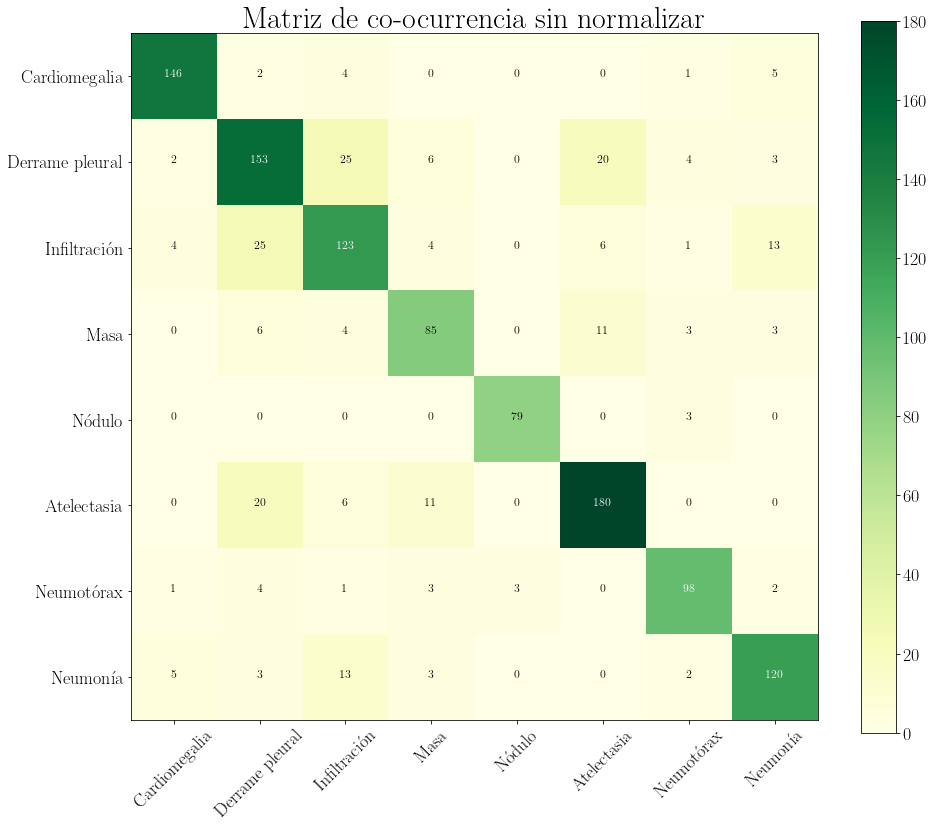

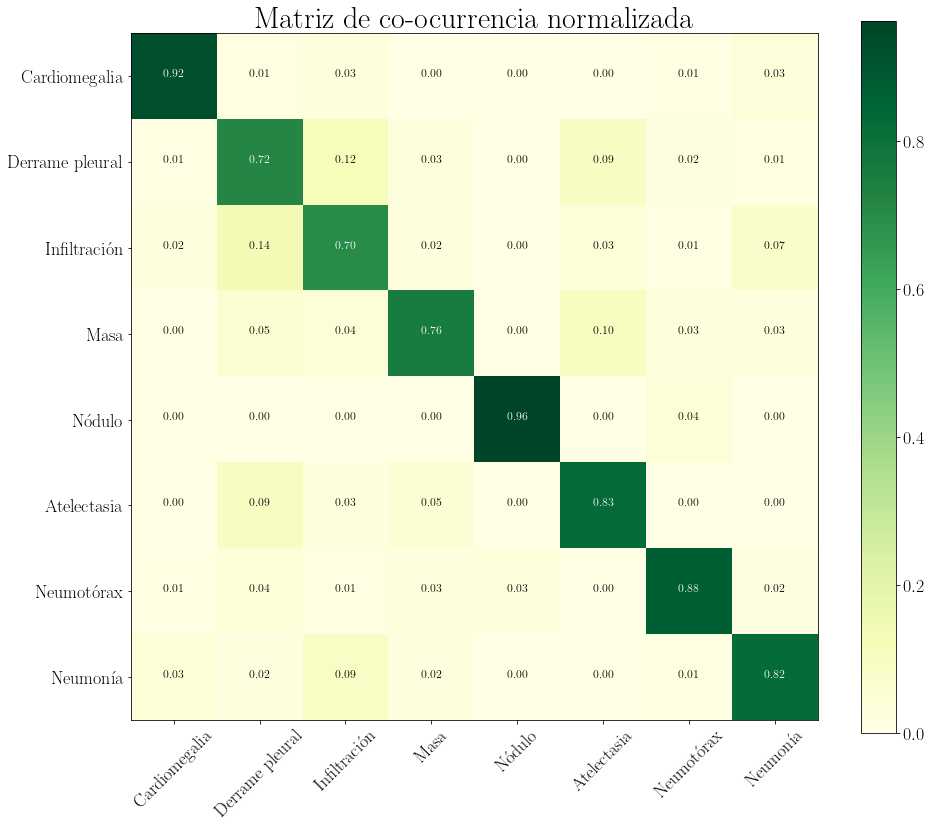

In [45]:
objects = ['Cardiomegalia','Derrame pleural','Infiltración','Masa','Nódulo','Atelectasia','Neumotórax','Neumonía']#,'Sin Hallazgo']
print('Matrices sin hallazgo incluido')
plot_confusion_matrix(coocc.to_numpy(), classes=objects, normalize=False, colors = plt.cm.YlGn, tit = 'Matriz de co-ocurrencia sin normalizar', axisLabels = ['',''], fsizes = {'font':12,'axes':30,'xtick':18, 'ytick':18}) #, png = '../Figures/ChestX-ray8/Images/BBCMNN', pdf = '../Figures/ChestX-ray8/PDFs/BBCMNN')
plot_confusion_matrix(coocc.to_numpy(), classes=objects, normalize=True, colors = plt.cm.YlGn, tit = 'Matriz de co-ocurrencia normalizada', axisLabels = ['',''], fsizes = {'font':12,'axes':30,'xtick':18, 'ytick':18}) #, png = '../Figures/ChestX-ray8/Images/BBCMN', pdf = '../Figures/ChestX-ray8/PDFs/BBCMN')

In [46]:
# locs = pd.read_csv('/content/train_val_list.txt', delimiter = "\t")
# locs

In [47]:
# locsdef = pd.read_csv('/content/test_list.txt', delimiter = "\t")
# locsdef

In [48]:
cmap = cm.get_cmap('gist_rainbow', 8)  
crgb =  [cmap(i)[:3] for i in range(cmap.N)]
mapping = read_json(pathlib.Path('LabelsMappping.json'))
mappingR = {v:k for k,v in mapping.items()}
mappingC = {j:crgb[i] for i, j in enumerate(mapping.keys())}


# Directorio de las imagenes y las etiquetas
root = pathlib.Path('../data/ChestXRay8')
# Cargar imágenes y etiquetas
inputs = get_filenames_of_path(root / 'ChestBBImages')
targets = get_filenames_of_path(root / 'ChestBBLabels')

inputs.sort()
targets.sort()

# Transformaciones, ajustar formato, normalizar a m: 0 y std: 1
transforms = ComposeDouble([
    Clip(),
    # AlbumentationWrapper(albumentation=A.HorizontalFlip(p=0.5)),
    # AlbumentationWrapper(albumentation=A.RandomScale(p=0.5, scale_limit=0.5)),
    # AlbumentationWrapper(albumentation=A.VerticalFlip(p=0.5)),
#     FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# Contruir el Conjunto de Datos
dataset = ObjectDetectionDataSet(inputs=inputs,
                                 targets=targets,
                                 transform=transforms,
                                 add_dim = False,
                                 use_cache=False,
                                 convert_to_format=None,
                                 mapping=mapping,
                                 tgt_int64=True)

In [49]:
ImgsN = ['00000457_004','00001534_005','00004342_050','00004344_002','00005066_030','00005089_014','00006736_000','00008291_011','00008814_010','00018253_059','00020482_032','00010828_039','00009437_008','00009889_018','00014014_013','00025962_000','00010277_000','00009683_005']
Phrs = ['Ejemplo Atelectasia con objetos raros en el área de la columna',
        'Cardiomegalia usualmente area grande',
        'Pneumotorax usualmente rectangulo vertical',
        'Pneumonia usualmente rectangulo vertical',
        'Ejemplo 3 cajas delimitadoras',
        'Atelectasia usualmente rectangulo horizontal',
        'Nodulo area usualmente muy puqueña',
        'Etiquetado de Neumonia de area muy grande',
        'Infiltración, Atelectasia y Derrame Pleural casi en la misma zona',
        'Infiltración, Atelectasia y Derrame Pleural casi en la misma zona 2',
        'Infiltración, Atelectasia y Derrame Pleural casi en la misma zona 3',
        'Infiltración, Atelectasia y Derrame Pleural casi en la misma zona 4',
        'Atelectasia y Derrame pleural a en la misma zona',
        'Pneumotorax de área muy pequeña',
        'Radiografía con parte inferior blanca',
        'Radiografía con parte inferior blanca 2',
        'Única radiografía con 4 padecimientos identificados',
        'Radiografía de vista lateral']
InXRays = [i + '.png' for i in ImgsN]
InLabs = [i + '.json' for i in ImgsN]
ind = []
for i in range(len(dataset)):
    if dataset[i]['x_name'] in InXRays:
#         print(dataset[i]['x_name'],i)
        ind.append(i)
inds = [14,41,91,92,113,115,131,160,170,220,506,598,184,195,728,351,204,190]
ind

[14,
 41,
 91,
 92,
 113,
 115,
 131,
 160,
 170,
 184,
 190,
 195,
 204,
 220,
 351,
 506,
 598,
 728]

In [50]:
dataset[204]

{'x': tensor([[0.9922, 0.9843, 0.9765,  ..., 0.9765, 1.0000, 0.5804],
         [0.9804, 0.9686, 0.9765,  ..., 0.9647, 1.0000, 0.5804],
         [0.9725, 0.9686, 0.9647,  ..., 0.9451, 1.0000, 0.5804],
         ...,
         [0.1529, 0.1333, 0.1176,  ..., 0.0745, 0.0314, 0.0000],
         [0.1529, 0.1294, 0.1137,  ..., 0.0745, 0.0314, 0.0000],
         [0.1529, 0.1333, 0.1216,  ..., 0.0745, 0.0314, 0.0000]]),
 'y': {'boxes': tensor([[633, 416, 905, 638],
          [642, 423, 907, 646],
          [297, 310, 837, 588],
          [863, 693, 935, 805]]),
  'labels': tensor([0, 2, 6, 4])},
 'x_name': '00010277_000.png',
 'y_name': '00010277_000.json'}

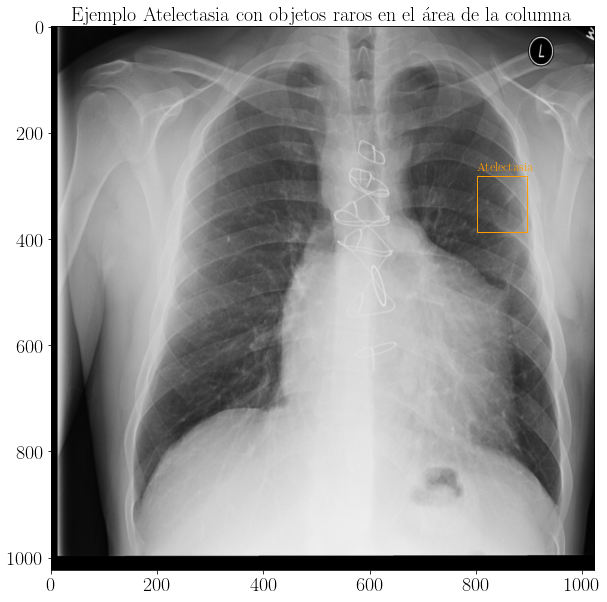

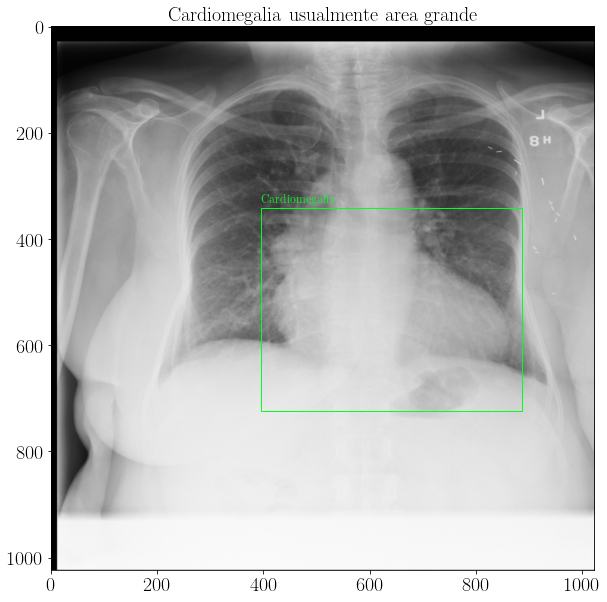

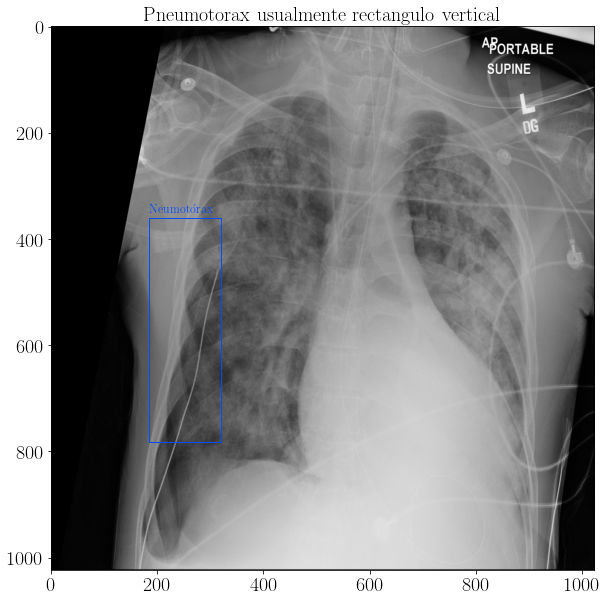

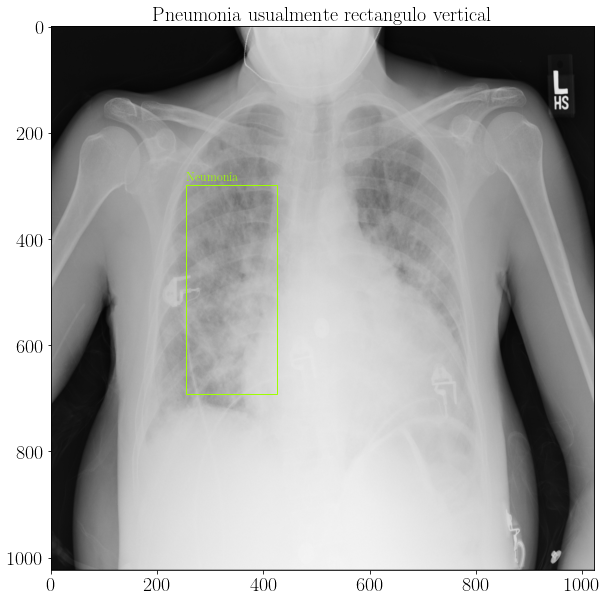

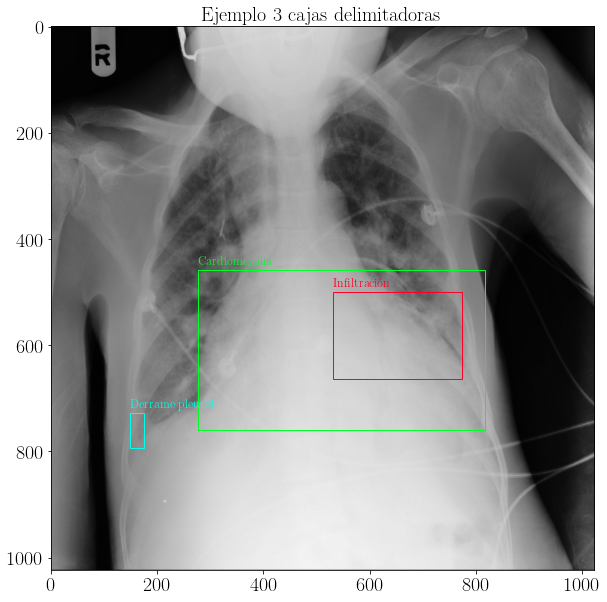

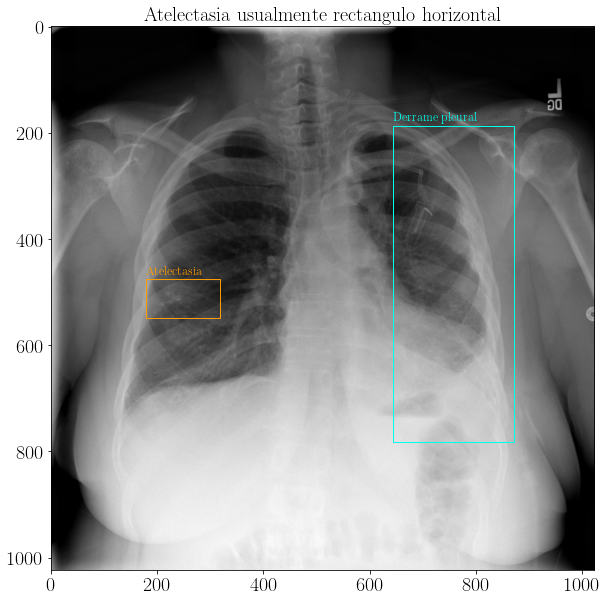

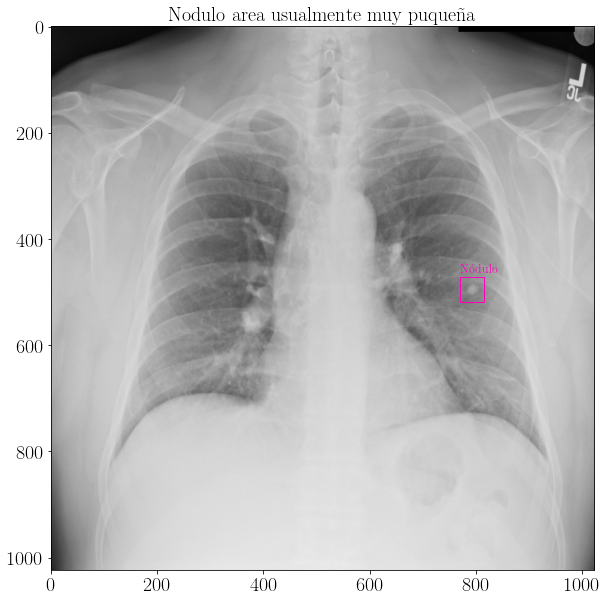

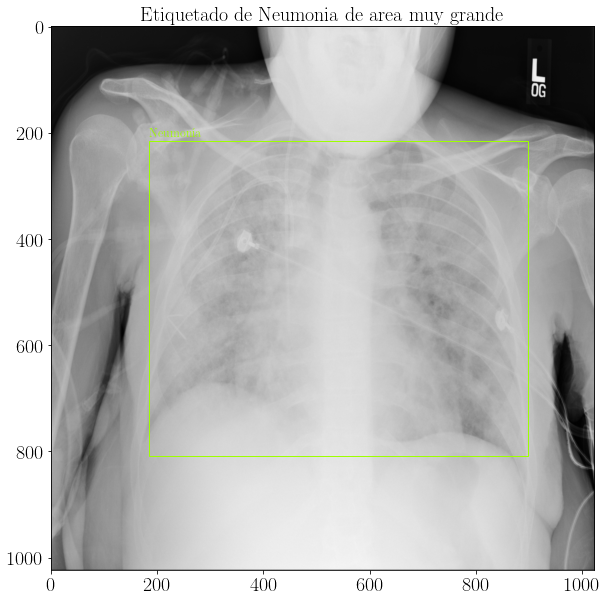

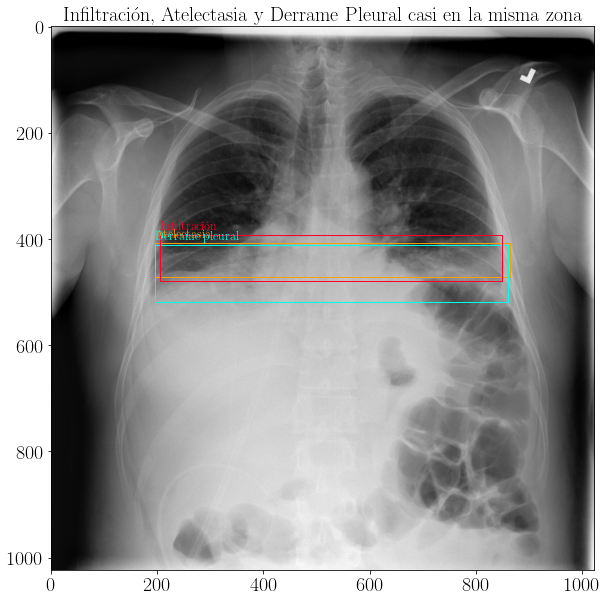

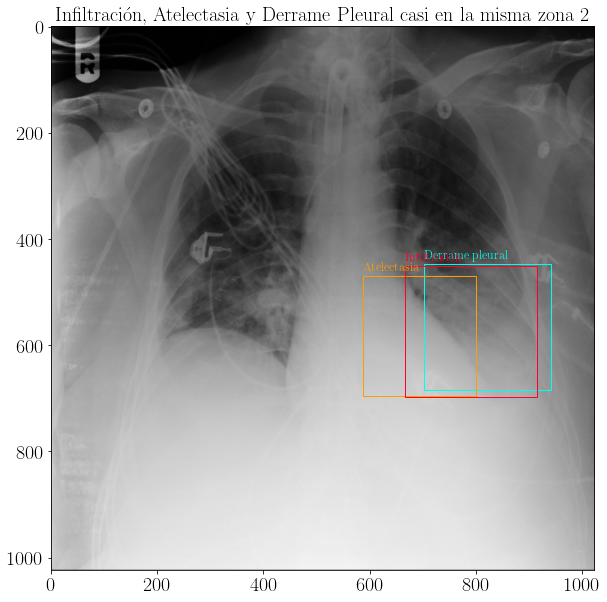

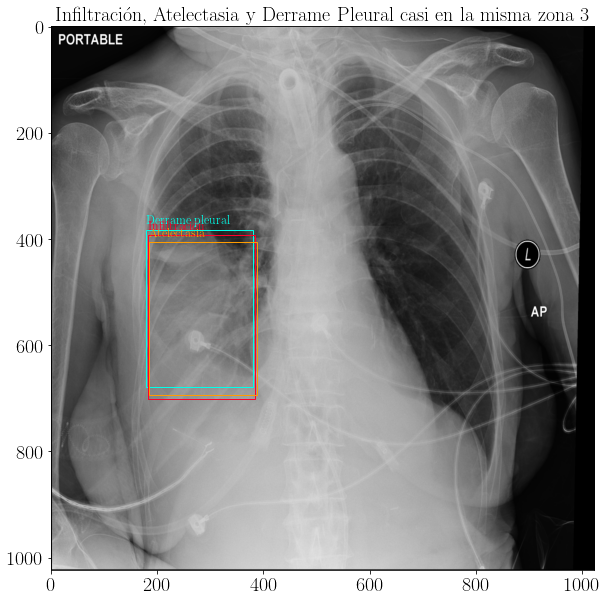

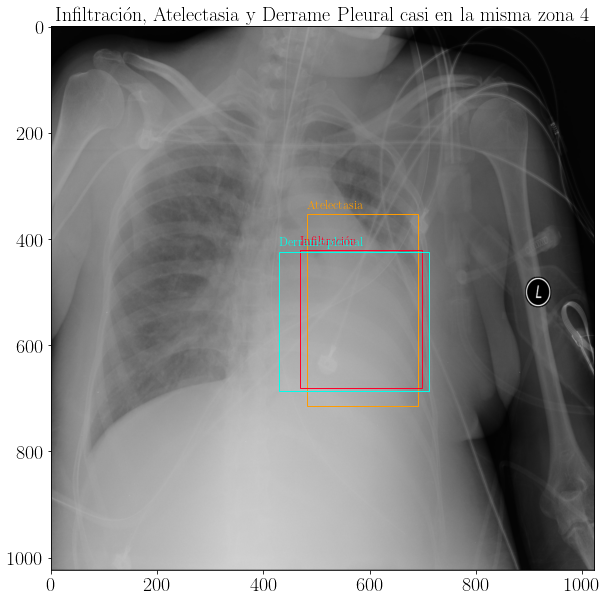

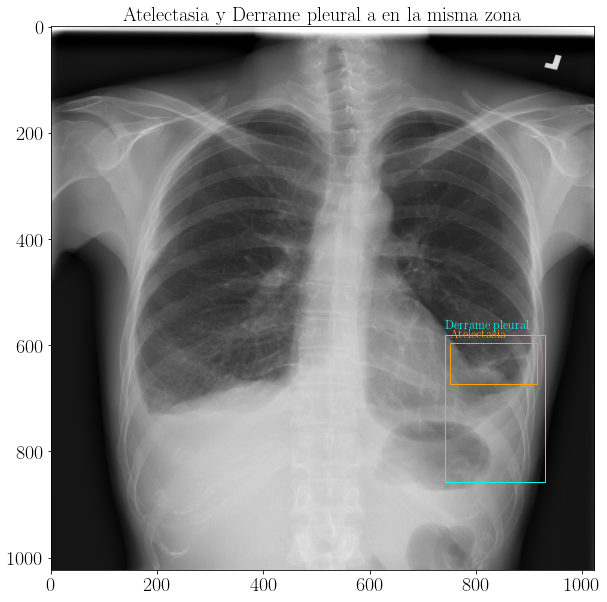

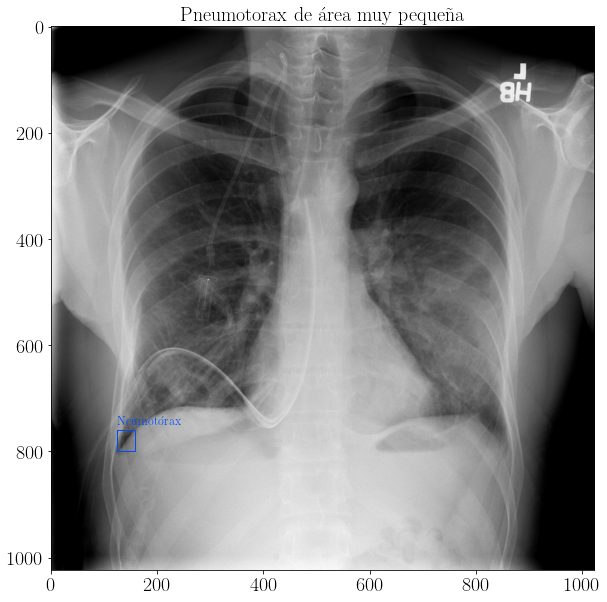

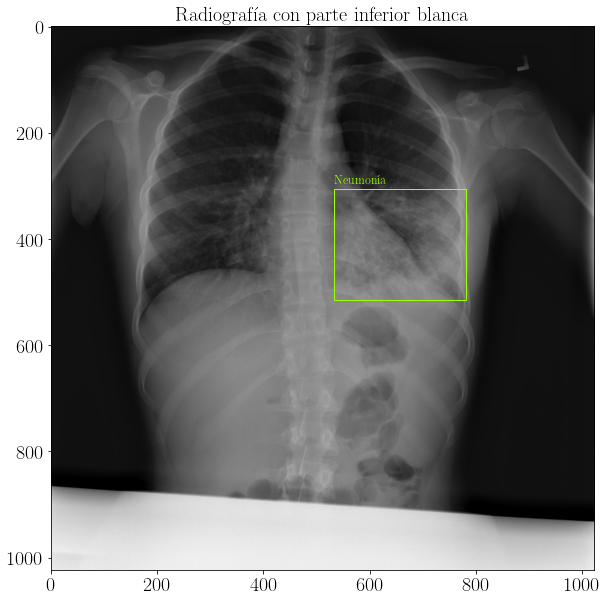

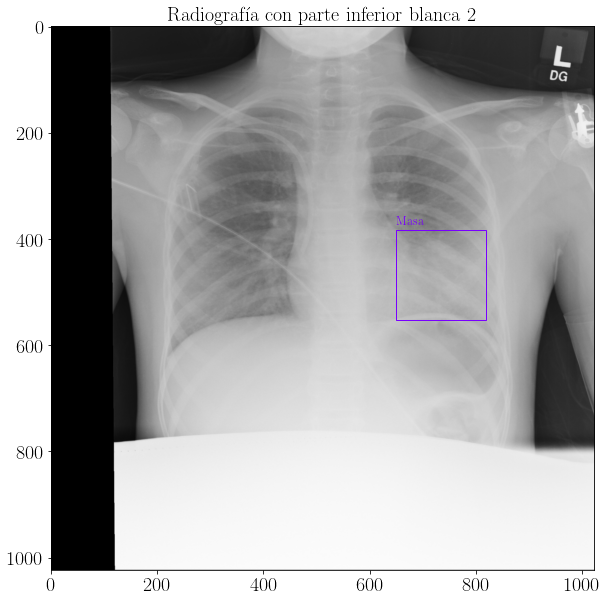

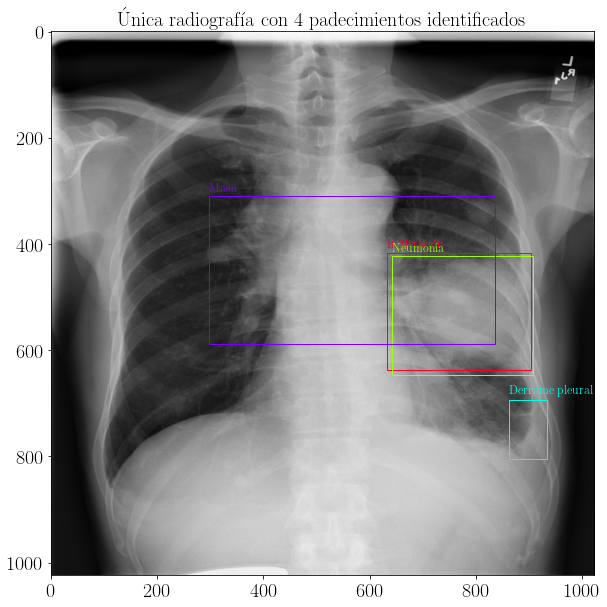

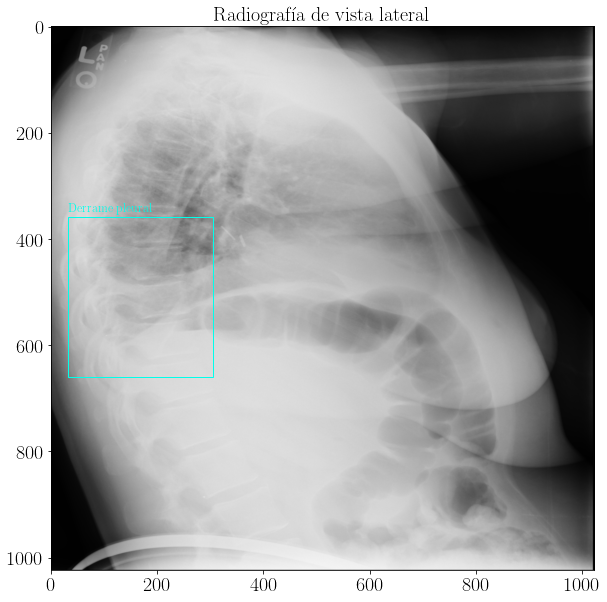

In [51]:
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
for c,i in enumerate(inds):
    figure, ax = plt.subplots(1,figsize=[10,10])
    img1 = np.zeros([1024,1024,3]) 
    img1[:,:,0] = dataset[i]['x']
    img1[:,:,1] = dataset[i]['x']
    img1[:,:,2] = dataset[i]['x']
    ax.imshow(img1)
    plt.title(Phrs[c])
    for j in range(len(dataset[i]['y']['labels'])):
        rect = patches.Rectangle((dataset[i]['y']['boxes'][j][0],dataset[i]['y']['boxes'][j][1]),dataset[i]['y']['boxes'][j][2]-dataset[i]['y']['boxes'][j][0],dataset[i]['y']['boxes'][j][3]-dataset[i]['y']['boxes'][j][1], edgecolor=mappingC[mappingR[int(dataset[i]['y']['labels'][j])]], facecolor="none")
        ax.add_patch(rect)
        ax.text(dataset[i]['y']['boxes'][j][0], dataset[i]['y']['boxes'][j][1]-10, labsmap[mappingR[int(dataset[i]['y']['labels'][j])]], color = mappingC[mappingR[int(dataset[i]['y']['labels'][j])]])
        
    plt.savefig('../Figures/ChestX-ray8/PDFs/' + Phrs[c] + '.pdf', transparent=True, bbox_inches='tight')
    plt.savefig('../Figures/ChestX-ray8/Images/' + Phrs[c] + '.png', transparent=True, bbox_inches='tight')
# plt.show()

## VinDr-CXR Dataset

In [4]:
vin = pd.read_csv('../VinDR-CXR-Data/train.csv')
vinp = vin.copy()
vinp.dropna(inplace=True)
vin

image_id          class_name  class_id rad_id  \
0      50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1      21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2      9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3      051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4      063319de25ce7edb9b1c6b8881290140          No finding        14    R10   
...                                 ...                 ...       ...    ...   
67909  936fd5cff1c058d39817a08f58b72cae          No finding        14     R1   
67910  ca7e72954550eeb610fe22bf0244b7fa          No finding        14     R1   
67911  aa17d5312a0fb4a2939436abca7f9579          No finding        14     R8   
67912  4b56bc6d22b192f075f13231419dfcc8        Cardiomegaly         3     R8   
67913  5e272e3adbdaafb07a7e84a9e62b1a4c          No finding        14    R16   

        x_min   y_min   x_max   y_max  
0         NaN     NaN     NaN     NaN  
1         NaN     NaN     NaN     NaN  
2       691.0  1375.0  1653.0  1831.0  
3      1264.0   743.0  1611.0  1019.0  
4         NaN     NaN     NaN     NaN  
...       ...     ...     ...     ...  
67909     NaN     NaN     NaN     NaN  
67910     NaN     NaN     NaN     NaN  
67911     NaN     NaN     NaN     NaN  
67912   771.0   979.0  1680.0  1311.0  
67913     NaN     NaN     NaN     NaN  

[67914 rows x 8 columns]

In [4]:
sampsub = pd.read_csv('../VinDR-CXR-Data/sample_submission.csv')
sampsub

image_id PredictionString
0     002a34c58c5b758217ed1f584ccbcfe9     14 1 0 0 1 1
1     004f33259ee4aef671c2b95d54e4be68     14 1 0 0 1 1
2     008bdde2af2462e86fd373a445d0f4cd     14 1 0 0 1 1
3     009bc039326338823ca3aa84381f17f1     14 1 0 0 1 1
4     00a2145de1886cb9eb88869c85d74080     14 1 0 0 1 1
...                                ...              ...
2995  ff91fb82429a27521bbec8569b041f02     14 1 0 0 1 1
2996  ff9fcc4087ed5e941209aa3fa948e364     14 1 0 0 1 1
2997  ffaa288c8abca300974f043b57d81521     14 1 0 0 1 1
2998  ffc441e0c8b7153844047483a577e7c3     14 1 0 0 1 1
2999  ffccf1709d0081d122a1d1f9edbefdf1     14 1 0 0 1 1

[3000 rows x 2 columns]

In [10]:
vin[vin['image_id'] == '50a418190bc3fb1ef1633bf9678929b3'] # '4b56bc6d22b192f075f13231419dfcc8']

image_id  class_name  class_id rad_id  x_min  \
0      50a418190bc3fb1ef1633bf9678929b3  No finding        14    R11    NaN   
45863  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R15    NaN   
57424  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R16    NaN   

       y_min  x_max  y_max  
0        NaN    NaN    NaN  
45863    NaN    NaN    NaN  
57424    NaN    NaN    NaN

In [5]:
# numero del numero de padecimeintos por imagen - 1
vimages = vin['image_id'].unique()
print('Total de imágenes: {}'.format(len(vimages)))
print('Total de imágenes con al menos un padecimeinto detectado: {} '.format(len(vinp['image_id'].unique())))
vinIU = vin['image_id'].value_counts()
print('Total de etiquetas asignadas: ', sum(len(vin)))
lqpi = vinIU.value_counts().sort_index()
print('Todas las imágenes tienen al menos 3 etiquetas ya que cada una fue etiquetada por 3 radiologos distintos\n')
print(lqpi)

# Obtener porcentajes respecto al número de padecimeintos por imágen
nlind =  list(lqpi.index)
nlraw = list(lqpi.copy())
nlnorm = [float(i)/sum(nlraw) for i in nlraw]

Total de imágenes: 15000
Total de imágenes con al menos un padecimeinto detectado: 4394 
Total de etiquetas asignadas:  67914
Todas las imágenes tienen al menos 3 etiquetas ya que cada una fue etiquetada por 3 radiologos distintos

3     10976
4       431
5       550
6       725
7       430
8       383
9       303
10      227
11      176
12      149
13      124
14      103
15       84
16       48
17       66
18       38
19       36
20       31
21       22
22       20
23       15
24        9
25        4
26        9
27        4
28        9
29        4
30        4
31        4
32        3
33        1
35        1
39        3
40        1
42        1
46        3
48        1
52        1
57        1
Name: image_id, dtype: int64


La categoría de 3 etiquetas incluye también las de "sin hallazgo"


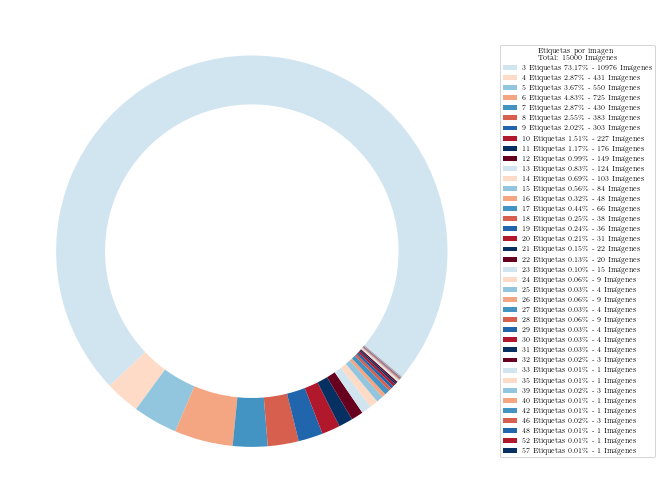

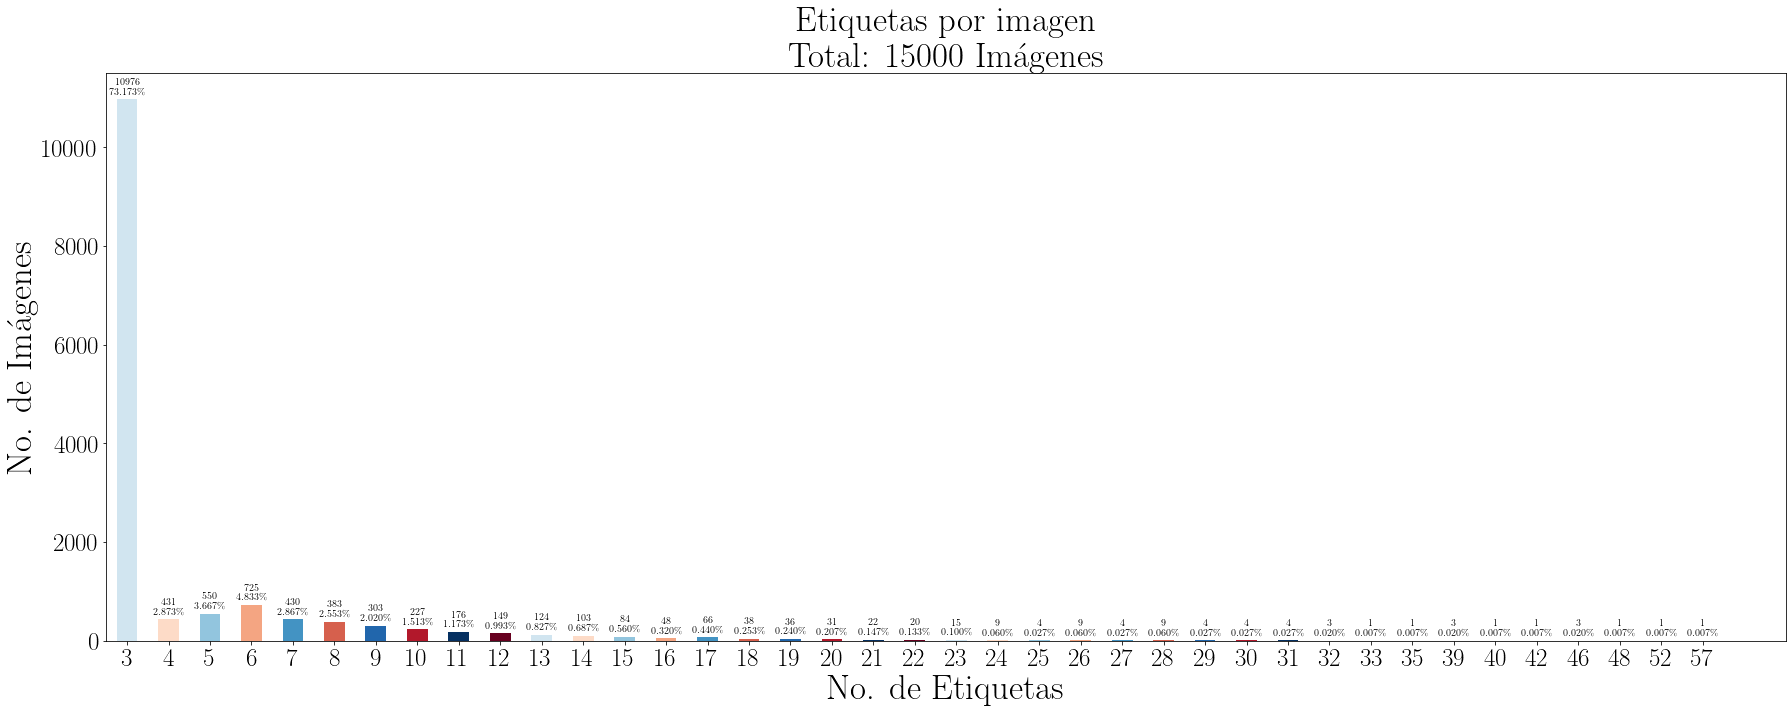

In [7]:
labels =  ['{} Etiquetas {:.2f}\% - {} Imágenes'.format(nlind[i],nlnorm[i]*100,nlraw[i]) if nlind[i] != 1 else '{} Etiqueta {:.2f}\% - {} Imágenes'.format(i+1,nlnorm[i]*100,nlraw[i]) for i in range(len(nlraw))]
data =  nlraw.copy()
title = "   Etiquetas por imagen \n Total: {} Imágenes".format(sum(data))
print('La categoría de 3 etiquetas incluye también las de "sin hallazgo"')
donutPlot(data,labels,title,fontset=7)

# labels = ['1 Etiqueta {:.2f}% \n  {} Imágenes'.format(nlnorm[0]*100,nlraw[0]), '2 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[1]*100, nlraw[1]), '3 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[2]*100, nlraw[2]), '4 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[3]*100, nlraw[3]),
# '5 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[4]*100,nlraw[4]), '6 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[5]*100, nlraw[5]), '7 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[6]*100,nlraw[6]), '8 Etiquetas {:.4f}% \n {} Imágenes'.format(nlnorm[7]*100,nlraw[7]), '9 Etiquetas {:.4f}% \n {} Imágenes'.format(nlnorm[8]*100,nlraw[8])]
# labels  = ['{} Etiqueta'.format(nlind[i]) if nlind[i] == 1 else '{} Etiquetas'.format(nlind[i]) for i in range(len(nlraw))]
labels  = ['{}'.format(nlind[i]) if nlind[i] == 1 else '{}'.format(nlind[i]) for i in range(len(nlraw))]

data = {'Padecimientos':nlraw.copy()}
groupedBarPlot(data,labels,title, width = 0.5, legend = False,figsize=(25,10), barLabel=['{}\n{:.3f}\%',[n*100 for n in nlnorm]],fsizes = {'font':10,'axes':35,'xtick':25, 'ytick':25}, axisLim = {'xlim':[-0.5,40], 'ylim':[0,11500]},axislabels=['No. de Etiquetas','No. de Imágenes']) #, png = '../Figures/VinDr-CXR/Images/ExM', pdf = '../Figures/VinDr-CXR/PDFs/ExM')

In [8]:
cLabs = list(vin.value_counts(['image_id']))
q  = len(vin['class_name'].unique())
print('Para el conjunto de datos total con todas las etiquetas, incluso los casos "Sin Hallazgo"')
print('\t\t*** Inluyendo las redundancias del etiquetado *** \n')

print('La cardinalidad de las etiquetas en el conjunto es: ', LabelCardinality(cLabs))
print('La densidad de las etiquetas en el conjunto es: ', LabelDensity(cLabs, q))

pss = []
lblsimg = {}
for num,im in enumerate(vin['image_id']):
    if im in pss:
        lblsimg[im].add(vin.iloc[num]['class_name'])
    else:
        lblsimg[im] = set()
        lblsimg[im].add(vin.iloc[num]['class_name'])
        pss.append(im)
difflb = []
for i in list(lblsimg.values()):
    if i not in difflb:
        difflb.append(i)
print('El número de conjuntos de etiquetas distintos es:', len(difflb))    

Para el conjunto de datos total con todas las etiquetas, incluso los casos "Sin Hallazgo"
		*** Inluyendo las redundancias del etiquetado *** 

La cardinalidad de las etiquetas en el conjunto es:  4.5276000000000005
La densidad de las etiquetas en el conjunto es:  0.30184000000000005
El número de conjuntos de etiquetas distintos es: 1012


In [9]:
#Para obtener el correcto número de etiquetas distintas por imagen debemos eliminar la redundancia de etiquetados
pb = vin.copy().groupby(['image_id', 'class_id']).first().sort_index().loc['4b56bc6d22b192f075f13231419dfcc8']
pb

class_name rad_id   x_min   y_min   x_max   y_max
class_id                                                           
0         Aortic enlargement     R8  1070.0   392.0  1374.0   756.0
3               Cardiomegaly    R10   764.0  1058.0  1664.0  1315.0
7               Lung Opacity    R10   231.0  1132.0   361.0  1306.0
10          Pleural effusion     R9   197.0  1192.0   296.0  1370.0
11        Pleural thickening     R8  1726.0  1143.0  1842.0  1300.0

In [10]:
vinPxI = vin.groupby(['image_id', 'class_id']).first().reset_index()
vinPxIc = vinPxI['image_id'].value_counts().value_counts()
print('Total de etiquetas distintas por imagen identificadas entre el conjunto total: ', len(vinPxI))

# Obtener porcentajes respecto al número de padecimeintos por imágen
nlind =  list(vinPxIc.index)
nlraw = list(vinPxIc.copy())
nlnorm = [float(i)/sum(nlraw) for i in nlraw]

Total de etiquetas distintas por imagen identificadas entre el conjunto total:  25971


La categoría de 1 etiquetas incluye también las de "sin hallazgo"


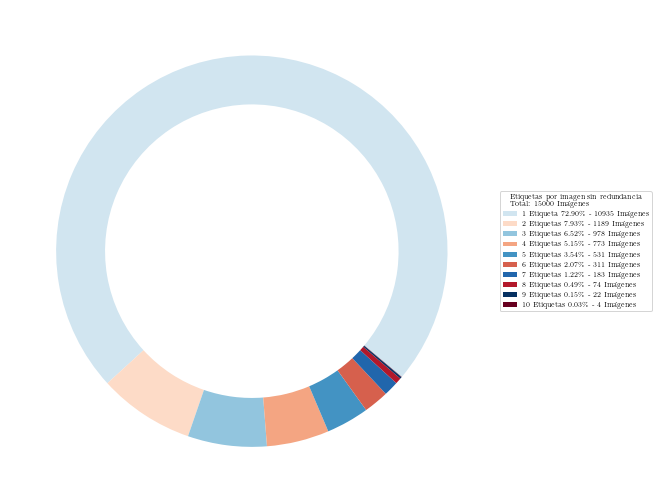

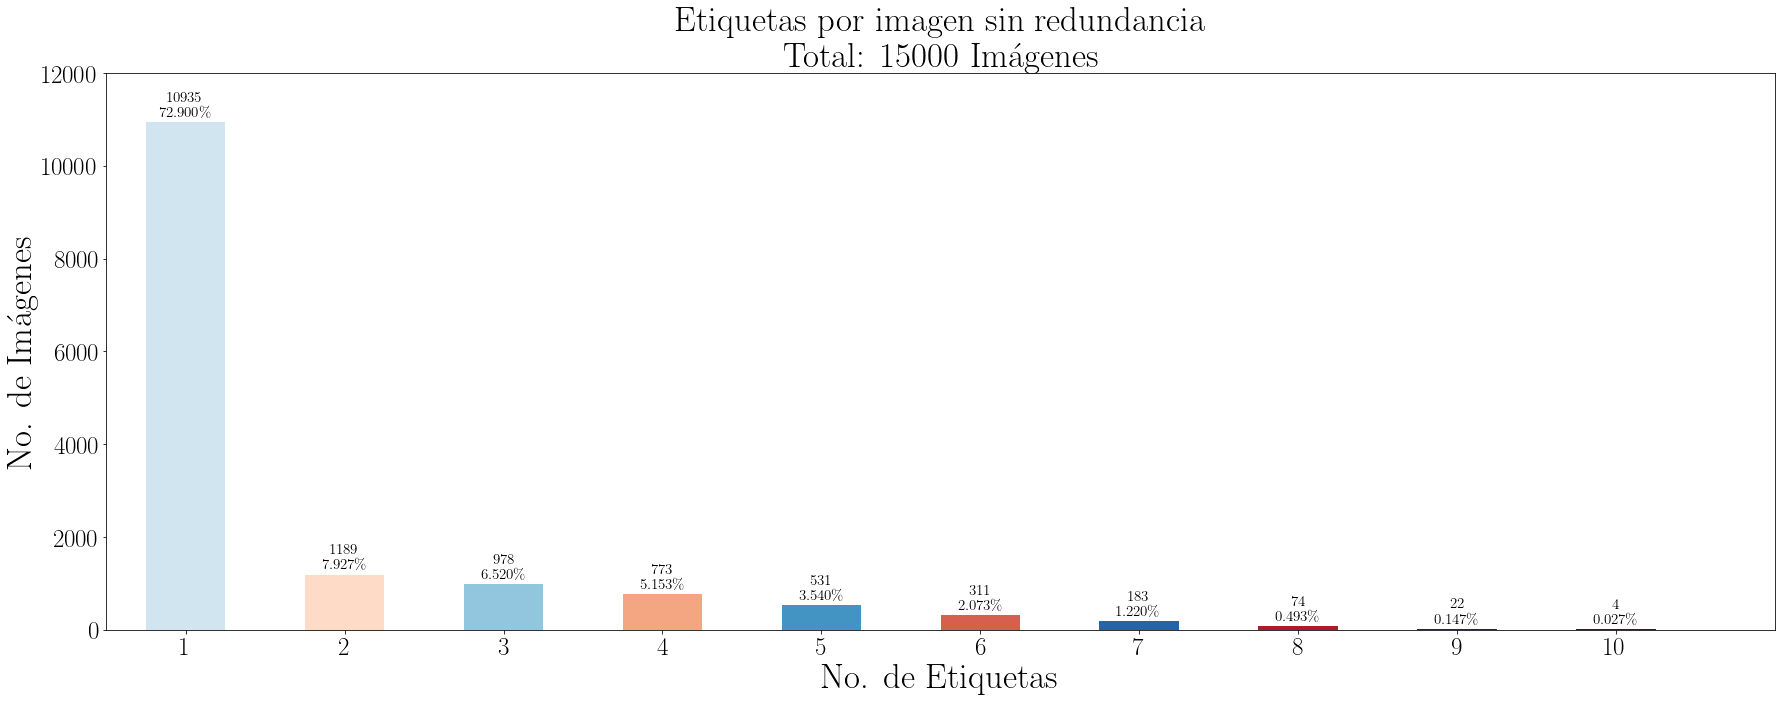

In [11]:
labels =  ['{} Etiquetas {:.2f}\% - {} Imágenes'.format(nlind[i],nlnorm[i]*100,nlraw[i]) if nlind[i] != 1 else '{} Etiqueta {:.2f}\% - {} Imágenes'.format(i+1,nlnorm[i]*100,nlraw[i]) for i in range(len(nlraw))]
data =  nlraw.copy()
title = "   Etiquetas por imagen sin redundancia \n Total: {} Imágenes".format(sum(data))
print('La categoría de 1 etiquetas incluye también las de "sin hallazgo"')
donutPlot(data,labels,title,fontset=7)

# labels = ['1 Etiqueta {:.2f}% \n  {} Imágenes'.format(nlnorm[0]*100,nlraw[0]), '2 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[1]*100, nlraw[1]), '3 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[2]*100, nlraw[2]), '4 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[3]*100, nlraw[3]),
# '5 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[4]*100,nlraw[4]), '6 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[5]*100, nlraw[5]), '7 Etiquetas {:.2f}% \n {} Imágenes'.format(nlnorm[6]*100,nlraw[6]), '8 Etiquetas {:.4f}% \n {} Imágenes'.format(nlnorm[7]*100,nlraw[7]), '9 Etiquetas {:.4f}% \n {} Imágenes'.format(nlnorm[8]*100,nlraw[8])]
# labels  = ['{} Etiqueta'.format(nlind[i]) if nlind[i] == 1 else '{} Etiquetas'.format(nlind[i]) for i in range(len(nlraw))]
labels  = ['{}'.format(nlind[i]) if nlind[i] == 1 else '{}'.format(nlind[i]) for i in range(len(nlraw))]

data = {'Padecimientos':nlraw.copy()}
groupedBarPlot(data,labels,title, width = 0.5, legend = False,figsize=(25,10), barLabel=['{}\n{:.3f}\%',[n*100 for n in nlnorm]],fsizes = {'font':15,'axes':35,'xtick':25, 'ytick':25}, axisLim = {'xlim':[-0.5,10], 'ylim':[0,12000]},axislabels=['No. de Etiquetas','No. de Imágenes']) #, png = '../Figures/VinDr-CXR/Images/ExM2', pdf = '../Figures/VinDr-CXR/PDFs/ExM2')

In [12]:
cLabs = list(vinPxI.value_counts(['image_id']))
q  = len(vin['class_name'].unique())
print('Para el conjunto de datos total con todas las etiquetas, incluso los casos "Sin Hallazgo" \n')

print('La cardinalidad de las etiquetas en el conjunto es: ', LabelCardinality(cLabs))
print('La densidad de las etiquetas en el conjunto es: ', LabelDensity(cLabs, q))

pss = []
lblsimg = {}
for num,im in enumerate(vinPxI['image_id']):
    if im in pss:
        lblsimg[im].add(vinPxI.iloc[num]['class_name'])
    else:
        lblsimg[im] = set()
        lblsimg[im].add(vinPxI.iloc[num]['class_name'])
        pss.append(im)
difflb = []
for i in list(lblsimg.values()):
    if i not in difflb:
        difflb.append(i)
print('El número de conjuntos de etiquetas distintos es:', len(difflb))

Para el conjunto de datos total con todas las etiquetas, incluso los casos "Sin Hallazgo" 

La cardinalidad de las etiquetas en el conjunto es:  1.7314
La densidad de las etiquetas en el conjunto es:  0.11542666666666668
El número de conjuntos de etiquetas distintos es: 1012


In [13]:
counts = {}
indexes = {}
indexc = []
for p in vin['class_name'].unique():
    print(p)
    pb2 = vin[vin['class_name'] == p]['image_id'].unique()
    count = 0
    indexes[p] = []
    for i in pb2:
        if len(vin[vin['class_name'] == p][vin[vin['class_name'] == p]['image_id'] == i]) >= 2:
            indexc.append(vin[vin['class_name'] == p][vin[vin['class_name'] == p]['image_id'] == i].iloc[0]['image_id'])
            indexes[p].append(vin[vin['class_name'] == p][vin[vin['class_name'] == p]['image_id'] == i].iloc[0]['image_id'])
            count += 1
    counts[p] = count
print('Etiquetas declaradas por concenso de mayoria, es decir al menos 2 radiologos coincidentes en cada padecimiento identificado por imagen')
counts

No finding
Cardiomegaly
Aortic enlargement
Pleural thickening
ILD
Nodule/Mass
Pulmonary fibrosis
Lung Opacity
Atelectasis
Other lesion
Infiltration
Pleural effusion
Calcification
Consolidation
Pneumothorax
Etiquetas declaradas por concenso de mayoria, es decir al menos 2 radiologos coincidentes en cada padecimiento identificado por imagen


{'No finding': 10606,
 'Cardiomegaly': 1818,
 'Aortic enlargement': 2347,
 'Pleural thickening': 1252,
 'ILD': 263,
 'Nodule/Mass': 501,
 'Pulmonary fibrosis': 1141,
 'Lung Opacity': 657,
 'Atelectasis': 69,
 'Other lesion': 478,
 'Infiltration': 337,
 'Pleural effusion': 705,
 'Calcification': 215,
 'Consolidation': 132,
 'Pneumothorax': 60}

In [14]:
vin['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [15]:
disma = pd.Series(indexc).value_counts().value_counts()

print('Total de etiquetas distintas por imagen identificadas por concenso de mayoria: ', len(indexc))

# Obtener porcentajes respecto al número de padecimeintos por imágen
nlind =  list(disma.index)
nlraw = list(disma.copy())
nlnorm = [float(i)/sum(nlraw) for i in nlraw]

Total de etiquetas distintas por imagen identificadas por concenso de mayoria:  20581


La categoría de 1 etiqueta incluye también las de "sin hallazgo"


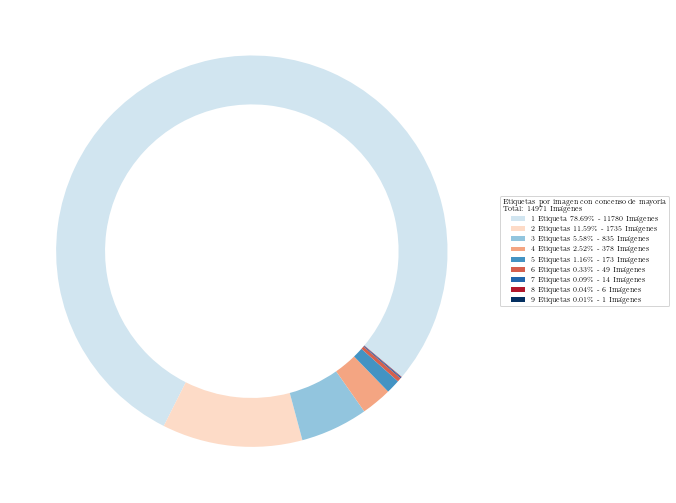

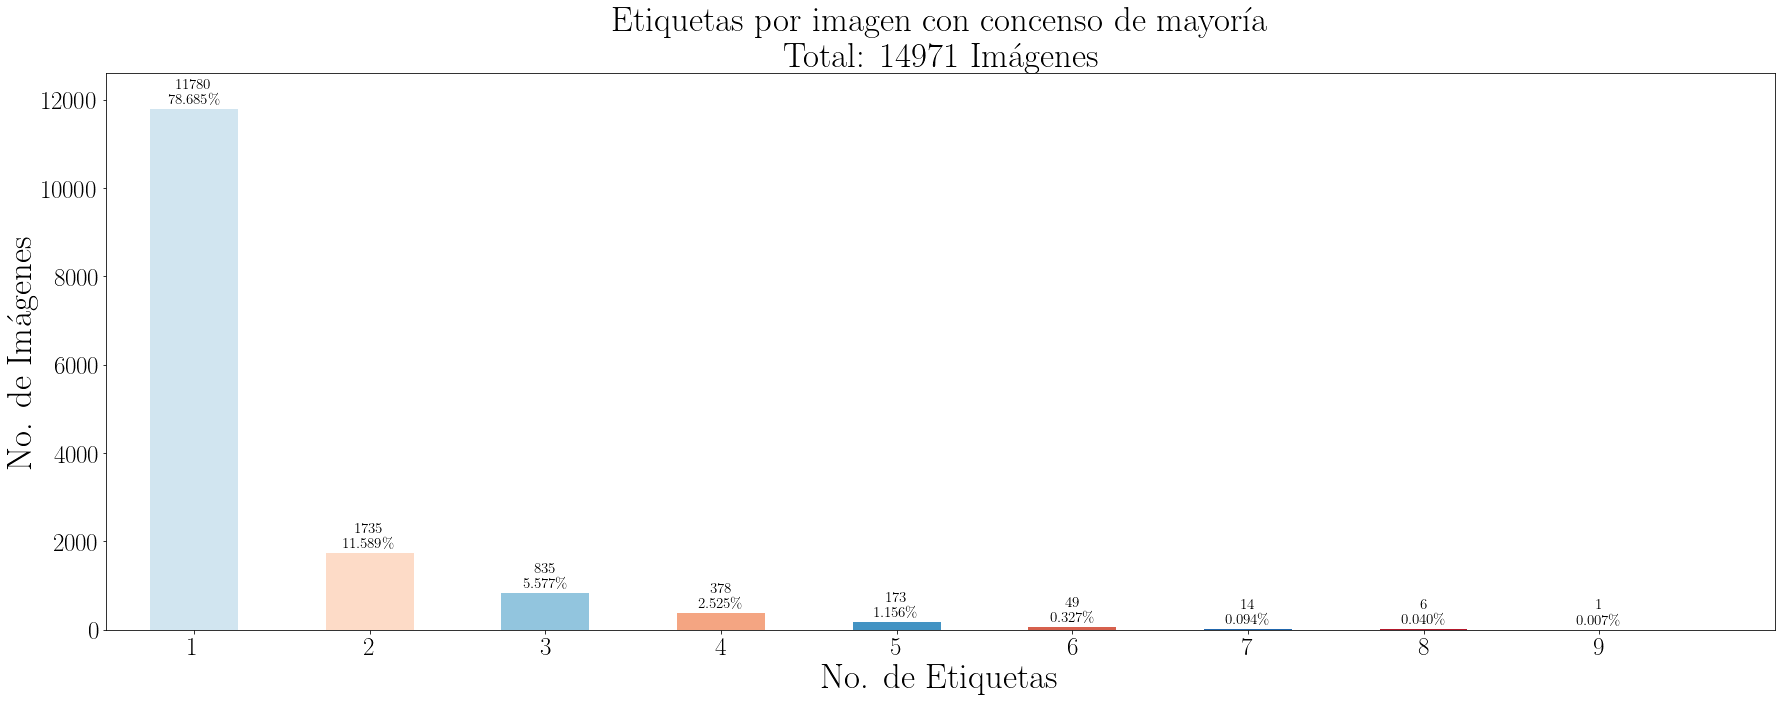

In [16]:
labels =  ['{} Etiquetas {:.2f}\% - {} Imágenes'.format(nlind[i],nlnorm[i]*100,nlraw[i]) if nlind[i] != 1 else '{} Etiqueta {:.2f}\% - {} Imágenes'.format(i+1,nlnorm[i]*100,nlraw[i]) for i in range(len(nlraw))]
data =  nlraw.copy()
title = "   Etiquetas por imagen con concenso de mayoría \n Total: {} Imágenes".format(sum(data))
print('La categoría de 1 etiqueta incluye también las de "sin hallazgo"')
donutPlot(data,labels,title,fontset=7)

labels  = ['{}'.format(nlind[i]) if nlind[i] == 1 else '{}'.format(nlind[i]) for i in range(len(nlraw))]
data = {'Padecimientos':nlraw.copy()}
groupedBarPlot(data,labels,title, width = 0.5, legend = False,figsize=(25,10), barLabel=['{}\n{:.3f}\%',[n*100 for n in nlnorm]],fsizes = {'font':15,'axes':35,'xtick':25, 'ytick':25}, axisLim = {'xlim':[-0.5,9], 'ylim':[0,12600]},axislabels=['No. de Etiquetas','No. de Imágenes']) #, png = '../Figures/VinDr-CXR/Images/ExM2', pdf = '../Figures/VinDr-CXR/PDFs/ExM2')

In [17]:
disma = pd.Series(indexc).value_counts().value_counts()

# Obtener porcentajes respecto al número de padecimeintos por imágen
nlind =  list(disma.index)
nlraw = list(disma.copy())
nlraw[0] = nlraw[0]-counts['No finding']
nlnorm = [float(i)/sum(nlraw) for i in nlraw]

print('Total de etiquetas distintas por imagen identificadas por concenso de mayoria quitando las de (Sin Hallazgo): ', sum(nlraw))

Total de etiquetas distintas por imagen identificadas por concenso de mayoria quitando las de (Sin Hallazgo):  4365


La categoría de 1 etiqueta ya NO incluye también las de "sin hallazgo"


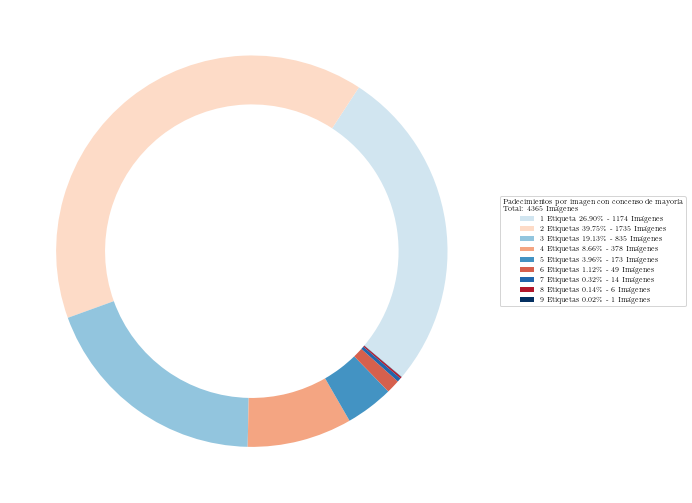

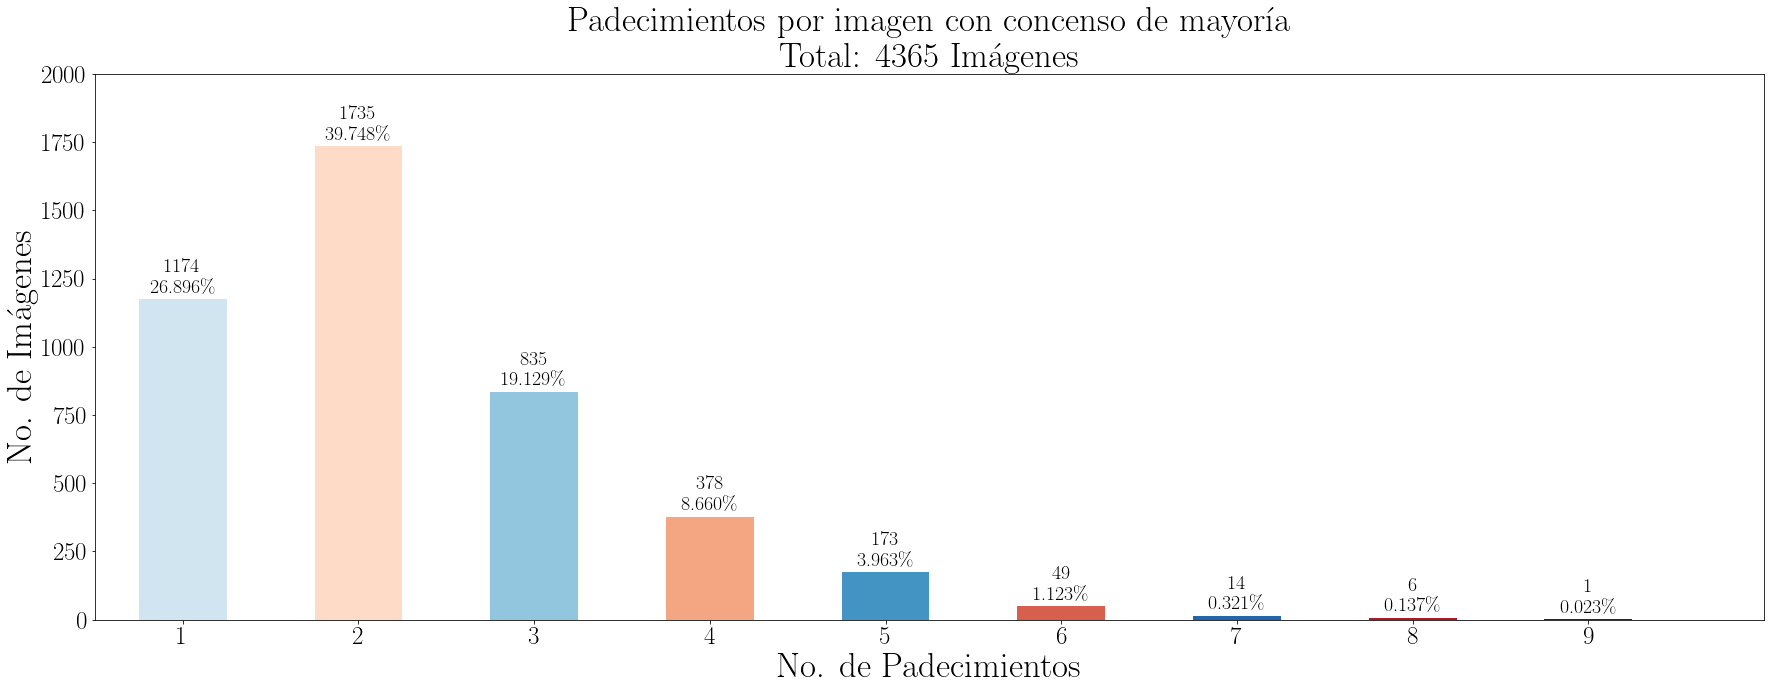

In [18]:
labels =  ['{} Etiquetas {:.2f}\% - {} Imágenes'.format(nlind[i],nlnorm[i]*100,nlraw[i]) if nlind[i] != 1 else '{} Etiqueta {:.2f}\% - {} Imágenes'.format(i+1,nlnorm[i]*100,nlraw[i]) for i in range(len(nlraw))]
data =  nlraw.copy()
title = "   Padecimientos por imagen con concenso de mayoría \n Total: {} Imágenes".format(sum(data))
print('La categoría de 1 etiqueta ya NO incluye también las de "sin hallazgo"')
donutPlot(data,labels,title,fontset=7)

labels  = ['{}'.format(nlind[i]) if nlind[i] == 1 else '{}'.format(nlind[i]) for i in range(len(nlraw))]
data = {'Padecimientos':nlraw.copy()}
groupedBarPlot(data,labels,title, width = 0.5, legend = False,figsize=(25,10), barLabel=['{}\n{:.3f}\%',[n*100 for n in nlnorm]],fsizes = {'font':20,'axes':35,'xtick':25, 'ytick':25}, axisLim = {'xlim':[-0.5,9], 'ylim':[0,2000]},axislabels=['No. de Padecimientos','No. de Imágenes']) #, png = '../Figures/VinDr-CXR/Images/ExM2', pdf = '../Figures/VinDr-CXR/PDFs/ExM2')

In [19]:
disdis = pd.Series(counts)

# Obtener porcentajes respecto a la distribución de las padecimeinto en el conjunto
nlind =  list(disdis.index)
nlraw = list(disdis.copy())
nlnorm = [float(i)/sum(nlraw) for i in nlraw]

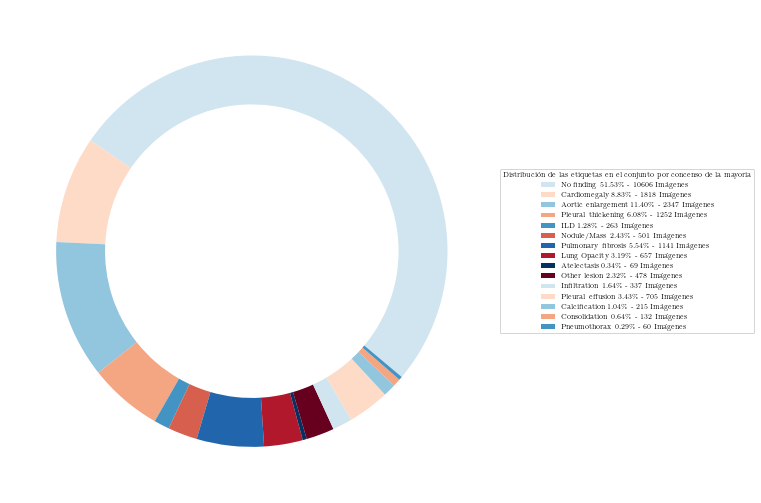

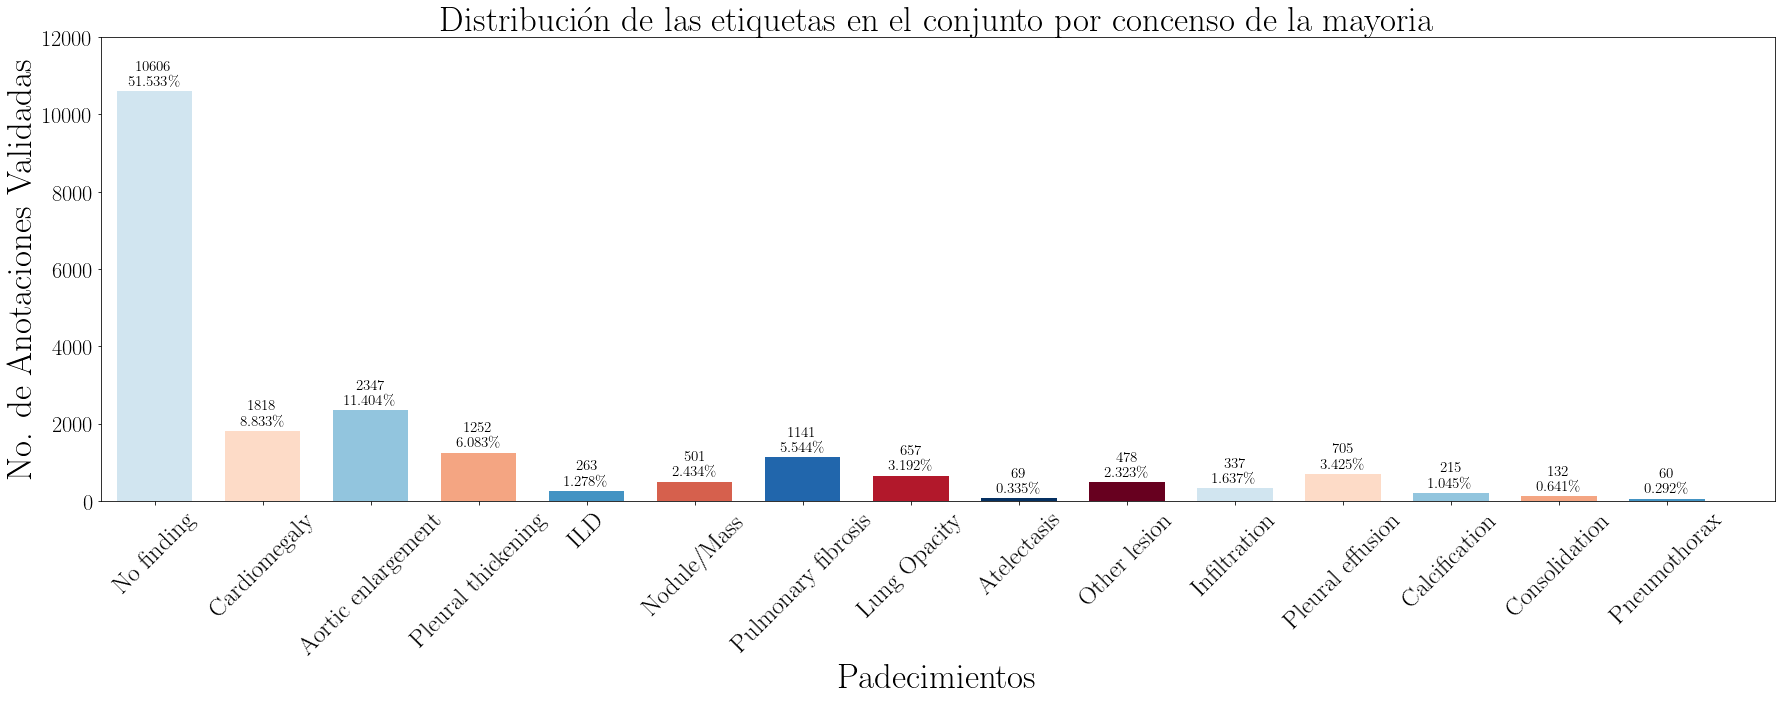

In [28]:
labels =  ['{} {:.2f}\% - {} Imágenes'.format(nlind[i],nlnorm[i]*100,nlraw[i]) if nlind[i] != 1 else '{} {:.2f}\% - {} Imágenes'.format(i+1,nlnorm[i]*100,nlraw[i]) for i in range(len(nlraw))]
data =  nlraw.copy()
title = "   Distribución de las etiquetas en el conjunto por concenso de la mayoria".format(len(vimages))
donutPlot(data,labels,title,fontset=7)

labels  = ['{}'.format(nlind[i]) if nlind[i] == 1 else '{}'.format(nlind[i]) for i in range(len(nlraw))]
data = {'Padecimientos':nlraw.copy()}
groupedBarPlot(data,labels,title, width = 0.7, legend = False,figsize=(25,10), xtick_rot = 45, barLabel=['{}\n{:.3f}\%',[n*100 for n in nlnorm]],fsizes = {'font':15,'axes':35,'xtick':25, 'ytick':22.5}, axisLim = {'xlim':[-0.5,15], 'ylim':[0,12000]},axislabels=['Padecimientos','No. de Anotaciones Validadas']) #, png = '../Figures/VinDr-CXR/Images/ExM2', pdf = '../Figures/VinDr-CXR/PDFs/ExM2')

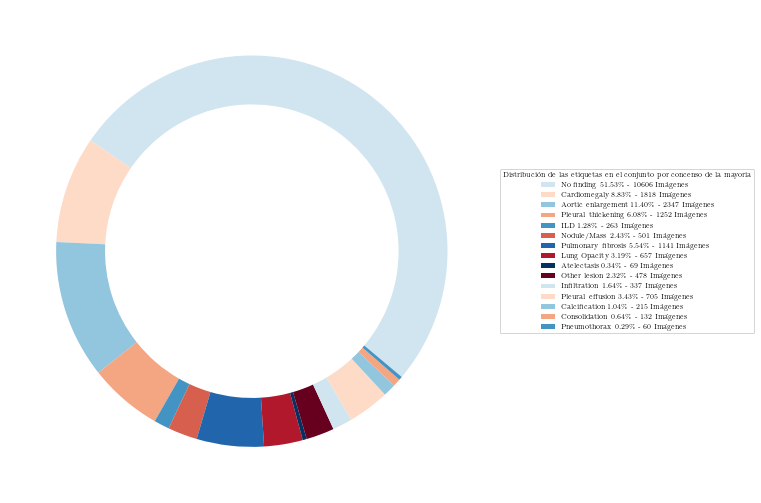

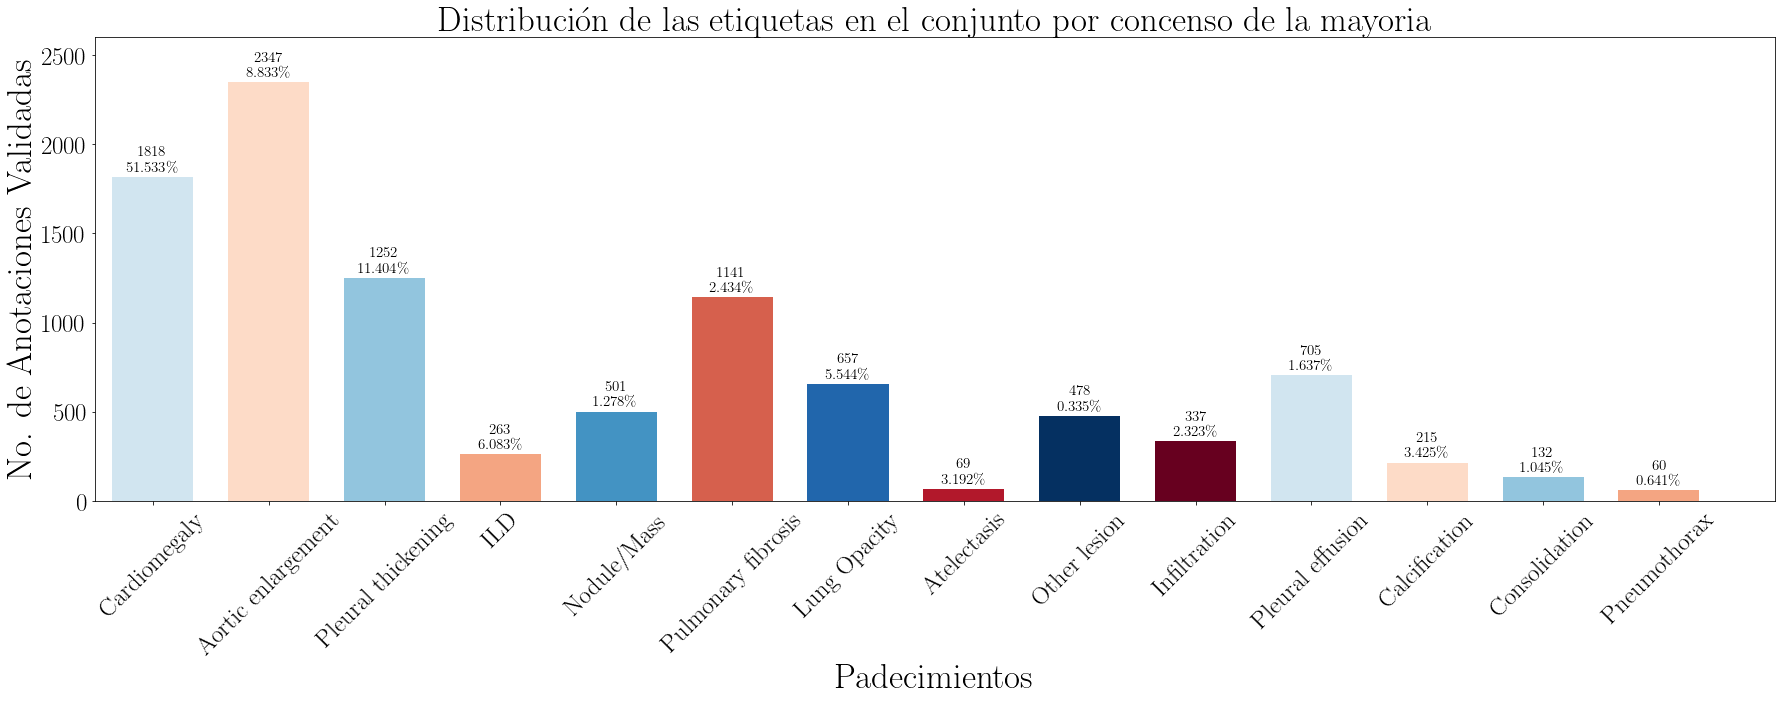

In [31]:
labels =  ['{} {:.2f}\% - {} Imágenes'.format(nlind[i],nlnorm[i]*100,nlraw[i]) if nlind[i] != 1 else '{} {:.2f}\% - {} Imágenes'.format(i+1,nlnorm[i]*100,nlraw[i]) for i in range(len(nlraw))]
data =  nlraw.copy()
title = "   Distribución de las etiquetas en el conjunto por concenso de la mayoria".format(len(vimages))
donutPlot(data,labels,title,fontset=7)

labels  = ['{}'.format(nlind[i]) if nlind[i] == 1 else '{}'.format(nlind[i]) for i in range(len(nlraw))]
data = {'Padecimientos':nlraw[1:]}
groupedBarPlot(data,labels[1:],title, width = 0.7, legend = False,figsize=(25,10), xtick_rot = 45, barLabel=['{}\n{:.3f}\%',[n*100 for n in nlnorm]],fsizes = {'font':15,'axes':35,'xtick':25, 'ytick':25}, axisLim = {'xlim':[-0.5,14], 'ylim':[0,2600]},axislabels=['Padecimientos','No. de Anotaciones Validadas']) #, png = '../Figures/VinDr-CXR/Images/ExM2', pdf = '../Figures/VinDr-CXR/PDFs/ExM2')

In [ ]:
LIMIT = 10 #since the dataset is large, it can be set to small number for testing purpose or 0 to get all the data

def extract_DICOM_attributes(folder_path):
    text_file = open("dicom_metadata.txt", "w")
    cnt = 0
    images = list(os.listdir(folder_path))
    df = pd.DataFrame()
    
    for image in images:
        cnt += 1
        if cnt == LIMIT: 
            break
            
        image_name = image.split(".")[0]
        dicom_file_path = os.path.join(folder_path,image)
        dicom_file_dataset = dcm.read_file(dicom_file_path)
        text_file.write(str(dicom_file_dataset))
        rows = dicom_file_dataset.Rows
        columns = dicom_file_dataset.Columns
        
        ElementKeys = dicom_file_dataset.dir()
        print(ElementKeys)
        
        PatientSex = dicom_file_dataset.PatientSex if 'PatientSex' in ElementKeys else ""
        PatientWeight = dicom_file_dataset.PatientWeight if 'PatientWeight' in ElementKeys else ""
        PatientAge = dicom_file_dataset.PatientAge if 'PatientAge' in ElementKeys else ""
        PhotometricInterpretation = dicom_file_dataset.PhotometricInterpretation if 'PhotometricInterpretation' in ElementKeys else ""
        Rows = dicom_file_dataset.Rows
        Columns = dicom_file_dataset.Columns
#         for k, v in dicom_file_dataset.items():
#             print(k, v) 

        df = df.append(pd.DataFrame({'Image_name': image_name, 
                        'PatientSex': PatientSex,'PatientWeight':PatientWeight, 'PatientAge': PatientAge, 'PhotometricInterpretation': PhotometricInterpretation,
                        'Rows': Rows,'Columns': Columns}, index = [cnt]))
    text_file.close()
    print(df)
    return df
extract_DICOM_attributes('../input/vinbigdata-chest-xray-abnormalities-detection/train')